In [ ]:
from transformers import AutoTokenizer
from datasets import load_dataset
from tqdm import tqdm
import torch
from prettytable import PrettyTable
# from model_distill_bert import getmodel
from utilities import compute_accuracy, compute_masks, mask_distillbert, get_model_distilbert, record_activations, mask_range_distilbert



tokenizer = AutoTokenizer.from_pretrained("esuriddick/distilbert-base-uncased-finetuned-emotion")
# Check if a GPU is available and use it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Load the dataset
dataset_all = load_dataset("dair-ai/emotion")
# Select the train split
dataset_all = dataset_all['train']
all_fc_vals = []
for j in range(0,6):
    model = get_model_distilbert("2O24dpower2024/distilbert-base-uncased-finetuned-emotion",5)
    dataset = dataset_all.filter(lambda x: x['label'] in [j])
    dataset_complement = dataset_all.filter(lambda x: x['label'] not in [j])
    print("Recording activations...")
    progress_bar = tqdm(total=len(dataset))
    model.to(device)
    model.eval()
    fc_vals = []
    all_fc_vals.append(record_activations(dataset, model, tokenizer, text_tag='text', mask_layer=5, batch_size=256))

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from ipywidgets import VBox, Output
from utilities import compute_masks
from IPython.display import display

output_widgets = []

for i, fc1 in enumerate(all_fc_vals):
    fc1 = np.array(fc1)
    mask_max, mask_std, mask_intersection, mask_max_low_std, mask_max_high_std, mask_std_high_max = compute_masks(fc1, 0.5)
    # mask_std = mask_max_low_std
    
    m = np.mean(np.abs(fc1), axis=0)
    s = np.std(fc1, axis=0)
    min_val = np.min(fc1, axis=0)
    max_val = np.max(fc1, axis=0)
    
    # Normalize std and mean
    s_norm = (s - min_val) / (max_val - min_val)
    m_norm = m#(m - min_val) / (max_val - min_val)
    
    # Create indices for different masks
    indices_max = np.where(mask_max == 0)[0]
    indices_std = np.where(mask_std == 0)[0]
    indices_intersection = np.intersect1d(indices_max, indices_std)
    indices_max_minus_std = np.setdiff1d(indices_max, indices_std)
    indices_std_minus_max = np.setdiff1d(indices_std, indices_max)
    
    # Count the indices in each set
    count_all = len(m_norm)
    count_max = len(indices_max)
    count_std = len(indices_std)
    count_intersection = len(indices_intersection)
    count_max_minus_std = len(indices_max_minus_std)
    count_std_minus_max = len(indices_std_minus_max)
    
    out = Output()
    with out:
        # Create subplots with counts in titles
        fig = make_subplots(rows=2, cols=3, 
                            subplot_titles=(f"All Activations (Count: {count_all})",
                                            f"Max Mask (Count: {count_max})", 
                                            f"Std Mask (Count: {count_std})", 
                                            f"Intersection (Count: {count_intersection})",
                                            f"Max - Std (Count: {count_max_minus_std})", 
                                            f"Std - Max (Count: {count_std_minus_max})"))
        
        # Helper function to add traces
        def add_traces(indices, row, col):
            indices_list = list(indices)  # Convert range or numpy array to list
            fig.add_trace(
                go.Scatter(
                    x=indices_list,
                    y=m_norm[indices_list],
                    mode='markers',
                    name='Mean',
                    marker=dict(size=3, color='blue'),
                    showlegend=(row == 1 and col == 1)
                ),
                row=row, col=col
            )
            fig.add_trace(
                go.Scatter(
                    x=indices_list,
                    y=s_norm[indices_list],
                    mode='markers',
                    name='Std Dev',
                    marker=dict(size=3, color='red'),
                    showlegend=(row == 1 and col == 1)
                ),
                row=row, col=col
            )
            for j in indices_list:
                fig.add_trace(
                    go.Scatter(
                        x=[j, j],
                        y=[m_norm[j], s_norm[j]],
                        mode='lines',
                        line=dict(color='gray', width=0.5),
                        showlegend=False
                    ),
                    row=row, col=col
                )
        
        # Add traces for all activations
        add_traces(range(len(m_norm)), 1, 1)
        
        # Add traces for other plots
        add_traces(indices_max, 1, 2)
        add_traces(indices_std, 1, 3)
        add_traces(indices_intersection, 2, 1)
        add_traces(indices_max_minus_std, 2, 2)
        add_traces(indices_std_minus_max, 2, 3)
        
        # Update layout
        fig.update_layout(
            title=f'Mean and Standard Deviation of Activations - Class {i+1}',
            height=1200,
            width=1800,
            hovermode='closest'
        )
        
        # Update x and y axis labels for all subplots
        for row in range(1, 3):
            for col in range(1, 4):
                fig.update_xaxes(title_text="Activation Index", row=row, col=col)
                fig.update_yaxes(title_text="Normalized Value", row=row, col=col)
        
        display(fig)
    
    output_widgets.append(out)

# Display all figures in a vertical box
# display(VBox(output_widgets))

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
from ipywidgets import VBox, Output
from utilities import compute_masks
from IPython.display import display

def create_index_tracking_plot(indices_per_class, title):
    num_classes = len(indices_per_class)
    all_indices = sorted(set.union(*[set(indices) for indices in indices_per_class]))
    
    fig = go.Figure()
    
    # Create a color scale
    color_scale = px.colors.diverging.RdYlGn_r  # Red to Yellow to Green color scale

    # Add edges for indices present in multiple classes
    for idx in all_indices:
        classes_with_idx = [i for i, indices in enumerate(indices_per_class) if idx in indices]
        if len(classes_with_idx) > 1:
            x = [idx] * len(classes_with_idx)
            y = classes_with_idx
            color_index = (len(classes_with_idx) - 1) / (num_classes - 1)  # Normalize to [0, 1]
            edge_color = px.colors.sample_colorscale(color_scale, [color_index])[0]
            
            fig.add_trace(go.Scatter(
                x=x,
                y=y,
                mode='lines',
                line=dict(color=edge_color, width=2),
                hoverinfo='text',
                hovertext=f'Index: {idx}<br>Present in {len(classes_with_idx)} classes',
                showlegend=False
            ))
    
    # Add scatter plots for each class
    for class_idx, indices in enumerate(indices_per_class):
        fig.add_trace(go.Scatter(
            x=indices,
            y=[class_idx] * len(indices),
            mode='markers',
            name=f'Class {class_idx + 1}',
            marker=dict(size=4, symbol='circle', color='black'),
            hoverinfo='text',
            hovertext=[f'Index: {idx}<br>Class: {class_idx + 1}' for idx in indices]
        ))
    
    fig.update_layout(
        title=title,
        xaxis_title='Activation Index',
        yaxis_title='Class',
        yaxis=dict(
            tickmode='array',
            tickvals=list(range(num_classes)),
            ticktext=[f'Class {i+1}' for i in range(num_classes)]
        ),
        hovermode='closest',
        width=1500,
        height=800,
        plot_bgcolor='white',
        showlegend=False
    )
    
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
    
    # Add color bar
    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='markers',
        marker=dict(
            colorscale=color_scale,
            showscale=True,
            cmin=1,
            cmax=num_classes,
            colorbar=dict(
                title='Number of Classes',
                tickvals=list(range(1, num_classes+1)),
                ticktext=list(range(1, num_classes+1))
            )
        ),
        hoverinfo='none',
        showlegend=False
    ))
    
    return fig

# Collect indices for each class
max_indices_per_class = []
std_indices_per_class = []

for fc1 in all_fc_vals:
    mask_max, mask_std, mask_intersection, mask_max_low_std, mask_max_high_std, mask_std_high_max= compute_masks(fc1, 0.2)
    max_indices_per_class.append(np.where(mask_max == 0)[0])
    std_indices_per_class.append(np.where(mask_std == 0)[0])

# Create and display visualizations
output_widgets = []

out = Output()
with out:
    fig_max = create_index_tracking_plot(max_indices_per_class, 'Max Mask Indices Across Classes')
    display(fig_max)
output_widgets.append(out)

out = Output()
with out:
    fig_std = create_index_tracking_plot(std_indices_per_class, 'Std Mask Indices Across Classes')
    display(fig_std)
output_widgets.append(out)

# Display all visualizations
# display(VBox(output_widgets))

In [ ]:
import torch
import numpy as np
import plotly.graph_objects as go
from ipywidgets import VBox, Output
from IPython.display import display

def find_common_masked_neurons(masks_per_class):
    """
    Find neurons that are masked (inactive) in all classes
    """
    # Convert all masks to numpy boolean arrays
    bool_masks = []
    for mask in masks_per_class:
        if torch.is_tensor(mask):
            mask = mask.cpu().numpy()
        bool_masks.append(mask.astype(np.bool_))
    
    # Find neurons that are masked (True) in all classes
    common_masked = bool_masks[0]  # Start with first mask
    for mask in bool_masks[1:]:
        common_masked = common_masked & mask
    
    return common_masked

def compute_activation_stats(fc_vals, tao=0.2):
    """
    Compute activation statistics for neurons
    """
    if torch.is_tensor(fc_vals):
        fc_vals = fc_vals.cpu().numpy()
    
    mean = np.mean(fc_vals, axis=0)
    std = np.std(fc_vals, axis=0)
    
    lower_bound = mean - tao * std
    upper_bound = mean + tao * std
    
    return mean, std, lower_bound, upper_bound

def create_common_masked_plot(fc_vals_per_class, masks_per_class, tao=0.2, title="Common Masked Neurons Across Classes"):
    """
    Create a visualization of activation ranges for neurons that are commonly masked across all classes.
    """
    # Find common masked neurons
    common_masked = find_common_masked_neurons(masks_per_class)
    masked_indices = np.where(common_masked)[0]
    
    if len(masked_indices) == 0:
        print("No common masked neurons found across all classes!")
        return None
        
    print(f"Found {len(masked_indices)} neurons masked across all classes")
    print(f"Indices of commonly masked neurons: {masked_indices}")
    
    # Colors for different classes
    colors = [f'rgb({r}, {g}, {b})' for r, g, b in [
        (31, 119, 180),  # blue
        (255, 127, 14),  # orange
        (44, 160, 44),   # green
        (214, 39, 40),   # red
        (148, 103, 189), # purple
        (140, 86, 75),   # brown
        (227, 119, 194), # pink
        (127, 127, 127), # gray
    ]]
    
    fig = go.Figure()
    
    # Process each class
    for class_idx, fc_vals in enumerate(fc_vals_per_class):
        if torch.is_tensor(fc_vals):
            fc_vals = fc_vals.cpu().numpy()
            
        # Compute statistics for masked neurons only
        mean, std, lower_bound, upper_bound = compute_activation_stats(fc_vals, tao)
        
        color = colors[class_idx % len(colors)]
        fill_color = color.replace('rgb', 'rgba').replace(')', ', 0.2)')
        
        # Add range area
        fig.add_trace(go.Scatter(
            x=np.concatenate([masked_indices, masked_indices[::-1]]),
            y=np.concatenate([upper_bound[common_masked], lower_bound[common_masked][::-1]]),
            fill='toself',
            fillcolor=fill_color,
            line=dict(color='rgba(0,0,0,0)'),
            name=f'Range Class {class_idx + 1}',
            showlegend=False,
            hoverinfo='skip'
        ))
        
        # Add mean points
        fig.add_trace(go.Scatter(
            x=masked_indices,
            y=mean[common_masked],
            mode='markers',
            marker=dict(
                size=6,
                color=color,
                symbol='circle'
            ),
            name=f'Class {class_idx + 1}',
            hovertemplate=(
                "Neuron: %{x}<br>" +
                "Mean: %{y:.3f}<br>" +
                f"Range: %{{customdata[0]:.3f}} to %{{customdata[1]:.3f}}<br>" +
                f"Class: {class_idx + 1}"
            ),
            customdata=np.column_stack((
                lower_bound[common_masked],
                upper_bound[common_masked]
            ))
        ))

    # Add vertical lines for better visualization of neuron positions
    for idx in masked_indices:
        fig.add_shape(
            type="line",
            x0=idx,
            x1=idx,
            y0=fig.layout.yaxis.range[0] if fig.layout.yaxis.range else min(lower_bound[common_masked]),
            y1=fig.layout.yaxis.range[1] if fig.layout.yaxis.range else max(upper_bound[common_masked]),
            line=dict(color="lightgray", width=1, dash="dot")
        )

    fig.update_layout(
        title=title,
        xaxis_title='Neuron Index',
        yaxis_title='Activation Value',
        width=1500,
        height=800,
        plot_bgcolor='white',
        showlegend=True,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.99
        )
    )
    
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
    
    return fig

def visualize_common_masked(all_fc_vals, all_masks, tao=0.2):
    """
    Create and display visualization for common masked neurons
    """
    out = Output()
    with out:
        fig = create_common_masked_plot(
            all_fc_vals,
            all_masks,
            tao=tao,
            title='Common Masked Neurons Across Classes'
        )
        if fig is not None:
            display(fig)
    
    display(out)


# Example usage:

# Assuming you have your data ready:
# all_fc_vals: list of activation values for each class
# all_masks: list of masks computed from compute_masks function

# First, compute the masks if you haven't already
all_masks = []
for fc1 in all_fc_vals:
    mask_max, mask_std, mask_intersection, mask_max_low_std, mask_max_high_std, mask_std_high_max = compute_masks(fc1, 0.5)
    all_masks.append(mask_max)  # or whichever mask type you want to visualize

# Then create the visualization
visualize_common_masked(all_fc_vals, all_masks, tao=2)

In [ ]:
import torch
import numpy as np
import plotly.graph_objects as go
from ipywidgets import VBox, Output
from IPython.display import display

def find_common_masked_neurons(masks_per_class):
    """
    Find neurons that are masked (inactive) in all classes
    """
    bool_masks = []
    for mask in masks_per_class:
        if torch.is_tensor(mask):
            mask = mask.cpu().numpy()
        bool_masks.append(mask.astype(np.bool_))
    
    common_masked = bool_masks[0]
    for mask in bool_masks[1:]:
        common_masked = common_masked & mask
    
    return common_masked

def create_common_masked_boxplot(fc_vals_per_class, masks_per_class, title="Common Masked Neurons Box Plot"):
    """
    Create a box plot visualization of activation distributions for commonly masked neurons across classes.
    """
    # Find common masked neurons
    common_masked = find_common_masked_neurons(masks_per_class)
    masked_indices = np.where(common_masked)[0]
    
    if len(masked_indices) == 0:
        print("No common masked neurons found across all classes!")
        return None
        
    print(f"Found {len(masked_indices)} neurons masked across all classes")
    print(f"Indices of commonly masked neurons: {masked_indices}")
    
    # Colors for different classes
    colors = [
        'rgb(31, 119, 180)',   # blue
        'rgb(255, 127, 14)',   # orange
        'rgb(44, 160, 44)',    # green
        'rgb(214, 39, 40)',    # red
        'rgb(148, 103, 189)',  # purple
        'rgb(140, 86, 75)',    # brown
        'rgb(227, 119, 194)',  # pink
        'rgb(127, 127, 127)'   # gray
    ]
    
    fig = go.Figure()
    
    # Process each neuron
    for i, neuron_idx in enumerate(masked_indices):
        # Collect activation values for this neuron across all classes
        for class_idx, fc_vals in enumerate(fc_vals_per_class):
            if torch.is_tensor(fc_vals):
                fc_vals = fc_vals.cpu().numpy()
            
            # Convert fc_vals to numpy array if it's a list
            if isinstance(fc_vals, list):
                fc_vals = np.array(fc_vals)
            
            # Check if fc_vals is 1D or 2D
            if len(fc_vals.shape) == 1:
                neuron_activations = fc_vals
            else:
                neuron_activations = fc_vals[:, neuron_idx]
            
            fig.add_trace(go.Box(
                y=neuron_activations,
                x=[f"Neuron {neuron_idx}"] * len(neuron_activations),
                name=f"Class {class_idx + 1}",
                boxpoints='outliers',
                marker_color=colors[class_idx % len(colors)],
                showlegend=True if i == 0 else False,  # Show legend only for first neuron
                hovertemplate=(
                    "Neuron: %{x}<br>" +
                    "Q1: %{q1:.3f}<br>" +
                    "Median: %{median:.3f}<br>" +
                    "Q3: %{q3:.3f}<br>" +
                    "Min: %{lowerfence:.3f}<br>" +
                    "Max: %{upperfence:.3f}<br>" +
                    f"Class: {class_idx + 1}"
                )
            ))

    # Update layout
    fig.update_layout(
        title=title,
        xaxis_title='Neuron Index',
        yaxis_title='Activation Value',
        width=1500,
        height=800,
        plot_bgcolor='white',
        showlegend=True,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.99
        ),
        boxmode='group'  # Group boxes for each neuron
    )
    
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
    
    return fig

def visualize_common_masked_boxplot(all_fc_vals, all_masks):
    """
    Create and display box plot visualization for common masked neurons
    """
    out = Output()
    with out:
        fig = create_common_masked_boxplot(
            all_fc_vals,
            all_masks,
            title='Common Masked Neurons Distribution Across Classes'
        )
        if fig is not None:
            display(fig)
    
    display(out)

# Example usage:
# all_fc_vals: list of activation values for each class
# all_masks: list of masks computed from compute_masks function

# First, compute the masks if you haven't already
all_masks = []
for fc1 in all_fc_vals:
    mask_max, mask_std, mask_intersection, mask_max_low_std, mask_max_high_std, mask_std_high_max = compute_masks(fc1, 0.5)
    all_masks.append(mask_max)  # or whichever mask type you want to visualize

# Then create the visualization
visualize_common_masked_boxplot(all_fc_vals, all_masks)

In [ ]:
import torch
import numpy as np
import plotly.graph_objects as go
from itertools import combinations
from ipywidgets import VBox, Output
from IPython.display import display

def find_common_masked_neurons(masks_per_class):
    """Find neurons that are masked in all classes"""
    bool_masks = [mask.cpu().numpy().astype(np.bool_) if torch.is_tensor(mask) 
                 else mask.astype(np.bool_) for mask in masks_per_class]
    common_masked = bool_masks[0]
    for mask in bool_masks[1:]:
        common_masked = common_masked & mask
    return common_masked

def compute_ranges(fc_vals_per_class, common_masked, tao=0.2):
    """Compute activation ranges for each class"""
    ranges = []
    for fc_vals in fc_vals_per_class:
        if torch.is_tensor(fc_vals):
            fc_vals = fc_vals.cpu().numpy()
        mean = np.mean(fc_vals, axis=0)[common_masked]
        std = np.std(fc_vals, axis=0)[common_masked]
        ranges.append({
            'lower': mean - tao * std,
            'upper': mean + tao * std
        })
    return ranges

def compute_overlap_percentage(range1, range2):
    """Compute overlap percentage between two ranges"""
    overlap_percentages = []
    for i in range(len(range1['lower'])):
        lower = max(range1['lower'][i], range2['lower'][i])
        upper = min(range1['upper'][i], range2['upper'][i])
        
        if lower > upper:
            overlap_percentages.append(0)
        else:
            total_range = max(range1['upper'][i], range2['upper'][i]) - min(range1['lower'][i], range2['lower'][i])
            overlap = upper - lower
            overlap_percentages.append((overlap / total_range) * 100)
    
    return np.mean(overlap_percentages)

def create_overlap_heatmap(fc_vals_per_class, masks_per_class, tao=0.2):
    """Create a heatmap showing range overlaps between all class combinations"""
    common_masked = find_common_masked_neurons(masks_per_class)
    masked_indices = np.where(common_masked)[0]
    
    if len(masked_indices) == 0:
        print("No common masked neurons found!")
        return None
        
    print(f"Analyzing {len(masked_indices)} commonly masked neurons")
    
    # Compute ranges for each class
    ranges = compute_ranges(fc_vals_per_class, common_masked, tao)
    num_classes = len(fc_vals_per_class)
    
    # Initialize overlap matrix
    overlap_matrix = np.zeros((num_classes, num_classes))
    
    # Compute overlaps for all class pairs
    for i in range(num_classes):
        for j in range(num_classes):
            if i == j:
                overlap_matrix[i, j] = 100
            else:
                overlap_matrix[i, j] = compute_overlap_percentage(ranges[i], ranges[j])
    
    # Create heatmap
    fig = go.Figure(data=go.Heatmap(
        z=overlap_matrix,
        x=[f'Class {i+1}' for i in range(num_classes)],
        y=[f'Class {i+1}' for i in range(num_classes)],
        colorscale='RdYlBu',
        colorbar=dict(title='Overlap %'),
        text=np.round(overlap_matrix, 1),
        texttemplate='%{text}%',
        textfont={"size": 12},
        hoverongaps=False,
    ))
    
    fig.update_layout(
        title='Range Overlap Percentage Between Classes (Common Masked Neurons)',
        width=800,
        height=800,
    )
    
    # Create bar plot for average overlap per class combination
    combinations_data = []
    for k in range(2, num_classes + 1):
        for combo in combinations(range(num_classes), k):
            overlap_sum = 0
            count = 0
            neuron_count = 0
            
            # For each neuron, check if it overlaps in all classes in the combination
            for neuron_idx in range(len(masked_indices)):
                overlaps = True
                min_upper = float('inf')
                max_lower = float('-inf')
                
                for class_idx in combo:
                    min_upper = min(min_upper, ranges[class_idx]['upper'][neuron_idx])
                    max_lower = max(max_lower, ranges[class_idx]['lower'][neuron_idx])
                
                if max_lower <= min_upper:
                    neuron_count += 1
            
            combo_classes = [f'Class {i+1}' for i in combo]
            combinations_data.append({
                'classes': ' + '.join(combo_classes),
                'num_classes': len(combo),
                'overlapping_neurons': neuron_count,
                'total_neurons': len(masked_indices),
                'percentage': (neuron_count / len(masked_indices)) * 100
            })
    
    # Create bar plot
    fig2 = go.Figure()
    
    # Sort combinations by number of classes and percentage
    combinations_data.sort(key=lambda x: (x['num_classes'], -x['percentage']))
    
    # Add bars
    fig2.add_trace(go.Bar(
        x=[d['classes'] for d in combinations_data],
        y=[d['percentage'] for d in combinations_data],
        text=[f"{d['percentage']:.1f}%<br>({d['overlapping_neurons']}/{d['total_neurons']})" 
              for d in combinations_data],
        textposition='auto',
        hovertemplate=(
            "Classes: %{x}<br>" +
            "Overlap: %{text}<br>" +
            "<extra></extra>"
        )
    ))
    
    fig2.update_layout(
        title='Percentage of Neurons with Overlapping Ranges by Class Combination',
        xaxis_title='Class Combinations',
        yaxis_title='Percentage of Neurons with Overlapping Ranges',
        width=1500,
        height=800,
        showlegend=False,
        xaxis_tickangle=45
    )
    
    return fig, fig2

def visualize_range_overlaps(all_fc_vals, all_masks, tao=0.2):
    """Create and display overlap visualizations"""
    out = Output()
    with out:
        figs = create_overlap_heatmap(all_fc_vals, all_masks, tao)
        if figs is not None:
            fig1, fig2 = figs
            print("\nHeatmap of pairwise range overlaps:")
            display(fig1)
            print("\nOverlap analysis for different class combinations:")
            display(fig2)
    
    display(out)
    
all_masks = []
for fc1 in all_fc_vals:
    mask_max, mask_std, mask_intersection, mask_max_low_std, mask_max_high_std, mask_std_high_max = compute_masks(fc1, 0.5)
    all_masks.append(mask_max)
    
    
visualize_range_overlaps(all_fc_vals, all_masks, tao=2)


In [ ]:
import torch
import numpy as np
import plotly.graph_objects as go
from itertools import combinations
from ipywidgets import VBox, Output
from IPython.display import display

def compute_ranges_and_overlaps(fc_vals_per_class, masks_per_class, tao=0.2):
    """
    Compute ranges and find overlapping neurons between different class combinations
    """
    num_classes = len(fc_vals_per_class)
    # Get number of neurons from the first activation array
    first_fc = fc_vals_per_class[0]
    if isinstance(first_fc, list):
        num_neurons = len(first_fc[0])
    else:
        num_neurons = first_fc.shape[1] if hasattr(first_fc, 'shape') else len(first_fc[0])
    
    # Convert all data to numpy arrays and compute ranges in one pass
    ranges = []
    masks_np = []
    
    for fc_vals, mask in zip(fc_vals_per_class, masks_per_class):
        # Convert and compute fc_vals statistics
        if isinstance(fc_vals, list):
            fc_vals = np.array(fc_vals)
        elif torch.is_tensor(fc_vals):
            fc_vals = fc_vals.cpu().numpy()
            
        mean = np.mean(fc_vals, axis=0)
        std = np.std(fc_vals, axis=0)
        ranges.append({
            'mean': mean,
            'lower': mean - tao * std,
            'upper': mean + tao * std
        })
        
        # Convert masks
        if torch.is_tensor(mask):
            mask = mask.cpu().numpy()
        masks_np.append(mask.astype(bool))
    
    # Compute overlaps efficiently
    overlap_info = {
        'neurons': np.zeros(num_neurons, dtype=int),
        'combinations': {}
    }

    # Pre-compute active neurons for each class
    active_neurons = [~mask for mask in masks_np]
    
    # For each neuron, find all classes where it's active and check overlaps
    for neuron in range(num_neurons):
        # Get classes where this neuron is active
        active_classes = [i for i, active in enumerate(active_neurons) if active[neuron]]
        
        if len(active_classes) >= 2:
            # Check if ranges overlap for active classes
            min_upper = min(ranges[cls_idx]['upper'][neuron] for cls_idx in active_classes)
            max_lower = max(ranges[cls_idx]['lower'][neuron] for cls_idx in active_classes)
            
            if max_lower <= min_upper:  # Ranges overlap
                overlap_info['neurons'][neuron] = len(active_classes)
                overlap_info['combinations'][neuron] = tuple(active_classes)

    return ranges, overlap_info

def create_detailed_range_plot(fc_vals_per_class, masks_per_class, tao=0.2, title="Activation Ranges with Overlap Analysis"):
    """
    Create visualization showing activation ranges and overlaps
    """
    print("Computing ranges and overlaps...")
    ranges, overlap_info = compute_ranges_and_overlaps(fc_vals_per_class, masks_per_class, tao)
    num_classes = len(fc_vals_per_class)
    num_neurons = len(overlap_info['neurons'])
    
    print("Creating visualization...")
    
    # Create color scheme for different overlap levels
    overlap_colors = {
        0: 'rgba(200, 200, 200, 0.1)',  # No overlap
        2: 'rgba(255, 200, 200, 0.2)',  # 2 classes
        3: 'rgba(255, 150, 150, 0.2)',  # 3 classes
        4: 'rgba(255, 100, 100, 0.2)',  # 4 classes
        5: 'rgba(255, 50, 50, 0.2)',    # 5 classes
        6: 'rgba(255, 0, 0, 0.2)'       # 6 classes
    }
    
    class_colors = [
        'rgb(31, 119, 180)',   # blue
        'rgb(255, 127, 14)',   # orange
        'rgb(44, 160, 44)',    # green
        'rgb(214, 39, 40)',    # red
        'rgb(148, 103, 189)',  # purple
        'rgb(140, 86, 75)',    # brown
    ]
    
    fig = go.Figure()
    
    # Add background color for overlap regions efficiently
    overlap_neurons = np.where(overlap_info['neurons'] >= 2)[0]
    if len(overlap_neurons) > 0:
        for n_classes in range(2, num_classes + 1):
            neurons = np.where(overlap_info['neurons'] == n_classes)[0]
            if len(neurons) > 0:
                fig.add_trace(go.Scatter(
                    x=np.concatenate([neurons - 0.5, neurons + 0.5, [neurons[-1] + 0.5, neurons[0] - 0.5]]),
                    y=[fig.layout.yaxis.range[0] if fig.layout.yaxis.range else -1] * (len(neurons) * 2 + 2),
                    fill="toself",
                    fillcolor=overlap_colors[n_classes],
                    line=dict(width=0),
                    showlegend=True,
                    name=f'{n_classes}-Class Overlap',
                    hoverinfo='skip'
                ))
    
    # Add ranges for each class
    for class_idx in range(num_classes):
        mask = masks_per_class[class_idx]
        if torch.is_tensor(mask):
            mask = mask.cpu().numpy()
        mask = mask.astype(bool)
        
        active_indices = np.where(~mask)[0]
        
        if len(active_indices) > 0:
            fig.add_trace(go.Scatter(
                x=np.concatenate([active_indices, active_indices[::-1]]),
                y=np.concatenate([
                    ranges[class_idx]['upper'][active_indices],
                    ranges[class_idx]['lower'][active_indices][::-1]
                ]),
                fill='toself',
                fillcolor=class_colors[class_idx].replace('rgb', 'rgba').replace(')', ', 0.2)'),
                line=dict(color='rgba(0,0,0,0)'),
                name=f'Range Class {class_idx + 1}',
                showlegend=True,
                hoverinfo='skip'
            ))
            
            fig.add_trace(go.Scatter(
                x=active_indices,
                y=ranges[class_idx]['mean'][active_indices],
                mode='markers',
                marker=dict(
                    size=6,
                    color=class_colors[class_idx],
                    symbol='circle'
                ),
                name=f'Mean Class {class_idx + 1}',
                hovertemplate=(
                    "Neuron: %{x}<br>" +
                    "Mean: %{y:.3f}<br>" +
                    f"Range: %{{customdata[0]:.3f}} to %{{customdata[1]:.3f}}<br>" +
                    f"Class: {class_idx + 1}<br>" +
                    "Overlapping Classes: %{customdata[2]}"
                ),
                customdata=np.column_stack((
                    ranges[class_idx]['lower'][active_indices],
                    ranges[class_idx]['upper'][active_indices],
                    [', '.join([f'Class {i+1}' for i in overlap_info['combinations'].get(idx, [])]) 
                     if idx in overlap_info['combinations'] else 'None'
                     for idx in active_indices]
                ))
            ))
    
    fig.update_layout(
        title=title,
        xaxis_title='Neuron Index',
        yaxis_title='Activation Value',
        width=1500,
        height=800,
        plot_bgcolor='white',
        showlegend=True,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.99
        )
    )
    
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
    
    print("Visualization complete!")
    return fig

def visualize_ranges_with_overlaps(all_fc_vals, all_masks, tao=0.2):
    """
    Create and display the visualization
    """
    print("Starting visualization...")
    out = Output()
    with out:
        fig = create_detailed_range_plot(all_fc_vals, all_masks, tao)
        if fig is not None:
            display(fig)
    
    display(out)
    
all_masks = []
for fc1 in all_fc_vals:
    mask_max, mask_std, mask_intersection, mask_max_low_std, mask_max_high_std, mask_std_high_max = compute_masks(fc1, 0.05)
    all_masks.append(mask_max)
    
visualize_ranges_with_overlaps(all_fc_vals, all_masks, tao=2)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
 
 
 
def find_common_neurons(all_masked_indices):
    """
    Find neuron indices common across all classes
    """
    # Use set intersection to find common indices
    common_neurons = set(all_masked_indices[0])
    for indices in all_masked_indices[1:]:
        common_neurons = common_neurons.intersection(indices)
    
    return list(common_neurons)
 
def prepare_neuron_data(all_fc_vals, neurons_to_plot,classes_chosen):
    """
    Prepare activation data for common neurons across all classes
    """
    plot_data = []
    
    # Extract masks for each class
    masks = [compute_masks(activations, 0.50)[0] for activations in [all_fc_vals[i] for i in classes_chosen]]
    
    for class_label, (activations, mask) in enumerate(zip([all_fc_vals[i] for i in classes_chosen], masks)):
        # Get neuron indices for this class based on mask where mask is zero (indicating selected neurons)
        class_neuron_indices = np.where(mask == 0)[0]  # These are the neuron indices where the mask is 0
        activations = np.array(activations)  # Ensure activations is a NumPy array
        
        print(neurons_to_plot)
        
        # Filter to only common neurons
        common_neuron_mask = np.isin(class_neuron_indices, neurons_to_plot)  # Find neurons in common_neuron_mask
        common_neuron_mask = np.where(common_neuron_mask, 0, 1).astype(int)  # Convert True/False to 0/1
        
        # Get the indices where mask is 0 for common neurons
        common_neuron_indices = class_neuron_indices[common_neuron_mask == 0]  # Only take indices where mask is 0
        
        # Extract activations for common neurons
        filtered_activations = activations[:, common_neuron_indices]  # Use these indices to filter activations
        
        # Create DataFrame with both neuron index and class label
        df = pd.DataFrame(filtered_activations)
        df = df.melt(var_name='Neuron_Local', value_name='Activation')
        
        # Map local neuron indices back to original neuron numbers
        df['Neuron'] = df['Neuron_Local'].apply(lambda x: common_neuron_indices[x])
        df['Class'] = class_label
        
        plot_data.append(df)
 
   
    
    # Combine data for all classes
    return pd.concat(plot_data, ignore_index=True)
 
def plot_overlapping_neurons(all_fc_vals, max_neurons_to_plot,classes_chosen):
    # Extract max masks for each class
    all_masked_indices = []
    
    for class_label, activations in enumerate([all_fc_vals[i] for i in classes_chosen]):
        # Compute masks for the current class's activations
        mask_max, _, _, _, _, _ = compute_masks(activations, 0.50)
        
        # Use max mask and get its neuron indices
        class_neuron_indices = np.where(mask_max == 0)[0]
        class_neuron_indices =[int(neuron) for neuron in class_neuron_indices]
        all_masked_indices.append(class_neuron_indices)
    
    # Find common neuron indices across classes
    common_neurons = find_common_neurons(all_masked_indices)
    common_neurons=[int(neuron) for neuron in common_neurons]
    print("Commo|n nuerons",common_neurons)
    # n_neurons_to_plot = np.random.randint(1, min(len(common_neurons), max_neurons_to_plot) + 1)
    
    # Randomly select neurons to plot
    neurons_to_plot = np.random.choice(common_neurons, size=min(len(common_neurons), max_neurons_to_plot), replace=False)
    # Select top n common neurons to plot
    # neurons_to_plot = common_neurons[:n_neurons_to_plot]
    neurons_to_plot = [int(neuron) for neuron in neurons_to_plot]
    print(neurons_to_plot)
    
    # Prepare data for plotting
    plot_df = prepare_neuron_data(all_fc_vals, neurons_to_plot,classes_chosen)
    
    # Create plot
    plt.figure(figsize=(25, 10))
    palette = sns.color_palette("Set2", n_colors=len(plot_df['Class'].unique()))
    
    sns.boxplot(data=plot_df, x='Neuron', y='Activation', hue='Class',
                showfliers=False, palette=palette)
    # neuron_indices = [0, 4, 6, 12]  # Example indices where dashed lines should appear
    for pos in range(len(neurons_to_plot)):  # Use `neurons_to_plot` here
        plt.axvline(x=pos+0.5, color='black', linestyle='--', linewidth=1)
        
    plt.title(f'Activation Box Plot for {len(neurons_to_plot)} Common Neurons', fontsize=18)
    plt.xlabel('Neuron Index', fontsize=14)
    plt.ylabel('Activation Value', fontsize=14)
    plt.legend(title='Class', fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    return neurons_to_plot
np.random.seed(2)#21
classes_chosen=np.random.choice([0,1,2,3,4,5,6,7,8,9,10,11,12,13], size=4, replace=False)
print(classes_chosen)
# Call the function with your activations
plot_neurons = plot_overlapping_neurons(all_fc_vals, max_neurons_to_plot=15,classes_chosen=classes_chosen)
print(f"Plotted neuron indices:", plot_neurons)

In [ ]:
Class 0	0.9694	0.9559	0.913	0.9032	0.2713	0.2069	0.9036	0.8941	0.2741	0.2051	0.7877	0.7789
Class 1	0.9385	0.9382	0.9248	0.9085	0.0599	0.0583	0.9089	0.893	0.0591	0.0565	0.9059	0.8994
Class 2	0.9021	0.8718	0.9318	0.9226	0.1224	0.1329	0.9092	0.8945	0.1259	0.1362	0.9025	0.8904
Class 3	0.9097	0.9055	0.9325	0.9206	0.1951	0.1895	0.9309	0.9197	0.1971	0.1914	0.9264	0.9138
Class 4	0.869	0.8537	0.9378	0.9274	0.1149	0.1011	0.8111	0.7946	0.1149	0.1006	0.6973	0.6796
Class 5	0.8571	0.7979	0.9321	0.9229	0.2698	0.1969	0.652	0.634	0.2698	0.1968	0.631	0.615

\begin{table*}
\centering
\scriptsize
\begin{tabular}{l|cccc|cccc|cccc}
\toprule
\multicolumn{13}{c}{\textbf{Model Performance}} \\
\midrule
& \multicolumn{4}{c|}{Base Values} & \multicolumn{4}{c|}{STD Drop} & \multicolumn{4}{c}{MAX Drop} \\
\cmidrule(r){2-5} \cmidrule(r){6-9} \cmidrule{10-13}
\textbf{Class} & \textbf{Acc} & \textbf{Conf} & \textbf{CAcc} & \textbf{CConf} & 
\textbf{Acc} & \textbf{Conf} & \textbf{CAcc} & \textbf{CConf} &
\textbf{Acc} & \textbf{Conf} & \textbf{CAcc} & \textbf{CConf} \\
\midrule
Class 0 & 0.969 & 0.956 & 0.913 & 0.903 & -0.066 & -0.062 & -0.639 & -0.698 & -0.182 & -0.177 & 0.000 & 0.000 \\
Class 1 & 0.939 & 0.938 & 0.925 & 0.908 & -0.030 & -0.045 & -0.866 & -0.852 & -0.033 & -0.039 & 0.000 & 0.000 \\
Class 2 & 0.902 & 0.872 & 0.932 & 0.923 & 0.007 & 0.023 & -0.806 & -0.786 & 0.000 & 0.019 & 0.000 & 0.000 \\
Class 3 & 0.910 & 0.905 & 0.932 & 0.921 & 0.021 & 0.014 & -0.735 & -0.729 & 0.017 & 0.008 & 0.000 & 0.000 \\
Class 4 & 0.869 & 0.854 & 0.938 & 0.927 &

In [30]:
import pandas as pd
from scipy import stats

def process_data(input_text):
    # Previous process_data function remains the same until return df
    lines = [line.strip() for line in input_text.split('\n') if line.strip()]
    lines = [line for line in lines if line.startswith('Class')]
    
    data = []
    for line in lines:
        parts = line.split()
        class_name = f"{parts[0]} {parts[1]}"
        numbers = [float(x) for x in parts[2:]]
        
        data.append({
            'Class': class_name,
            'Base_Acc': numbers[0],
            'Base_Conf': numbers[1],
            'Base_CAcc': numbers[2],
            'Base_CConf': numbers[3],
            'STD_Acc': numbers[4],
            'STD_Conf': numbers[5],
            'STD_CAcc': numbers[6],
            'STD_CConf': numbers[7],
            'MAX_Acc': numbers[8],
            'MAX_Conf': numbers[9],
            'MAX_CAcc': numbers[10],
            'MAX_CConf': numbers[11]
        })
    
    df = pd.DataFrame(data)
    
    # Calculate drops
    df['STD_Acc_Drop'] = df['STD_Acc'] - df['Base_Acc']
    df['STD_Conf_Drop'] = df['STD_Conf'] - df['Base_Conf']
    df['STD_CAcc_Drop'] = df['STD_CAcc'] - df['Base_CAcc']
    df['STD_CConf_Drop'] = df['STD_CConf'] - df['Base_CConf']
    
    df['MAX_Acc_Drop'] = df['MAX_Acc'] - df['Base_Acc']
    df['MAX_Conf_Drop'] = df['MAX_Conf'] - df['Base_Conf']
    df['MAX_CAcc_Drop'] = df['MAX_CAcc'] - df['Base_CAcc']
    df['MAX_CConf_Drop'] = df['MAX_CConf'] - df['Base_CConf']
    
    return df

def generate_latex_table(df):
    latex_table = r"""\begin{table*}
\centering
\scriptsize
\begin{tabular}{l|rrrr|rrrr|rrrr}
\toprule
\multicolumn{13}{c}{\textbf{Model Performance}} \\
\midrule
& \multicolumn{4}{c|}{Base Values} & \multicolumn{4}{c|}{Neuron Masking} & \multicolumn{4}{c}{Activation Range Masking} \\
\cmidrule(r){2-5} \cmidrule(r){6-9} \cmidrule{10-13}
\textbf{Class} & \textbf{Acc} & \textbf{Conf} & \textbf{CAcc} & \textbf{CConf} & \textbf{Acc} & \textbf{Conf} & \textbf{CAcc} & \textbf{CConf} & \textbf{Acc} & \textbf{Conf} & \textbf{CAcc} & \textbf{CConf} \\
\midrule"""

    # Add regular rows
    for _, row in df.iterrows():
        latex_table += f"\n{row['Class']} & {row['Base_Acc']:.3f} & {row['Base_Conf']:.3f} & {row['Base_CAcc']:.3f} & {row['Base_CConf']:.3f} & {row['MAX_Acc_Drop']:.3f} & {row['MAX_Conf_Drop']:.3f} & {row['MAX_CAcc_Drop']:.3f} & {row['MAX_CConf_Drop']:.3f} & {row['STD_Acc_Drop']:.3f} & {row['STD_Conf_Drop']:.3f} & {row['STD_CAcc_Drop']:.3f} & {row['STD_CConf_Drop']:.3f} \\\\"

    # Add midrule before trimmed mean row
    latex_table += "\n\\midrule"

    # Calculate trimmed mean (20% trimmed - removes 10% from each end)
    trimmed_means = {
        'Base_Acc': stats.trim_mean(df['Base_Acc'], 0.2),
        'Base_Conf': stats.trim_mean(df['Base_Conf'], 0.2),
        'Base_CAcc': stats.trim_mean(df['Base_CAcc'], 0.2),
        'Base_CConf': stats.trim_mean(df['Base_CConf'], 0.2),
        'MAX_Acc_Drop': stats.trim_mean(df['MAX_Acc_Drop'], 0.2),
        'MAX_Conf_Drop': stats.trim_mean(df['MAX_Conf_Drop'], 0.2),
        'MAX_CAcc_Drop': stats.trim_mean(df['MAX_CAcc_Drop'], 0.2),
        'MAX_CConf_Drop': stats.trim_mean(df['MAX_CConf_Drop'], 0.2),
        'STD_Acc_Drop': stats.trim_mean(df['STD_Acc_Drop'], 0.2),
        'STD_Conf_Drop': stats.trim_mean(df['STD_Conf_Drop'], 0.2),
        'STD_CAcc_Drop': stats.trim_mean(df['STD_CAcc_Drop'], 0.2),
        'STD_CConf_Drop': stats.trim_mean(df['STD_CConf_Drop'], 0.2)
        
    }

    latex_table += f"\n\\textbf{{Trimmed Mean}} & {trimmed_means['Base_Acc']:.3f} & {trimmed_means['Base_Conf']:.3f} & {trimmed_means['Base_CAcc']:.3f} & {trimmed_means['Base_CConf']:.3f} & {trimmed_means['STD_Acc_Drop']:.3f} & {trimmed_means['STD_Conf_Drop']:.3f} & {trimmed_means['STD_CAcc_Drop']:.3f} & {trimmed_means['STD_CConf_Drop']:.3f} & {trimmed_means['MAX_Acc_Drop']:.3f} & {trimmed_means['MAX_Conf_Drop']:.3f} & {trimmed_means['MAX_CAcc_Drop']:.3f} & {trimmed_means['MAX_CConf_Drop']:.3f} \\\\"

    latex_table += r"""
\bottomrule
\end{tabular}
\caption{Model performance: Base values and performance drops in Range and MAX configurations. The trimmed mean excludes the top and bottom 10\% of values to provide a more robust central tendency measure.}
\label{tab:performance_drops_bert_imdb}
\end{table*}"""

    return latex_table

# Example usage:
input_text = '''Class 0	0.9699	0.9572	0.9155	0.9041	0.4274	0.363	0.9208	0.9164	0.4202	0.3545	0.9028	0.9015	153	87
Class 1	0.9326	0.9317	0.9307	0.9134	0.4113	0.3932	0.9261	0.9091	0.4063	0.387	0.9315	0.9252	153	78
Class 2	0.9014	0.8649	0.934	0.9245	0.4826	0.4578	0.941	0.93	0.4851	0.4625	0.9357	0.9309	153	75
Class 3	0.9259	0.9237	0.9322	0.919	0.365	0.3513	0.9326	0.9242	0.365	0.3474	0.9257	0.9216	153	73
Class 4	0.8846	0.8665	0.9377	0.9269	0.2279	0.2077	0.927	0.9242	0.2297	0.2082	0.8959	0.8924	153	82
Class 5	0.851	0.7865	0.9343	0.9245	0.1333	0.1148	0.6669	0.6588	0.1333	0.1143	0.6346	0.6272	153	74'''

df = process_data(input_text)
latex_table = generate_latex_table(df)
print(latex_table)

\begin{table*}
\centering
\scriptsize
\begin{tabular}{l|rrrr|rrrr|rrrr}
\toprule
\multicolumn{13}{c}{\textbf{Model Performance}} \\
\midrule
& \multicolumn{4}{c|}{Base Values} & \multicolumn{4}{c|}{Neuron Masking} & \multicolumn{4}{c}{Activation Range Masking} \\
\cmidrule(r){2-5} \cmidrule(r){6-9} \cmidrule{10-13}
\textbf{Class} & \textbf{Acc} & \textbf{Conf} & \textbf{CAcc} & \textbf{CConf} & \textbf{Acc} & \textbf{Conf} & \textbf{CAcc} & \textbf{CConf} & \textbf{Acc} & \textbf{Conf} & \textbf{CAcc} & \textbf{CConf} \\
\midrule
Class 0 & 0.970 & 0.957 & 0.915 & 0.904 & -0.550 & -0.603 & -0.013 & -0.003 & -0.542 & -0.594 & 0.005 & 0.012 \\
Class 1 & 0.933 & 0.932 & 0.931 & 0.913 & -0.526 & -0.545 & 0.001 & 0.012 & -0.521 & -0.538 & -0.005 & -0.004 \\
Class 2 & 0.901 & 0.865 & 0.934 & 0.924 & -0.416 & -0.402 & 0.002 & 0.006 & -0.419 & -0.407 & 0.007 & 0.006 \\
Class 3 & 0.926 & 0.924 & 0.932 & 0.919 & -0.561 & -0.576 & -0.007 & 0.003 & -0.561 & -0.572 & 0.000 & 0.005 \\
Class 4 & 0.885

In [36]:
df

,Class,Base_Acc,Base_Conf,Base_CAcc,Base_CConf,STD_Acc,STD_Conf,STD_CAcc,STD_CConf,MAX_Acc,...,MAX_CAcc,MAX_CConf,STD_Acc_Drop,STD_Conf_Drop,STD_CAcc_Drop,STD_CConf_Drop,MAX_Acc_Drop,MAX_Conf_Drop,MAX_CAcc_Drop,MAX_CConf_Drop
0,Class 0,0.9500,0.5499,0.7825,0.4546,0.0050,0.0028,0.2111,0.0765,0.0000,...,0.1270,0.0470,-0.9450,-0.5471,-0.5714,-0.3781,-0.9500,-0.5474,-0.6555,-0.4076
1,Class 1,0.9051,0.4981,0.8036,0.4727,0.0380,0.0044,0.1964,0.0690,0.0506,...,0.0610,0.0399,-0.8671,-0.4937,-0.6072,-0.4037,-0.8545,-0.4946,-0.7426,-0.4328
2,Class 2,0.7848,0.4210,0.8269,0.4835,0.0000,0.0009,0.1691,0.0475,0.0000,...,0.0559,0.0293,-0.7848,-0.4201,-0.6578,-0.4360,-0.7848,-0.4203,-0.7710,-0.4542
3,Class 3,0.7900,0.4824,0.8333,0.4760,0.0350,0.0062,0.2889,0.0737,0.0300,...,0.1984,0.0533,-0.7550,-0.4762,-0.5444,-0.4023,-0.7600,-0.4770,-0.6349,-0.4227
4,Class 4,0.7798,0.4868,0.8294,0.4762,0.0000,0.0005,0.3856,0.1527,0.0000,...,0.2954,0.1115,-0.7798,-0.4863,-0.4438,-0.3235,-0.7798,-0.4864,-0.5340,-0.3647
5,Class 5,0.5357,0.2963,0.8552,0.4980,0.1071,0.0140,0.2024,0.0641,0.1190,...,0.1046,0.0332,-0.4286,-0.2823,-0.6528,-0.4339,-0.4167,-0.2842,-0.7506,-0.4648


In [19]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def process_percentage_data(input_text):
    # Split into sections by percentage
    sections = input_text.split('Analysis for Percentage:')
    sections = [s.strip() for s in sections if s.strip()]
    
    all_data = []
    
    for section in sections:
        try:
            lines = [line.strip() for line in section.split('\n') if line.strip()]
            
            # Extract percentage from first line
            percentage = float(lines[0])
            
            lines = lines[1:]
            
            # Get rows with class data (between the table borders)
            class_lines = []
            for line in lines:
                # Skip header, border lines, and empty lines
                if (not line.startswith('+-') and 
                    not line.startswith('|  Class  |') and 
                    '|' in line and 
                    'Class' in line):
                    class_lines.append(line)
            
            for line in class_lines:
                parts = line.split('|')
                parts = parts[1:]
                if len(parts) >= 13:
                    try:
                        data_row = {
                            'Percentage': percentage,
                            'Class': parts[0].strip(),
                            'Base_Acc': float(parts[1].strip()),
                            'Base_Conf': float(parts[2].strip()),
                            'Base_CAcc': float(parts[3].strip()),
                            'Base_CConf': float(parts[4].strip()),
                            'STD_Acc': float(parts[5].strip()),
                            'STD_Conf': float(parts[6].strip()),
                            'STD_CAcc': float(parts[7].strip()),
                            'STD_CConf': float(parts[8].strip()),
                            'MAX_Acc': float(parts[9].strip()),
                            'MAX_Conf': float(parts[10].strip()),
                            'MAX_CAcc': float(parts[11].strip()),
                            'MAX_CConf': float(parts[12].strip())
                        }
                        all_data.append(data_row)
                    except ValueError as e:
                        print(f"Warning: Could not parse values in line: {line}")
                        continue
        except (ValueError, IndexError) as e:
            print(f"Warning: Error processing section: {e}")
            continue
    
    if not all_data:
        raise ValueError("No valid data was processed")
        
    df = pd.DataFrame(all_data)
    return df

def calculate_trimmed_means(df):
    # Group by percentage
    grouped = df.groupby('Percentage')
    
    # Calculate trimmed means (20% trimmed - removes 10% from each end)
    trimmed_means = grouped.agg({
        'Base_Acc': lambda x: stats.trim_mean(x, 0.1),
        'Base_Conf': lambda x: stats.trim_mean(x, 0.1),
        'Base_CAcc': lambda x: stats.trim_mean(x, 0.1),
        'Base_CConf': lambda x: stats.trim_mean(x, 0.1),
        'STD_Acc': lambda x: stats.trim_mean(x, 0.1),
        'STD_Conf': lambda x: stats.trim_mean(x, 0.1),
        'STD_CAcc': lambda x: stats.trim_mean(x, 0.1),
        'STD_CConf': lambda x: stats.trim_mean(x, 0.1),
        'MAX_Acc': lambda x: stats.trim_mean(x, 0.1),
        'MAX_Conf': lambda x: stats.trim_mean(x, 0.1),
        'MAX_CAcc': lambda x: stats.trim_mean(x, 0.1),
        'MAX_CConf': lambda x: stats.trim_mean(x, 0.1)
    }).round(4)
    
    trimmed_means['STD_Acc'] = trimmed_means['STD_Acc'].round(4) - trimmed_means['Base_Acc'].round(4)
    trimmed_means['STD_Conf'] = trimmed_means['STD_Conf'].round(4) - trimmed_means['Base_Conf'].round(4)
    trimmed_means['STD_CAcc'] = trimmed_means['STD_CAcc'].round(4) - trimmed_means['Base_CAcc'].round(4)
    trimmed_means['STD_CConf'] = trimmed_means['STD_CConf'].round(4) - trimmed_means['Base_CConf'].round(4)
    trimmed_means['MAX_Acc'] = trimmed_means['MAX_Acc'].round(4) - trimmed_means['Base_Acc'].round(4)
    trimmed_means['MAX_Conf'] = trimmed_means['MAX_Conf'].round(4) - trimmed_means['Base_Conf'].round(4)
    trimmed_means['MAX_CAcc'] = trimmed_means['MAX_CAcc'].round(4) - trimmed_means['Base_CAcc'].round(4)
    trimmed_means['MAX_CConf'] = trimmed_means['MAX_CConf'].round(4) - trimmed_means['Base_CConf'].round(4)
    
    
    return trimmed_means

def plot_direct_comparison(trimmed_means):
    # Set style for professional publication-quality plots
    plt.style.use('seaborn-whitegrid')
    sns.set_context("paper", font_scale=1.2)
    
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Color scheme
    method_colors = {'STD': '#1f77b4', 'MAX': '#ff7f0e'}  # Blue and Orange
    
    # Plot Accuracy metrics (left subplot)
    ax1.plot(trimmed_means.index, trimmed_means['STD_Acc'], 
             color=method_colors['STD'], linestyle='-', marker='o', 
             linewidth=2, label='STD Accuracy', markersize=8)
    ax1.plot(trimmed_means.index, trimmed_means['MAX_Acc'], 
             color=method_colors['MAX'], linestyle='-', marker='o', 
             linewidth=2, label='MAX Accuracy', markersize=8)
    ax1.plot(trimmed_means.index, trimmed_means['STD_CAcc'], 
             color=method_colors['STD'], linestyle='--', marker='^', 
             linewidth=2, label='STD Complement Acc', markersize=8)
    ax1.plot(trimmed_means.index, trimmed_means['MAX_CAcc'], 
             color=method_colors['MAX'], linestyle='--', marker='^', 
             linewidth=2, label='MAX Complement Acc', markersize=8)
    
    # Plot Confidence metrics (right subplot)
    ax2.plot(trimmed_means.index, trimmed_means['STD_Conf'], 
             color=method_colors['STD'], linestyle='-', marker='s', 
             linewidth=2, label='STD Confidence', markersize=8)
    ax2.plot(trimmed_means.index, trimmed_means['MAX_Conf'], 
             color=method_colors['MAX'], linestyle='-', marker='s', 
             linewidth=2, label='MAX Confidence', markersize=8)
    ax2.plot(trimmed_means.index, trimmed_means['STD_CConf'], 
             color=method_colors['STD'], linestyle='--', marker='D', 
             linewidth=2, label='STD Complement Conf', markersize=8)
    ax2.plot(trimmed_means.index, trimmed_means['MAX_CConf'], 
             color=method_colors['MAX'], linestyle='--', marker='D', 
             linewidth=2, label='MAX Complement Conf', markersize=8)
    
    # Customize plots
    titles = ['Accuracy Metrics Comparison', 'Confidence Metrics Comparison']
    for ax, title in zip([ax1, ax2], titles):
        ax.set_xlabel('Percentage', fontsize=12, fontweight='bold')
        ax.set_ylabel('Change from Base', fontsize=12, fontweight='bold')
        ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(loc='lower left', bbox_to_anchor=(0.02, 0.02))
        
        # Add horizontal line at y=0 for reference
        ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
        
        # Set y-axis limits to be symmetric around 0
        max_abs_val = max(abs(min(ax.get_ylim()[0], 0)), abs(max(ax.get_ylim()[1], 0)))
        ax.set_ylim(-max_abs_val * 1.1, max_abs_val * 1.1)
    
    # Add text explanation
    fig.text(0.5, 0.02, 
             'Key Observation: STD (Blue) and MAX (Orange) methods show similar drops in main metrics (solid lines),\n' +
             'but STD maintains stability in complement metrics (dashed lines) while MAX shows exponential degradation',
             ha='center', fontsize=11, style='italic')
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)  # Make room for the text
    
    return fig

def print_trimmed_means_table(trimmed_means):
    # Print header
    print("\nTrimmed Means Analysis (20% trimmed mean)")
    print("-" * 140)
    print(f"{'%':^6} | {'Base Metrics':^40} | {'STD Metrics':^40} | {'MAX Metrics':^40}")
    print(f"{'':6} | {'Acc':^8} {'Conf':^8} {'CAcc':^8} {'CConf':^8} | {'Acc':^8} {'Conf':^8} {'CAcc':^8} {'CConf':^8} | {'Acc':^8} {'Conf':^8} {'CAcc':^8} {'CConf':^8}")
    print("-" * 140)
    
    # Sort by percentage
    sorted_means = trimmed_means.sort_index()
    
    # Print each row
    for idx, row in sorted_means.iterrows():
        print(f"{idx*100:>3.0f}% | "
              f"{row['Base_Acc']:8.3f} {row['Base_Conf']:8.3f} {row['Base_CAcc']:8.3f} {row['Base_CConf']:8.3f} | "
              f"{row['STD_Acc']:8.3f} {row['STD_Conf']:8.3f} {row['STD_CAcc']:8.3f} {row['STD_CConf']:8.3f} | "
              f"{row['MAX_Acc']:8.3f} {row['MAX_Conf']:8.3f} {row['MAX_CAcc']:8.3f} {row['MAX_CConf']:8.3f}")
    print("-" * 140)

def generate_latex_table(trimmed_means):
    latex_table = r"""\begin{table}[h]
\centering
\scriptsize
\begin{tabular}{c|cccc|cccc|cccc}
\toprule
& \multicolumn{4}{c|}{Base Metrics} & \multicolumn{4}{c|}{STD Metrics} & \multicolumn{4}{c}{MAX Metrics} \\
\cmidrule(r){2-5} \cmidrule(r){6-9} \cmidrule{10-13}
\% & Acc & Conf & CAcc & CConf & Acc & Conf & CAcc & CConf & Acc & Conf & CAcc & CConf \\
\midrule"""

    # Sort by percentage
    sorted_means = trimmed_means.sort_index()
    
    for idx, row in sorted_means.iterrows():
        latex_table += f"\n{int(idx*100)} & {row['Base_Acc']:.3f} & {row['Base_Conf']:.3f} & {row['Base_CAcc']:.3f} & {row['Base_CConf']:.3f} & {row['STD_Acc']:.3f} & {row['STD_Conf']:.3f} & {row['STD_CAcc']:.3f} & {row['STD_CConf']:.3f} & {row['MAX_Acc']:.3f} & {row['MAX_Conf']:.3f} & {row['MAX_CAcc']:.3f} & {row['MAX_CConf']:.3f} \\\\"

    latex_table += r"""
\bottomrule
\end{tabular}
\caption{Performance metrics across different ablation percentages (20\% trimmed means)}
\label{tab:ablation_results}
\end{table}"""

    return latex_table

# Example usage:
if __name__ == "__main__":
    # Read the input text
    input_text = '''
Analysis for Percentage: 0.10
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
|  Class  | Base Accuracy | Base Confidence | Base Complement Acc | Base Compliment Conf | STD Accuracy | STD Confidence | STD compliment ACC | STD compliment Conf | MAX Accuracy | MAX Confidence | Max compliment acc | Max compliment conf | Total Masked | Intersection |
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
| Class 0 |     0.9694    |      0.9559     |        0.913        |        0.9032        |    0.5969    |     0.5733     |       0.9283       |        0.9255       |    0.5874    |     0.5652     |       0.9123       |        0.9105       |      76      |     768      |
| Class 1 |     0.9385    |      0.9382     |        0.9248       |        0.9085        |    0.8802    |     0.8765     |       0.9357       |        0.9266       |    0.8819    |     0.8784     |       0.937        |        0.9346       |      76      |     768      |
| Class 2 |     0.9021    |      0.8718     |        0.9318       |        0.9226        |    0.6853    |     0.6754     |       0.9457       |        0.9396       |    0.6923    |     0.6829     |       0.946        |        0.9434       |      76      |     768      |
| Class 3 |     0.9097    |      0.9055     |        0.9325       |        0.9206        |    0.7598    |     0.7555     |       0.9351       |        0.9299       |    0.7803    |     0.7773     |       0.9284       |        0.9252       |      76      |     768      |
| Class 4 |     0.869     |      0.8537     |        0.9378       |        0.9274        |    0.3471    |     0.361      |       0.9292       |        0.9257       |    0.3448    |     0.3579     |       0.9213       |        0.9187       |      76      |     768      |
| Class 5 |     0.8571    |      0.7979     |        0.9321       |        0.9229        |    0.1825    |     0.1374     |       0.6698       |        0.6647       |    0.1825    |     0.1375     |       0.7084       |        0.7038       |      76      |     768      |
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+



Analysis for Percentage: 0.20
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
|  Class  | Base Accuracy | Base Confidence | Base Complement Acc | Base Compliment Conf | STD Accuracy | STD Confidence | STD compliment ACC | STD compliment Conf | MAX Accuracy | MAX Confidence | Max compliment acc | Max compliment conf | Total Masked | Intersection |
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
| Class 0 |     0.9694    |      0.9559     |        0.913        |        0.9032        |    0.4327    |     0.3692     |       0.9224       |        0.9189       |    0.4222    |     0.3588     |       0.9036       |        0.9043       |     153      |     768      |
| Class 1 |     0.9385    |      0.9382     |        0.9248       |        0.9085        |    0.5135    |     0.4852     |       0.9135       |        0.8977       |    0.5062    |     0.4822     |       0.9248       |        0.917        |     153      |     768      |
| Class 2 |     0.9021    |      0.8718     |        0.9318       |        0.9226        |    0.4371    |     0.4341     |       0.9381       |        0.9277       |    0.4371    |     0.4394     |       0.9375       |        0.9312       |     153      |     768      |
| Class 3 |     0.9097    |      0.9055     |        0.9325       |        0.9206        |    0.3676    |     0.3624     |       0.9306       |        0.9226       |    0.3655    |     0.3606     |       0.928        |        0.9226       |     153      |     768      |
| Class 4 |     0.869     |      0.8537     |        0.9378       |        0.9274        |    0.2184    |     0.2115     |       0.9273       |        0.9233       |    0.223     |      0.21      |       0.8945       |        0.8914       |     153      |     768      |
| Class 5 |     0.8571    |      0.7979     |        0.9321       |        0.9229        |    0.1667    |     0.1225     |       0.6595       |        0.653        |    0.1587    |     0.1188     |       0.6249       |        0.6155       |     153      |     768      |
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+



Analysis for Percentage: 0.30
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
|  Class  | Base Accuracy | Base Confidence | Base Complement Acc | Base Compliment Conf | STD Accuracy | STD Confidence | STD compliment ACC | STD compliment Conf | MAX Accuracy | MAX Confidence | Max compliment acc | Max compliment conf | Total Masked | Intersection |
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
| Class 0 |     0.9694    |      0.9559     |        0.913        |        0.9032        |    0.276     |     0.2138     |       0.9083       |        0.8958       |    0.2741    |     0.2051     |       0.7877       |        0.7789       |     230      |     768      |
| Class 1 |     0.9385    |      0.9382     |        0.9248       |        0.9085        |    0.0632    |     0.0624     |       0.9089       |        0.8875       |    0.0591    |     0.0565     |       0.9059       |        0.8994       |     230      |     768      |
| Class 2 |     0.9021    |      0.8718     |        0.9318       |        0.9226        |    0.1259    |     0.1285     |       0.9131       |        0.8954       |    0.1259    |     0.1362     |       0.9025       |        0.8904       |     230      |     768      |
| Class 3 |     0.9097    |      0.9055     |        0.9325       |        0.9206        |    0.1992    |      0.19      |       0.929        |        0.9142       |    0.1971    |     0.1914     |       0.9264       |        0.9138       |     230      |     768      |
| Class 4 |     0.869     |      0.8537     |        0.9378       |        0.9274        |    0.1218    |     0.1073     |       0.8367       |        0.823        |    0.1149    |     0.1006     |       0.6973       |        0.6796       |     230      |     768      |
| Class 5 |     0.8571    |      0.7979     |        0.9321       |        0.9229        |    0.2778    |     0.205      |       0.671        |        0.6552       |    0.2698    |     0.1968     |       0.631        |        0.615        |     230      |     768      |
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+



Analysis for Percentage: 0.40
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
|  Class  | Base Accuracy | Base Confidence | Base Complement Acc | Base Compliment Conf | STD Accuracy | STD Confidence | STD compliment ACC | STD compliment Conf | MAX Accuracy | MAX Confidence | Max compliment acc | Max compliment conf | Total Masked | Intersection |
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
| Class 0 |     0.9694    |      0.9559     |        0.913        |        0.9032        |    0.1815    |     0.1357     |       0.886        |        0.8671       |    0.1796    |     0.1264     |       0.7642       |        0.7559       |     307      |     768      |
| Class 1 |     0.9385    |      0.9382     |        0.9248       |        0.9085        |    0.0025    |     0.0042     |       0.8942       |        0.8608       |    0.0025    |     0.0028     |       0.8828       |        0.8706       |     307      |     768      |
| Class 2 |     0.9021    |      0.8718     |        0.9318       |        0.9226        |    0.042     |     0.0414     |       0.7722       |        0.7288       |    0.042     |     0.0372     |       0.7179       |        0.6864       |     307      |     768      |
| Class 3 |     0.9097    |      0.9055     |        0.9325       |        0.9206        |    0.0945    |     0.0958     |       0.9245       |        0.9006       |    0.0986    |     0.0927     |       0.9219       |        0.9045       |     307      |     768      |
| Class 4 |     0.869     |      0.8537     |        0.9378       |        0.9274        |    0.0621    |     0.0344     |       0.7978       |        0.7821       |    0.0529    |     0.0273     |       0.6101       |        0.6088       |     307      |     768      |
| Class 5 |     0.8571    |      0.7979     |        0.9321       |        0.9229        |    0.4365    |     0.3546     |       0.6946       |        0.667        |    0.4365    |     0.348      |       0.576        |        0.5602       |     307      |     768      |
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+



Analysis for Percentage: 0.50
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
|  Class  | Base Accuracy | Base Confidence | Base Complement Acc | Base Compliment Conf | STD Accuracy | STD Confidence | STD compliment ACC | STD compliment Conf | MAX Accuracy | MAX Confidence | Max compliment acc | Max compliment conf | Total Masked | Intersection |
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
| Class 0 |     0.9694    |      0.9559     |        0.913        |        0.9032        |    0.1117    |     0.0846     |       0.8684       |        0.8494       |    0.1012    |     0.0772     |       0.7807       |        0.7623       |     384      |     768      |
| Class 1 |     0.9385    |      0.9382     |        0.9248       |        0.9085        |     0.0      |      0.0       |       0.8459       |        0.8062       |     0.0      |      0.0       |       0.8291       |        0.8065       |     384      |     768      |
| Class 2 |     0.9021    |      0.8718     |        0.9318       |        0.9226        |    0.0175    |     0.0203     |       0.7067       |        0.6592       |    0.007     |     0.0162     |       0.5872       |        0.5543       |     384      |     768      |
| Class 3 |     0.9097    |      0.9055     |        0.9325       |        0.9206        |    0.0103    |     0.0131     |       0.9097       |        0.8814       |    0.0103    |     0.0106     |       0.9152       |        0.8828       |     384      |     768      |
| Class 4 |     0.869     |      0.8537     |        0.9378       |        0.9274        |    0.0207    |     0.0107     |       0.825        |        0.8031       |    0.0023    |     0.0029     |       0.6686       |        0.6474       |     384      |     768      |
| Class 5 |     0.8571    |      0.7979     |        0.9321       |        0.9229        |    0.3095    |     0.1825     |       0.7533       |        0.7283       |    0.3016    |     0.1725     |       0.7712       |        0.7264       |     384      |     768      |
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+



Analysis for Percentage: 0.60
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
|  Class  | Base Accuracy | Base Confidence | Base Complement Acc | Base Compliment Conf | STD Accuracy | STD Confidence | STD compliment ACC | STD compliment Conf | MAX Accuracy | MAX Confidence | Max compliment acc | Max compliment conf | Total Masked | Intersection |
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
| Class 0 |     0.9694    |      0.9559     |        0.913        |        0.9032        |    0.107     |      0.08      |       0.8421       |        0.8217       |    0.0926    |     0.0707     |       0.7967       |        0.7528       |     460      |     768      |
| Class 1 |     0.9385    |      0.9382     |        0.9248       |        0.9085        |     0.0      |      0.0       |       0.8139       |        0.7605       |     0.0      |      0.0       |       0.7341       |        0.687        |     460      |     768      |
| Class 2 |     0.9021    |      0.8718     |        0.9318       |        0.9226        |     0.0      |     0.0001     |       0.6648       |        0.6118       |     0.0      |     0.0001     |       0.5619       |        0.5133       |     460      |     768      |
| Class 3 |     0.9097    |      0.9055     |        0.9325       |        0.9206        |    0.0246    |     0.0166     |       0.8808       |        0.8435       |    0.0144    |     0.0104     |       0.8233       |        0.781        |     460      |     768      |
| Class 4 |     0.869     |      0.8537     |        0.9378       |        0.9274        |    0.0345    |     0.0225     |       0.8269       |        0.7963       |    0.0069    |     0.0063     |       0.6837       |        0.6419       |     460      |     768      |
| Class 5 |     0.8571    |      0.7979     |        0.9321       |        0.9229        |    0.1508    |     0.0971     |       0.6402       |        0.5936       |    0.127     |     0.0772     |       0.6097       |        0.5221       |     460      |     768      |
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+



Analysis for Percentage: 0.70
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
|  Class  | Base Accuracy | Base Confidence | Base Complement Acc | Base Compliment Conf | STD Accuracy | STD Confidence | STD compliment ACC | STD compliment Conf | MAX Accuracy | MAX Confidence | Max compliment acc | Max compliment conf | Total Masked | Intersection |
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
| Class 0 |     0.9694    |      0.9559     |        0.913        |        0.9032        |    0.043     |     0.047      |       0.8257       |        0.7951       |    0.0306    |     0.0377     |       0.6792       |        0.5714       |     537      |     768      |
| Class 1 |     0.9385    |      0.9382     |        0.9248       |        0.9085        |     0.0      |     0.0003     |       0.7959       |        0.7323       |     0.0      |      0.0       |       0.6829       |        0.6038       |     537      |     768      |
| Class 2 |     0.9021    |      0.8718     |        0.9318       |        0.9226        |     0.0      |      0.0       |       0.6252       |        0.5701       |     0.0      |      0.0       |       0.5139       |        0.4288       |     537      |     768      |
| Class 3 |     0.9097    |      0.9055     |        0.9325       |        0.9206        |    0.0041    |     0.0038     |       0.7806       |        0.7463       |    0.0041    |     0.0034     |       0.753        |        0.6477       |     537      |     768      |
| Class 4 |     0.869     |      0.8537     |        0.9378       |        0.9274        |    0.0529    |     0.0315     |       0.831        |        0.7956       |    0.0161    |     0.0082     |       0.7586       |        0.6657       |     537      |     768      |
| Class 5 |     0.8571    |      0.7979     |        0.9321       |        0.9229        |    0.3651    |     0.2006     |       0.5881       |        0.5446       |    0.3492    |     0.1869     |       0.4896       |        0.4119       |     537      |     768      |
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+



Analysis for Percentage: 0.80
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
|  Class  | Base Accuracy | Base Confidence | Base Complement Acc | Base Compliment Conf | STD Accuracy | STD Confidence | STD compliment ACC | STD compliment Conf | MAX Accuracy | MAX Confidence | Max compliment acc | Max compliment conf | Total Masked | Intersection |
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
| Class 0 |     0.9694    |      0.9559     |        0.913        |        0.9032        |    0.0516    |     0.0405     |       0.7795       |        0.7437       |    0.0468    |     0.0305     |       0.3396       |        0.2597       |     614      |     768      |
| Class 1 |     0.9385    |      0.9382     |        0.9248       |        0.9085        |    0.0025    |     0.0015     |       0.7543       |        0.6935       |     0.0      |     0.0001     |       0.5619       |        0.4858       |     614      |     768      |
| Class 2 |     0.9021    |      0.8718     |        0.9318       |        0.9226        |     0.0      |      0.0       |       0.5278       |        0.485        |     0.0      |      0.0       |       0.3977       |        0.3292       |     614      |     768      |
| Class 3 |     0.9097    |      0.9055     |        0.9325       |        0.9206        |     0.0      |     0.0003     |       0.7889       |        0.751        |     0.0      |      0.0       |       0.6046       |        0.487        |     614      |     768      |
| Class 4 |     0.869     |      0.8537     |        0.9378       |        0.9274        |    0.069     |     0.0474     |       0.7517       |        0.6894       |    0.0092    |     0.0172     |       0.3728       |        0.2744       |     614      |     768      |
| Class 5 |     0.8571    |      0.7979     |        0.9321       |        0.9229        |    0.1667    |     0.0841     |       0.4683       |        0.4363       |    0.1349    |     0.0591     |       0.3538       |        0.2769       |     614      |     768      |
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+



Analysis for Percentage: 0.90
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
|  Class  | Base Accuracy | Base Confidence | Base Complement Acc | Base Compliment Conf | STD Accuracy | STD Confidence | STD compliment ACC | STD compliment Conf | MAX Accuracy | MAX Confidence | Max compliment acc | Max compliment conf | Total Masked | Intersection |
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
| Class 0 |     0.9694    |      0.9559     |        0.913        |        0.9032        |    0.0449    |     0.038      |       0.7117       |        0.6734       |    0.064     |     0.042      |       0.0772       |        0.051        |     691      |     768      |
| Class 1 |     0.9385    |      0.9382     |        0.9248       |        0.9085        |    0.0008    |     0.0007     |       0.7262       |        0.667        |     0.0      |      0.0       |       0.4326       |        0.333        |     691      |     768      |
| Class 2 |     0.9021    |      0.8718     |        0.9318       |        0.9226        |     0.0      |      0.0       |       0.5051       |        0.469        |     0.0      |      0.0       |       0.2535       |        0.1943       |     691      |     768      |
| Class 3 |     0.9097    |      0.9055     |        0.9325       |        0.9206        |     0.0      |     0.0001     |       0.6939       |        0.6813       |     0.0      |      0.0       |       0.1886       |        0.1389       |     691      |     768      |
| Class 4 |     0.869     |      0.8537     |        0.9378       |        0.9274        |    0.0414    |     0.0311     |       0.6904       |        0.6129       |    0.0046    |     0.0058     |       0.1592       |        0.1046       |     691      |     768      |
| Class 5 |     0.8571    |      0.7979     |        0.9321       |        0.9229        |    0.0556    |     0.0716     |       0.4151       |        0.3673       |    0.0238    |     0.0488     |       0.1695       |        0.1245       |     691      |     768      |
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
'''
    
    # Process the data
    df = process_percentage_data(input_text)
    
    # Calculate trimmed means for each percentage
    trimmed_means = calculate_trimmed_means(df)
    
    # plot_direct_comparison(trimmed_means)
    
    # Generate LaTeX table
    latex_table = generate_latex_table(trimmed_means)
    
    # Print the LaTeX table
    print(latex_table)
    
    # Also save as CSV for easy viewing
    trimmed_means.round(4).to_csv('trimmed_means.csv')

\begin{table}[h]
\centering
\scriptsize
\begin{tabular}{c|cccc|cccc|cccc}
\toprule
& \multicolumn{4}{c|}{Base Metrics} & \multicolumn{4}{c|}{STD Metrics} & \multicolumn{4}{c}{MAX Metrics} \\
\cmidrule(r){2-5} \cmidrule(r){6-9} \cmidrule{10-13}
\% & Acc & Conf & CAcc & CConf & Acc & Conf & CAcc & CConf & Acc & Conf & CAcc & CConf \\
\midrule
10 & 0.908 & 0.887 & 0.929 & 0.917 & -0.332 & -0.324 & -0.038 & -0.032 & -0.329 & -0.321 & -0.036 & -0.028 \\
20 & 0.908 & 0.887 & 0.929 & 0.917 & -0.552 & -0.556 & -0.047 & -0.044 & -0.555 & -0.559 & -0.060 & -0.054 \\
30 & 0.908 & 0.887 & 0.929 & 0.917 & -0.730 & -0.736 & -0.068 & -0.072 & -0.734 & -0.739 & -0.120 & -0.121 \\
40 & 0.908 & 0.887 & 0.929 & 0.917 & -0.771 & -0.776 & -0.100 & -0.116 & -0.772 & -0.781 & -0.183 & -0.186 \\
50 & 0.908 & 0.887 & 0.929 & 0.917 & -0.829 & -0.835 & -0.110 & -0.130 & -0.837 & -0.841 & -0.170 & -0.188 \\
60 & 0.908 & 0.887 & 0.929 & 0.917 & -0.855 & -0.851 & -0.151 & -0.180 & -0.867 & -0.860 & -0.227 & -0.268 

/tmp/ipykernel_1907586/2558399680.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


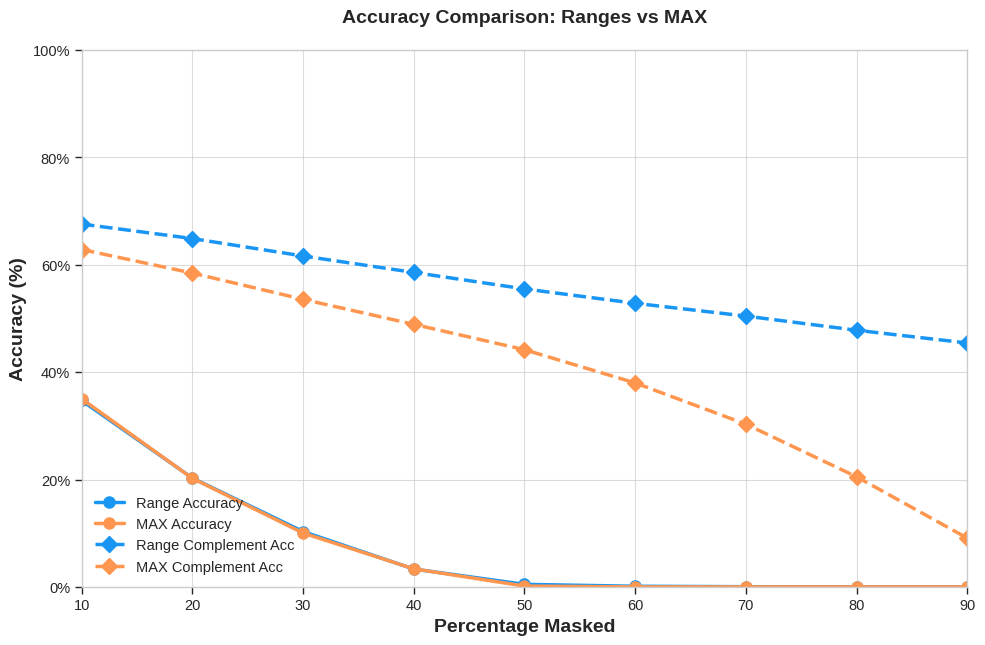

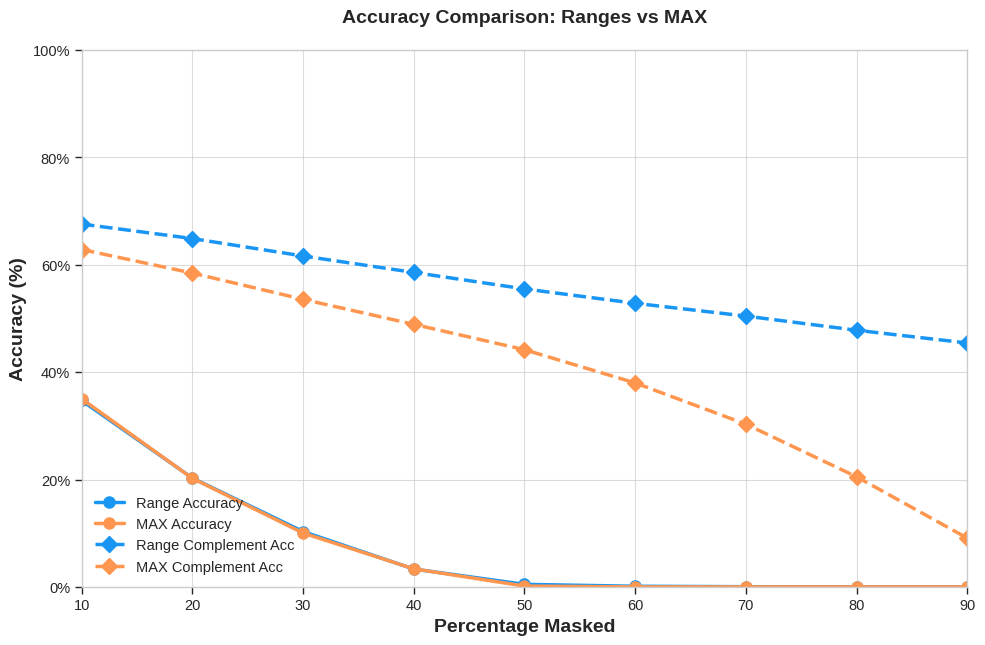

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_accuracy_comparison(df):
    plt.style.use('seaborn-whitegrid')
    sns.set_context("paper", font_scale=1.2)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Color scheme
    # method_colors = {'STD': '#1f77b4', 'MAX': '#ff7f0e'}  # Blue and Orange
    
    
    
    # method_colors = {'STD': '#2ecc71', 'MAX': '#e74c3c'}  # Bright green and red

    # Alternative options:
    # Darker shades:
    # method_colors = {'STD': '#27ae60', 'MAX': '#c0392b'}  

    # # More muted/professional:
    # method_colors = {'STD': '#16a085', 'MAX': '#c0392b'}

    # # Forest green and dark red:
    # method_colors = {'STD': '#006400', 'MAX': '#8b0000'}

    # # Emerald and ruby:
    # method_colors = {'STD': '#50C878', 'MAX': '#E0115F'}
    
    
    rainbow = plt.cm.rainbow
    # Rainbow colormap goes from 0 to 1, where:
    # 0.0 -> violet/purple
    # 0.2 -> blue
    # 0.4 -> green
    # 0.6 -> yellow
    # 0.8 -> orange
    # 1.0 -> red

    # You can get colors like this:
    method_colors = {
        'STD': rainbow(0.2),    # Green
        'MAX': rainbow(0.8)    # Red
}
    
    
    
    
    
    # Plot the data with percentage conversion
    # Main accuracy
    ax.plot(df.index * 100, (df['Base_Acc'] + df['STD_Acc'])*100, 
            color=method_colors['STD'], linestyle='-', marker='o', 
            linewidth=2.5, label='Range Accuracy', markersize=8)
    ax.plot(df.index * 100, (df['Base_Acc'] + df['MAX_Acc'])*100, 
            color=method_colors['MAX'], linestyle='-', marker='o', 
            linewidth=2.5, label='MAX Accuracy', markersize=8)
    
    # Complement accuracy
    ax.plot(df.index * 100, (df['Base_CAcc'] + df['STD_CAcc'])*100, 
            color=method_colors['STD'], linestyle='--', marker='D', 
            linewidth=2.5, label='Range Complement Acc', markersize=8)
    ax.plot(df.index * 100, (df['Base_CAcc'] + df['MAX_CAcc'])*100, 
            color=method_colors['MAX'], linestyle='--', marker='D', 
            linewidth=2.5, label='MAX Complement Acc', markersize=8)
    
    # Customize plot
    ax.set_xlabel('Percentage Masked', fontsize=14, fontweight='bold')
    ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
    ax.set_title('Accuracy Comparison: Ranges vs MAX', fontsize=14, fontweight='bold', pad=20)
    ax.grid(True, linestyle='-', alpha=0.7)
    ax.legend(loc='lower left')
    
    # Set y-axis from 0 to 100
    ax.set_ylim(0, 100)
    ax.set_xlim(10, 90)
    
    # ax.grid(True, which='major', linestyle='-', alpha=0.7)
    # ax.grid(True, which='minor', linestyle=':', alpha=0.4)
    # ax.minorticks_on()
    
    ax.set_xticks(np.arange(10, 91, 10))
    
    # Add percentage signs to y-axis
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))
    
    # Add text explanation
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    
    plt.savefig('accuracy_comparison_Banking_77.pdf', dpi=1200, bbox_inches='tight', format='pdf')
    
    return fig

plot_accuracy_comparison(trimmed_means)

In [17]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def process_percentage_data(input_text):
    # Split into sections by percentage
    sections = input_text.split('Analysis for Percentage:')
    sections = [s.strip() for s in sections if s.strip()]
    
    all_data = []
    
    for section in sections:
        try:
            lines = [line.strip() for line in section.split('\n') if line.strip()]
            
            # Extract percentage from first line
            percentage = float(lines[0])
            
            lines = lines[1:]
            
            # Get rows with class data (between the table borders)
            class_lines = []
            for line in lines:
                # Skip header, border lines, and empty lines
                if (not line.startswith('+-') and 
                    not line.startswith('|  Class  |') and 
                    '|' in line and 
                    'Class' in line):
                    class_lines.append(line)
            
            for line in class_lines:
                parts = line.split('|')
                parts = parts[1:]
                if len(parts) >= 13:
                    try:
                        data_row = {
                            'Percentage': percentage,
                            'Class': parts[0].strip(),
                            'Base_Acc': float(parts[1].strip()),
                            'Base_Conf': float(parts[2].strip()),
                            'Base_CAcc': float(parts[3].strip()),
                            'Base_CConf': float(parts[4].strip()),
                            'STD_Acc': float(parts[5].strip()),
                            'STD_Conf': float(parts[6].strip()),
                            'STD_CAcc': float(parts[7].strip()),
                            'STD_CConf': float(parts[8].strip()),
                            'MAX_Acc': float(parts[9].strip()),
                            'MAX_Conf': float(parts[10].strip()),
                            'MAX_CAcc': float(parts[11].strip()),
                            'MAX_CConf': float(parts[12].strip())
                        }
                        all_data.append(data_row)
                    except ValueError as e:
                        print(f"Warning: Could not parse values in line: {line}")
                        continue
        except (ValueError, IndexError) as e:
            print(f"Warning: Error processing section: {e}")
            continue
    
    if not all_data:
        raise ValueError("No valid data was processed")
        
    df = pd.DataFrame(all_data)
    return df

def calculate_trimmed_means(df):
    # Group by percentage
    grouped = df.groupby('Percentage')
    
    # Calculate trimmed means (20% trimmed - removes 10% from each end)
    trimmed_means = grouped.agg({
        'Base_Acc': lambda x: stats.trim_mean(x, 0.1),
        'Base_Conf': lambda x: stats.trim_mean(x, 0.1),
        'Base_CAcc': lambda x: stats.trim_mean(x, 0.1),
        'Base_CConf': lambda x: stats.trim_mean(x, 0.1),
        'STD_Acc': lambda x: stats.trim_mean(x, 0.1),
        'STD_Conf': lambda x: stats.trim_mean(x, 0.1),
        'STD_CAcc': lambda x: stats.trim_mean(x, 0.1),
        'STD_CConf': lambda x: stats.trim_mean(x, 0.1),
        'MAX_Acc': lambda x: stats.trim_mean(x, 0.1),
        'MAX_Conf': lambda x: stats.trim_mean(x, 0.1),
        'MAX_CAcc': lambda x: stats.trim_mean(x, 0.1),
        'MAX_CConf': lambda x: stats.trim_mean(x, 0.1)
    }).round(4)
    
    trimmed_means['STD_Acc'] = trimmed_means['STD_Acc'].round(4) - trimmed_means['Base_Acc'].round(4)
    trimmed_means['STD_Conf'] = trimmed_means['STD_Conf'].round(4) - trimmed_means['Base_Conf'].round(4)
    trimmed_means['STD_CAcc'] = trimmed_means['STD_CAcc'].round(4) - trimmed_means['Base_CAcc'].round(4)
    trimmed_means['STD_CConf'] = trimmed_means['STD_CConf'].round(4) - trimmed_means['Base_CConf'].round(4)
    trimmed_means['MAX_Acc'] = trimmed_means['MAX_Acc'].round(4) - trimmed_means['Base_Acc'].round(4)
    trimmed_means['MAX_Conf'] = trimmed_means['MAX_Conf'].round(4) - trimmed_means['Base_Conf'].round(4)
    trimmed_means['MAX_CAcc'] = trimmed_means['MAX_CAcc'].round(4) - trimmed_means['Base_CAcc'].round(4)
    trimmed_means['MAX_CConf'] = trimmed_means['MAX_CConf'].round(4) - trimmed_means['Base_CConf'].round(4)
    
    
    return trimmed_means

def plot_direct_comparison(trimmed_means):
    # Set style for professional publication-quality plots
    plt.style.use('seaborn-whitegrid')
    sns.set_context("paper", font_scale=1.2)
    
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Color scheme
    method_colors = {'STD': '#1f77b4', 'MAX': '#ff7f0e'}  # Blue and Orange
    
    # Plot Accuracy metrics (left subplot)
    ax1.plot(trimmed_means.index, trimmed_means['STD_Acc'], 
             color=method_colors['STD'], linestyle='-', marker='o', 
             linewidth=2, label='STD Accuracy', markersize=8)
    ax1.plot(trimmed_means.index, trimmed_means['MAX_Acc'], 
             color=method_colors['MAX'], linestyle='-', marker='o', 
             linewidth=2, label='MAX Accuracy', markersize=8)
    ax1.plot(trimmed_means.index, trimmed_means['STD_CAcc'], 
             color=method_colors['STD'], linestyle='--', marker='^', 
             linewidth=2, label='STD Complement Acc', markersize=8)
    ax1.plot(trimmed_means.index, trimmed_means['MAX_CAcc'], 
             color=method_colors['MAX'], linestyle='--', marker='^', 
             linewidth=2, label='MAX Complement Acc', markersize=8)
    
    # Plot Confidence metrics (right subplot)
    ax2.plot(trimmed_means.index, trimmed_means['STD_Conf'], 
             color=method_colors['STD'], linestyle='-', marker='s', 
             linewidth=2, label='STD Confidence', markersize=8)
    ax2.plot(trimmed_means.index, trimmed_means['MAX_Conf'], 
             color=method_colors['MAX'], linestyle='-', marker='s', 
             linewidth=2, label='MAX Confidence', markersize=8)
    ax2.plot(trimmed_means.index, trimmed_means['STD_CConf'], 
             color=method_colors['STD'], linestyle='--', marker='D', 
             linewidth=2, label='STD Complement Conf', markersize=8)
    ax2.plot(trimmed_means.index, trimmed_means['MAX_CConf'], 
             color=method_colors['MAX'], linestyle='--', marker='D', 
             linewidth=2, label='MAX Complement Conf', markersize=8)
    
    # Customize plots
    titles = ['Accuracy Metrics Comparison', 'Confidence Metrics Comparison']
    for ax, title in zip([ax1, ax2], titles):
        ax.set_xlabel('Percentage', fontsize=12, fontweight='bold')
        ax.set_ylabel('Change from Base', fontsize=12, fontweight='bold')
        ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(loc='lower left', bbox_to_anchor=(0.02, 0.02))
        
        # Add horizontal line at y=0 for reference
        ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
        
        # Set y-axis limits to be symmetric around 0
        max_abs_val = max(abs(min(ax.get_ylim()[0], 0)), abs(max(ax.get_ylim()[1], 0)))
        ax.set_ylim(-max_abs_val * 1.1, max_abs_val * 1.1)
    
    # Add text explanation
    fig.text(0.5, 0.02, 
             'Key Observation: STD (Blue) and MAX (Orange) methods show similar drops in main metrics (solid lines),\n' +
             'but STD maintains stability in complement metrics (dashed lines) while MAX shows exponential degradation',
             ha='center', fontsize=11, style='italic')
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)  # Make room for the text
    
    return fig

def print_trimmed_means_table(trimmed_means):
    # Print header
    print("\nTrimmed Means Analysis (20% trimmed mean)")
    print("-" * 140)
    print(f"{'%':^6} | {'Base Metrics':^40} | {'STD Metrics':^40} | {'MAX Metrics':^40}")
    print(f"{'':6} | {'Acc':^8} {'Conf':^8} {'CAcc':^8} {'CConf':^8} | {'Acc':^8} {'Conf':^8} {'CAcc':^8} {'CConf':^8} | {'Acc':^8} {'Conf':^8} {'CAcc':^8} {'CConf':^8}")
    print("-" * 140)
    
    # Sort by percentage
    sorted_means = trimmed_means.sort_index()
    
    # Print each row
    for idx, row in sorted_means.iterrows():
        print(f"{idx*100:>3.0f}% | "
              f"{row['Base_Acc']:8.3f} {row['Base_Conf']:8.3f} {row['Base_CAcc']:8.3f} {row['Base_CConf']:8.3f} | "
              f"{row['STD_Acc']:8.3f} {row['STD_Conf']:8.3f} {row['STD_CAcc']:8.3f} {row['STD_CConf']:8.3f} | "
              f"{row['MAX_Acc']:8.3f} {row['MAX_Conf']:8.3f} {row['MAX_CAcc']:8.3f} {row['MAX_CConf']:8.3f}")
    print("-" * 140)

def generate_latex_table(trimmed_means):
    latex_table = r"""\begin{table}[h]
\centering
\scriptsize
\begin{tabular}{c|cccc|cccc|cccc}
\toprule
& \multicolumn{4}{c|}{Base Metrics} & \multicolumn{4}{c|}{STD Metrics} & \multicolumn{4}{c}{MAX Metrics} \\
\cmidrule(r){2-5} \cmidrule(r){6-9} \cmidrule{10-13}
\% & Acc & Conf & CAcc & CConf & Acc & Conf & CAcc & CConf & Acc & Conf & CAcc & CConf \\
\midrule"""

    # Sort by percentage
    sorted_means = trimmed_means.sort_index()
    
    for idx, row in sorted_means.iterrows():
        latex_table += f"\n{int(idx*100)} & {row['Base_Acc']:.3f} & {row['Base_Conf']:.3f} & {row['Base_CAcc']:.3f} & {row['Base_CConf']:.3f} & {row['STD_Acc']:.3f} & {row['STD_Conf']:.3f} & {row['STD_CAcc']:.3f} & {row['STD_CConf']:.3f} & {row['MAX_Acc']:.3f} & {row['MAX_Conf']:.3f} & {row['MAX_CAcc']:.3f} & {row['MAX_CConf']:.3f} \\\\"

    latex_table += r"""
\bottomrule
\end{tabular}
\caption{Performance metrics across different ablation percentages (20\% trimmed means)}
\label{tab:ablation_results}
\end{table}"""

    return latex_table

# Example usage:
if __name__ == "__main__":
    # Read the input text
    input_text = '''
Analysis for Percentage: 0.10
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
|  Class  | Base Accuracy | Base Confidence | Base Complement Acc | Base Compliment Conf | STD Accuracy | STD Confidence | STD compliment ACC | STD compliment Conf | MAX Accuracy | MAX Confidence | Max compliment acc | Max compliment conf | Total Masked | Intersection |
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
| Class 0 |     0.9683    |      0.9629     |        0.9622       |        0.9468        |    0.9536    |     0.9534     |       0.9213       |        0.9189       |    0.955     |     0.9548     |       0.8477       |        0.8476       |      76      |     768      |
| Class 1 |     0.9927    |      0.9885     |        0.9539       |        0.9381        |     0.98     |     0.9794     |       0.9319       |        0.9261       |    0.9833    |     0.9818     |       0.7713       |        0.7725       |      76      |     768      |
| Class 2 |     0.9336    |      0.9148     |        0.9735       |        0.9626        |    0.9288    |     0.9257     |       0.953        |        0.9508       |    0.9312    |     0.9278     |       0.9545       |        0.9528       |      76      |     768      |
| Class 3 |     0.9594    |      0.9361     |        0.9652       |        0.9558        |    0.0976    |     0.0976     |       0.9844       |        0.9809       |    0.0788    |     0.0794     |       0.9843       |        0.9839       |      76      |     768      |
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+



Analysis for Percentage: 0.20
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
|  Class  | Base Accuracy | Base Confidence | Base Complement Acc | Base Compliment Conf | STD Accuracy | STD Confidence | STD compliment ACC | STD compliment Conf | MAX Accuracy | MAX Confidence | Max compliment acc | Max compliment conf | Total Masked | Intersection |
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
| Class 0 |     0.9683    |      0.9629     |        0.9622       |        0.9468        |    0.9187    |     0.9119     |       0.9193       |        0.9172       |    0.9208    |     0.9163     |       0.8137       |        0.8143       |     153      |     768      |
| Class 1 |     0.9927    |      0.9885     |        0.9539       |        0.9381        |    0.9463    |     0.9408     |       0.9283       |        0.9199       |    0.9484    |     0.9467     |       0.6548       |        0.6551       |     153      |     768      |
| Class 2 |     0.9336    |      0.9148     |        0.9735       |        0.9626        |    0.8958    |     0.8879     |       0.8899       |        0.8831       |    0.9009    |     0.8969     |       0.862        |        0.8579       |     153      |     768      |
| Class 3 |     0.9594    |      0.9361     |        0.9652       |        0.9558        |    0.0874    |     0.0871     |       0.9734       |        0.9477       |    0.0515    |     0.0558     |       0.9747       |        0.9741       |     153      |     768      |
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+



Analysis for Percentage: 0.30
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
|  Class  | Base Accuracy | Base Confidence | Base Complement Acc | Base Compliment Conf | STD Accuracy | STD Confidence | STD compliment ACC | STD compliment Conf | MAX Accuracy | MAX Confidence | Max compliment acc | Max compliment conf | Total Masked | Intersection |
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
| Class 0 |     0.9683    |      0.9629     |        0.9622       |        0.9468        |    0.7859    |     0.7368     |       0.9291       |        0.9272       |    0.7913    |     0.7571     |       0.8217       |        0.8216       |     230      |     768      |
| Class 1 |     0.9927    |      0.9885     |        0.9539       |        0.9381        |    0.8455    |     0.8187     |       0.9208       |        0.9067       |    0.8471    |     0.8202     |       0.6596       |        0.6595       |     230      |     768      |
| Class 2 |     0.9336    |      0.9148     |        0.9735       |        0.9626        |    0.7914    |     0.7742     |       0.9529       |        0.9149       |    0.7943    |     0.778      |       0.9531       |        0.9492       |     230      |     768      |
| Class 3 |     0.9594    |      0.9361     |        0.9652       |        0.9558        |    0.0788    |     0.071      |        0.97        |        0.8255       |    0.0281    |     0.0282     |       0.9767       |        0.9739       |     230      |     768      |
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+



Analysis for Percentage: 0.40
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
|  Class  | Base Accuracy | Base Confidence | Base Complement Acc | Base Compliment Conf | STD Accuracy | STD Confidence | STD compliment ACC | STD compliment Conf | MAX Accuracy | MAX Confidence | Max compliment acc | Max compliment conf | Total Masked | Intersection |
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
| Class 0 |     0.9683    |      0.9629     |        0.9622       |        0.9468        |    0.2409    |     0.1963     |       0.9271       |        0.9244       |    0.2505    |     0.2014     |       0.7209       |        0.7154       |     307      |     768      |
| Class 1 |     0.9927    |      0.9885     |        0.9539       |        0.9381        |    0.3497    |     0.3074     |       0.905        |        0.8854       |    0.3392    |     0.2936     |       0.6855       |        0.6841       |     307      |     768      |
| Class 2 |     0.9336    |      0.9148     |        0.9735       |        0.9626        |    0.5792    |     0.5193     |       0.9091       |        0.7641       |    0.5758    |     0.5116     |       0.8557       |        0.8288       |     307      |     768      |
| Class 3 |     0.9594    |      0.9361     |        0.9652       |        0.9558        |    0.052     |     0.0367     |       0.9504       |        0.5975       |    0.0012    |     0.0016     |       0.9477       |        0.9338       |     307      |     768      |
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+



Analysis for Percentage: 0.50
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
|  Class  | Base Accuracy | Base Confidence | Base Complement Acc | Base Compliment Conf | STD Accuracy | STD Confidence | STD compliment ACC | STD compliment Conf | MAX Accuracy | MAX Confidence | Max compliment acc | Max compliment conf | Total Masked | Intersection |
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
| Class 0 |     0.9683    |      0.9629     |        0.9622       |        0.9468        |    0.0375    |     0.0294     |       0.9331       |        0.9301       |    0.0408    |     0.0281     |       0.7107       |        0.7057       |     384      |     768      |
| Class 1 |     0.9927    |      0.9885     |        0.9539       |        0.9381        |    0.0689    |     0.0574     |       0.8935       |        0.8644       |    0.0499    |     0.043      |       0.6838       |        0.6681       |     384      |     768      |
| Class 2 |     0.9336    |      0.9148     |        0.9735       |        0.9626        |    0.2086    |     0.1591     |       0.8755       |        0.6463       |    0.1958    |     0.1479     |       0.8526       |        0.8214       |     384      |     768      |
| Class 3 |     0.9594    |      0.9361     |        0.9652       |        0.9558        |    0.0517    |     0.031      |       0.8764       |        0.4267       |     0.0      |      0.0       |       0.9344       |        0.9126       |     384      |     768      |
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+


Analysis for Percentage: 0.60
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
|  Class  | Base Accuracy | Base Confidence | Base Complement Acc | Base Compliment Conf | STD Accuracy | STD Confidence | STD compliment ACC | STD compliment Conf | MAX Accuracy | MAX Confidence | Max compliment acc | Max compliment conf | Total Masked | Intersection |
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
| Class 0 |     0.9683    |      0.9629     |        0.9622       |        0.9468        |    0.0144    |     0.009      |       0.9408       |        0.9358       |    0.0144    |     0.0084     |       0.7198       |        0.7091       |     460      |     768      |
| Class 1 |     0.9927    |      0.9885     |        0.9539       |        0.9381        |    0.0098    |     0.009      |       0.8842       |        0.8498       |    0.0039    |     0.0043     |       0.6463       |        0.6224       |     460      |     768      |
| Class 2 |     0.9336    |      0.9148     |        0.9735       |        0.9626        |    0.0209    |     0.016      |        0.8         |        0.5774       |    0.0174    |     0.0128     |       0.8242       |        0.7849       |     460      |     768      |
| Class 3 |     0.9594    |      0.9361     |        0.9652       |        0.9558        |    0.054     |     0.0305     |       0.7518       |        0.3456       |     0.0      |      0.0       |       0.9109       |        0.8716       |     460      |     768      |
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+



Analysis for Percentage: 0.70
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
|  Class  | Base Accuracy | Base Confidence | Base Complement Acc | Base Compliment Conf | STD Accuracy | STD Confidence | STD compliment ACC | STD compliment Conf | MAX Accuracy | MAX Confidence | Max compliment acc | Max compliment conf | Total Masked | Intersection |
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
| Class 0 |     0.9683    |      0.9629     |        0.9622       |        0.9468        |    0.0058    |     0.0038     |       0.9441       |        0.9383       |    0.0088    |     0.0057     |       0.8237       |        0.7756       |     537      |     768      |
| Class 1 |     0.9927    |      0.9885     |        0.9539       |        0.9381        |    0.0005    |     0.0005     |       0.8555       |        0.8204       |     0.0      |     0.0001     |       0.6939       |        0.5852       |     537      |     768      |
| Class 2 |     0.9336    |      0.9148     |        0.9735       |        0.9626        |    0.0016    |     0.0015     |       0.5788       |        0.4713       |    0.0003    |     0.0008     |       0.6071       |        0.5795       |     537      |     768      |
| Class 3 |     0.9594    |      0.9361     |        0.9652       |        0.9558        |    0.0576    |     0.033      |       0.4904       |        0.2489       |     0.0      |      0.0       |       0.7436       |        0.6671       |     537      |     768      |
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+



Analysis for Percentage: 0.80
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
|  Class  | Base Accuracy | Base Confidence | Base Complement Acc | Base Compliment Conf | STD Accuracy | STD Confidence | STD compliment ACC | STD compliment Conf | MAX Accuracy | MAX Confidence | Max compliment acc | Max compliment conf | Total Masked | Intersection |
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
| Class 0 |     0.9683    |      0.9629     |        0.9622       |        0.9468        |     0.0      |     0.0003     |       0.921        |        0.9071       |     0.0      |      0.0       |       0.4362       |        0.3682       |     614      |     768      |
| Class 1 |     0.9927    |      0.9885     |        0.9539       |        0.9381        |    0.0003    |     0.0003     |       0.8422       |        0.8078       |     0.0      |      0.0       |       0.6618       |        0.5614       |     614      |     768      |
| Class 2 |     0.9336    |      0.9148     |        0.9735       |        0.9626        |     0.0      |     0.0001     |       0.541        |        0.4444       |     0.0      |      0.0       |       0.4086       |        0.3281       |     614      |     768      |
| Class 3 |     0.9594    |      0.9361     |        0.9652       |        0.9558        |    0.0621    |     0.0352     |       0.3383       |        0.2118       |     0.0      |     0.0001     |       0.5123       |        0.4467       |     614      |     768      |
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+



Analysis for Percentage: 0.90
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
|  Class  | Base Accuracy | Base Confidence | Base Complement Acc | Base Compliment Conf | STD Accuracy | STD Confidence | STD compliment ACC | STD compliment Conf | MAX Accuracy | MAX Confidence | Max compliment acc | Max compliment conf | Total Masked | Intersection |
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
| Class 0 |     0.9683    |      0.9629     |        0.9622       |        0.9468        |    0.0005    |     0.0004     |       0.8963       |        0.8755       |     0.0      |      0.0       |       0.0284       |        0.0234       |     691      |     768      |
| Class 1 |     0.9927    |      0.9885     |        0.9539       |        0.9381        |    0.0006    |     0.0006     |       0.8115       |        0.7828       |     0.0      |      0.0       |       0.0106       |        0.0089       |     691      |     768      |
| Class 2 |     0.9336    |      0.9148     |        0.9735       |        0.9626        |     0.0      |     0.0001     |       0.4924       |        0.4201       |     0.0      |      0.0       |       0.0888       |        0.0666       |     691      |     768      |
| Class 3 |     0.9594    |      0.9361     |        0.9652       |        0.9558        |    0.0731    |     0.045      |       0.2201       |        0.1532       |    0.0005    |     0.0004     |       0.0426       |        0.0302       |     691      |     768      |
+---------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
'''
    
    # Process the data
    df = process_percentage_data(input_text)
    
    # Calculate trimmed means for each percentage
    trimmed_means = calculate_trimmed_means(df)
    
    # plot_direct_comparison(trimmed_means)
    
    # Generate LaTeX table
    latex_table = generate_latex_table(trimmed_means)
    
    # Print the LaTeX table
    print(latex_table)
    
    # Also save as CSV for easy viewing
    trimmed_means.round(4).to_csv('trimmed_means.csv')

\begin{table}[h]
\centering
\scriptsize
\begin{tabular}{c|cccc|cccc|cccc}
\toprule
& \multicolumn{4}{c|}{Base Metrics} & \multicolumn{4}{c|}{STD Metrics} & \multicolumn{4}{c}{MAX Metrics} \\
\cmidrule(r){2-5} \cmidrule(r){6-9} \cmidrule{10-13}
\% & Acc & Conf & CAcc & CConf & Acc & Conf & CAcc & CConf & Acc & Conf & CAcc & CConf \\
\midrule
10 & 0.964 & 0.951 & 0.964 & 0.951 & -0.224 & -0.212 & -0.016 & -0.007 & -0.226 & -0.215 & -0.074 & -0.062 \\
20 & 0.964 & 0.951 & 0.964 & 0.951 & -0.252 & -0.244 & -0.036 & -0.034 & -0.258 & -0.247 & -0.137 & -0.125 \\
30 & 0.964 & 0.951 & 0.964 & 0.951 & -0.338 & -0.350 & -0.020 & -0.057 & -0.348 & -0.355 & -0.111 & -0.100 \\
40 & 0.964 & 0.951 & 0.964 & 0.951 & -0.658 & -0.686 & -0.041 & -0.158 & -0.672 & -0.699 & -0.161 & -0.160 \\
50 & 0.964 & 0.951 & 0.964 & 0.951 & -0.872 & -0.881 & -0.069 & -0.234 & -0.892 & -0.896 & -0.168 & -0.174 \\
60 & 0.964 & 0.951 & 0.964 & 0.951 & -0.939 & -0.934 & -0.120 & -0.274 & -0.955 & -0.944 & -0.188 & -0.204 

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def process_percentage_data(input_text):
    # Split into sections by percentage
    sections = input_text.split('Analysis for Percentage:')
    sections = [s.strip() for s in sections if s.strip()]
    
    all_data = []
    
    for section in sections:
        try:
            lines = [line.strip() for line in section.split('\n') if line.strip()]
            
            # Extract percentage from first line
            percentage = float(lines[0])
            
            lines = lines[1:]
            
            # Get rows with class data (between the table borders)
            class_lines = []
            for line in lines:
                # Skip header, border lines, and empty lines
                if (not line.startswith('+-') and 
                    not line.startswith('|  Class  |') and 
                    '|' in line and 
                    'Class' in line):
                    class_lines.append(line)
            
            for line in class_lines:
                parts = line.split('|')
                parts = parts[1:]
                if len(parts) >= 13:
                    try:
                        data_row = {
                            'Percentage': percentage,
                            'Class': parts[0].strip(),
                            'Base_Acc': float(parts[1].strip()),
                            'Base_Conf': float(parts[2].strip()),
                            'Base_CAcc': float(parts[3].strip()),
                            'Base_CConf': float(parts[4].strip()),
                            'STD_Acc': float(parts[5].strip()),
                            'STD_Conf': float(parts[6].strip()),
                            'STD_CAcc': float(parts[7].strip()),
                            'STD_CConf': float(parts[8].strip()),
                            'MAX_Acc': float(parts[9].strip()),
                            'MAX_Conf': float(parts[10].strip()),
                            'MAX_CAcc': float(parts[11].strip()),
                            'MAX_CConf': float(parts[12].strip())
                        }
                        all_data.append(data_row)
                    except ValueError as e:
                        print(f"Warning: Could not parse values in line: {line}")
                        continue
        except (ValueError, IndexError) as e:
            print(f"Warning: Error processing section: {e}")
            continue
    
    if not all_data:
        raise ValueError("No valid data was processed")
        
    df = pd.DataFrame(all_data)
    return df

def calculate_trimmed_means(df):
    # Group by percentage
    grouped = df.groupby('Percentage')
    
    # Calculate trimmed means (20% trimmed - removes 10% from each end)
    trimmed_means = grouped.agg({
        'Base_Acc': lambda x: stats.trim_mean(x, 0.1),
        'Base_Conf': lambda x: stats.trim_mean(x, 0.1),
        'Base_CAcc': lambda x: stats.trim_mean(x, 0.1),
        'Base_CConf': lambda x: stats.trim_mean(x, 0.1),
        'STD_Acc': lambda x: stats.trim_mean(x, 0.1),
        'STD_Conf': lambda x: stats.trim_mean(x, 0.1),
        'STD_CAcc': lambda x: stats.trim_mean(x, 0.1),
        'STD_CConf': lambda x: stats.trim_mean(x, 0.1),
        'MAX_Acc': lambda x: stats.trim_mean(x, 0.1),
        'MAX_Conf': lambda x: stats.trim_mean(x, 0.1),
        'MAX_CAcc': lambda x: stats.trim_mean(x, 0.1),
        'MAX_CConf': lambda x: stats.trim_mean(x, 0.1)
    }).round(4)
    
    trimmed_means['STD_Acc'] = trimmed_means['STD_Acc'].round(4) - trimmed_means['Base_Acc'].round(4)
    trimmed_means['STD_Conf'] = trimmed_means['STD_Conf'].round(4) - trimmed_means['Base_Conf'].round(4)
    trimmed_means['STD_CAcc'] = trimmed_means['STD_CAcc'].round(4) - trimmed_means['Base_CAcc'].round(4)
    trimmed_means['STD_CConf'] = trimmed_means['STD_CConf'].round(4) - trimmed_means['Base_CConf'].round(4)
    trimmed_means['MAX_Acc'] = trimmed_means['MAX_Acc'].round(4) - trimmed_means['Base_Acc'].round(4)
    trimmed_means['MAX_Conf'] = trimmed_means['MAX_Conf'].round(4) - trimmed_means['Base_Conf'].round(4)
    trimmed_means['MAX_CAcc'] = trimmed_means['MAX_CAcc'].round(4) - trimmed_means['Base_CAcc'].round(4)
    trimmed_means['MAX_CConf'] = trimmed_means['MAX_CConf'].round(4) - trimmed_means['Base_CConf'].round(4)
    
    
    return trimmed_means

def plot_direct_comparison(trimmed_means):
    # Set style for professional publication-quality plots
    plt.style.use('seaborn-whitegrid')
    sns.set_context("paper", font_scale=1.2)
    
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Color scheme
    method_colors = {'STD': '#1f77b4', 'MAX': '#ff7f0e'}  # Blue and Orange
    
    # Plot Accuracy metrics (left subplot)
    ax1.plot(trimmed_means.index, trimmed_means['STD_Acc'], 
             color=method_colors['STD'], linestyle='-', marker='o', 
             linewidth=2, label='STD Accuracy', markersize=8)
    ax1.plot(trimmed_means.index, trimmed_means['MAX_Acc'], 
             color=method_colors['MAX'], linestyle='-', marker='o', 
             linewidth=2, label='MAX Accuracy', markersize=8)
    ax1.plot(trimmed_means.index, trimmed_means['STD_CAcc'], 
             color=method_colors['STD'], linestyle='--', marker='^', 
             linewidth=2, label='STD Complement Acc', markersize=8)
    ax1.plot(trimmed_means.index, trimmed_means['MAX_CAcc'], 
             color=method_colors['MAX'], linestyle='--', marker='^', 
             linewidth=2, label='MAX Complement Acc', markersize=8)
    
    # Plot Confidence metrics (right subplot)
    ax2.plot(trimmed_means.index, trimmed_means['STD_Conf'], 
             color=method_colors['STD'], linestyle='-', marker='s', 
             linewidth=2, label='STD Confidence', markersize=8)
    ax2.plot(trimmed_means.index, trimmed_means['MAX_Conf'], 
             color=method_colors['MAX'], linestyle='-', marker='s', 
             linewidth=2, label='MAX Confidence', markersize=8)
    ax2.plot(trimmed_means.index, trimmed_means['STD_CConf'], 
             color=method_colors['STD'], linestyle='--', marker='D', 
             linewidth=2, label='STD Complement Conf', markersize=8)
    ax2.plot(trimmed_means.index, trimmed_means['MAX_CConf'], 
             color=method_colors['MAX'], linestyle='--', marker='D', 
             linewidth=2, label='MAX Complement Conf', markersize=8)
    
    # Customize plots
    titles = ['Accuracy Metrics Comparison', 'Confidence Metrics Comparison']
    for ax, title in zip([ax1, ax2], titles):
        ax.set_xlabel('Percentage', fontsize=12, fontweight='bold')
        ax.set_ylabel('Change from Base', fontsize=12, fontweight='bold')
        ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(loc='lower left', bbox_to_anchor=(0.02, 0.02))
        
        # Add horizontal line at y=0 for reference
        ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
        
        # Set y-axis limits to be symmetric around 0
        max_abs_val = max(abs(min(ax.get_ylim()[0], 0)), abs(max(ax.get_ylim()[1], 0)))
        ax.set_ylim(-max_abs_val * 1.1, max_abs_val * 1.1)
    
    # Add text explanation
    fig.text(0.5, 0.02, 
             'Key Observation: STD (Blue) and MAX (Orange) methods show similar drops in main metrics (solid lines),\n' +
             'but STD maintains stability in complement metrics (dashed lines) while MAX shows exponential degradation',
             ha='center', fontsize=11, style='italic')
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)  # Make room for the text
    
    return fig

def print_trimmed_means_table(trimmed_means):
    # Print header
    print("\nTrimmed Means Analysis (20% trimmed mean)")
    print("-" * 140)
    print(f"{'%':^6} | {'Base Metrics':^40} | {'STD Metrics':^40} | {'MAX Metrics':^40}")
    print(f"{'':6} | {'Acc':^8} {'Conf':^8} {'CAcc':^8} {'CConf':^8} | {'Acc':^8} {'Conf':^8} {'CAcc':^8} {'CConf':^8} | {'Acc':^8} {'Conf':^8} {'CAcc':^8} {'CConf':^8}")
    print("-" * 140)
    
    # Sort by percentage
    sorted_means = trimmed_means.sort_index()
    
    # Print each row
    for idx, row in sorted_means.iterrows():
        print(f"{idx*100:>3.0f}% | "
              f"{row['Base_Acc']:8.3f} {row['Base_Conf']:8.3f} {row['Base_CAcc']:8.3f} {row['Base_CConf']:8.3f} | "
              f"{row['STD_Acc']:8.3f} {row['STD_Conf']:8.3f} {row['STD_CAcc']:8.3f} {row['STD_CConf']:8.3f} | "
              f"{row['MAX_Acc']:8.3f} {row['MAX_Conf']:8.3f} {row['MAX_CAcc']:8.3f} {row['MAX_CConf']:8.3f}")
    print("-" * 140)

def generate_latex_table(trimmed_means):
    latex_table = r"""\begin{table}[h]
\centering
\scriptsize
\begin{tabular}{c|cccc|cccc|cccc}
\toprule
& \multicolumn{4}{c|}{Base Metrics} & \multicolumn{4}{c|}{STD Metrics} & \multicolumn{4}{c}{MAX Metrics} \\
\cmidrule(r){2-5} \cmidrule(r){6-9} \cmidrule{10-13}
\% & Acc & Conf & CAcc & CConf & Acc & Conf & CAcc & CConf & Acc & Conf & CAcc & CConf \\
\midrule"""

    # Sort by percentage
    sorted_means = trimmed_means.sort_index()
    
    for idx, row in sorted_means.iterrows():
        latex_table += f"\n{int(idx*100)} & {row['Base_Acc']:.3f} & {row['Base_Conf']:.3f} & {row['Base_CAcc']:.3f} & {row['Base_CConf']:.3f} & {row['STD_Acc']:.3f} & {row['STD_Conf']:.3f} & {row['STD_CAcc']:.3f} & {row['STD_CConf']:.3f} & {row['MAX_Acc']:.3f} & {row['MAX_Conf']:.3f} & {row['MAX_CAcc']:.3f} & {row['MAX_CConf']:.3f} \\\\"

    latex_table += r"""
\bottomrule
\end{tabular}
\caption{Performance metrics across different ablation percentages (20\% trimmed means)}
\label{tab:ablation_results}
\end{table}"""

    return latex_table

# Example usage:
if __name__ == "__main__":
    # Read the input text
    input_text = '''
Analysis for Percentage: 0.10
+----------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
|  Class   | Base Accuracy | Base Confidence | Base Complement Acc | Base Compliment Conf | STD Accuracy | STD Confidence | STD compliment ACC | STD compliment Conf | MAX Accuracy | MAX Confidence | Max compliment acc | Max compliment conf | Total Masked | Intersection |
+----------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
| Class 0  |     0.975     |      0.8305     |        0.7375       |        0.5183        |     0.65     |     0.2111     |       0.6951       |        0.451        |     0.65     |     0.2112     |       0.674        |        0.4147       |      76      |     768      |
| Class 1  |     0.925     |      0.704      |        0.7382       |        0.5199        |    0.425     |     0.0694     |       0.6016       |        0.3603       |    0.425     |     0.0669     |       0.5865       |        0.2778       |      76      |     768      |
| Class 2  |      0.9      |      0.6054     |        0.7385       |        0.5212        |    0.125     |     0.0617     |       0.6484       |        0.4371       |    0.125     |     0.063      |       0.6326       |        0.4031       |      76      |     768      |
| Class 3  |      0.8      |      0.4659     |        0.7398       |        0.5231        |    0.425     |     0.1463     |       0.6947       |        0.457        |    0.425     |     0.1465     |       0.6513       |        0.3832       |      76      |     768      |
| Class 4  |      0.85     |      0.6341     |        0.7391       |        0.5209        |    0.525     |     0.1732     |       0.6503       |        0.4227       |    0.525     |     0.1716     |       0.6161       |        0.3709       |      76      |     768      |
| Class 5  |      0.75     |      0.3956     |        0.7405       |        0.524         |    0.525     |     0.188      |       0.7086       |        0.4663       |    0.525     |     0.1915     |       0.6286       |        0.3522       |      76      |     768      |
| Class 6  |     0.925     |      0.6937     |        0.7382       |        0.5201        |     0.15     |     0.0692     |       0.6786       |        0.4425       |     0.15     |     0.0691     |       0.6194       |        0.3448       |      76      |     768      |
| Class 7  |      0.75     |      0.4664     |        0.7405       |        0.5231        |     0.75     |     0.2193     |       0.7059       |        0.4644       |    0.725     |     0.2181     |       0.678        |        0.4016       |      76      |     768      |
| Class 8  |      0.75     |      0.5969     |        0.7405       |        0.5214        |     0.7      |     0.1798     |        0.7         |        0.4688       |     0.7      |     0.1828     |       0.6829       |        0.4283       |      76      |     768      |
| Class 9  |      0.85     |      0.6836     |        0.7391       |        0.5202        |    0.675     |     0.2557     |       0.6622       |        0.4232       |    0.725     |     0.2659     |       0.6303       |        0.3723       |      76      |     768      |
| Class 10 |      0.15     |      0.0906     |        0.7484       |        0.528         |     0.0      |     0.0132     |       0.6918       |        0.4336       |     0.0      |     0.0136     |       0.6375       |        0.3701       |      76      |     768      |
| Class 11 |      0.85     |      0.441      |        0.7391       |        0.5234        |     0.15     |     0.0972     |       0.6937       |        0.4496       |    0.125     |     0.0959     |       0.5931       |        0.3212       |      76      |     768      |
| Class 12 |     0.825     |      0.3573     |        0.7395       |        0.5245        |    0.725     |     0.2586     |       0.6997       |        0.4654       |    0.675     |     0.2633     |       0.6658       |        0.4096       |      76      |     768      |
| Class 13 |      0.9      |      0.4944     |        0.7385       |        0.5227        |     0.7      |     0.1437     |       0.6556       |        0.4183       |     0.7      |     0.1423     |       0.5727       |        0.324        |      76      |     768      |
| Class 14 |     0.475     |      0.2136     |        0.7441       |        0.5264        |    0.075     |     0.0475     |       0.6691       |        0.4315       |    0.075     |     0.0478     |       0.5836       |        0.3281       |      76      |     768      |
| Class 15 |     0.875     |      0.7187     |        0.7388       |        0.5197        |     0.45     |     0.2522     |       0.7023       |        0.4442       |     0.45     |     0.2478     |       0.6424       |        0.3816       |      76      |     768      |
| Class 16 |      0.65     |      0.4412     |        0.7418       |        0.5234        |    0.125     |     0.0515     |       0.6095       |        0.3882       |    0.125     |     0.0518     |       0.602        |        0.3301       |      76      |     768      |
| Class 17 |     0.925     |      0.7025     |        0.7382       |         0.52         |    0.475     |     0.1486     |       0.6868       |        0.4545       |    0.475     |     0.1489     |       0.6237       |        0.3401       |      76      |     768      |
| Class 18 |     0.275     |      0.1513     |        0.7467       |        0.5272        |     0.0      |     0.0286     |       0.7164       |        0.4945       |     0.0      |     0.0279     |       0.6773       |        0.4423       |      76      |     768      |
| Class 19 |      0.9      |      0.7076     |        0.7385       |        0.5199        |     0.1      |     0.0712     |       0.6191       |        0.3857       |    0.175     |     0.0697     |       0.6181       |        0.3291       |      76      |     768      |
| Class 20 |      0.75     |      0.4396     |        0.7405       |        0.5234        |     0.2      |     0.0905     |       0.6908       |        0.435        |     0.2      |     0.0933     |       0.6553       |        0.3828       |      76      |     768      |
| Class 21 |      0.75     |      0.521      |        0.7405       |        0.5224        |     0.65     |     0.2665     |       0.6852       |        0.4528       |     0.65     |     0.2683     |       0.627        |        0.3639       |      76      |     768      |
| Class 22 |      0.3      |      0.1693     |        0.7464       |        0.527         |     0.1      |     0.054      |       0.7033       |        0.4982       |     0.1      |     0.0552     |       0.6786       |        0.453        |      76      |     768      |
| Class 23 |     0.175     |      0.0831     |        0.748        |        0.5281        |     0.0      |     0.0107     |       0.7013       |        0.4761       |     0.0      |     0.0118     |       0.6382       |        0.407        |      76      |     768      |
| Class 24 |     0.875     |      0.4989     |        0.7388       |        0.5226        |     0.35     |     0.1051     |       0.6862       |        0.4482       |     0.4      |     0.1073     |       0.6168       |        0.3633       |      76      |     768      |
| Class 25 |     0.925     |      0.5121     |        0.7382       |        0.5225        |    0.675     |     0.2055     |       0.6674       |        0.4303       |     0.7      |     0.2062     |       0.6296       |        0.3787       |      76      |     768      |
| Class 26 |      0.75     |      0.5129     |        0.7405       |        0.5225        |     0.05     |     0.0507     |       0.6553       |        0.4266       |     0.05     |     0.0507     |       0.6405       |        0.3625       |      76      |     768      |
| Class 27 |     0.675     |      0.5259     |        0.7414       |        0.5223        |    0.575     |     0.2879     |       0.7122       |        0.4782       |    0.575     |     0.287      |       0.6332       |        0.3704       |      76      |     768      |
| Class 28 |      0.75     |      0.6663     |        0.7405       |        0.5204        |    0.325     |     0.0753     |       0.6961       |        0.4469       |     0.3      |     0.0735     |       0.6243       |        0.3444       |      76      |     768      |
| Class 29 |     0.825     |      0.7133     |        0.7395       |        0.5198        |    0.675     |     0.2254     |       0.7007       |        0.4317       |     0.7      |     0.2254     |       0.6303       |        0.3355       |      76      |     768      |
| Class 30 |      1.0      |      0.5551     |        0.7372       |        0.5219        |    0.875     |     0.2108     |       0.6813       |        0.4346       |    0.975     |     0.2074     |       0.6013       |        0.3284       |      76      |     768      |
| Class 31 |     0.825     |      0.6389     |        0.7395       |        0.5208        |    0.125     |     0.0869     |       0.6684       |        0.4336       |    0.125     |     0.0845     |       0.6174       |        0.3658       |      76      |     768      |
| Class 32 |      0.9      |      0.8102     |        0.7385       |        0.5185        |     0.6      |     0.2475     |       0.6911       |        0.4431       |     0.6      |     0.247      |       0.6622       |        0.343        |      76      |     768      |
| Class 33 |      0.8      |      0.464      |        0.7398       |        0.5231        |     0.4      |     0.1659     |       0.6875       |        0.4679       |     0.4      |     0.168      |       0.6464       |        0.3967       |      76      |     768      |
| Class 34 |      0.95     |      0.6332     |        0.7378       |        0.5209        |     0.4      |     0.1321     |       0.6151       |        0.3746       |    0.425     |     0.1336     |       0.5635       |        0.2947       |      76      |     768      |
| Class 35 |      0.8      |      0.3679     |        0.7398       |        0.5244        |     0.15     |     0.1012     |       0.6957       |        0.4698       |     0.15     |     0.102      |       0.6434       |        0.377        |      76      |     768      |
| Class 36 |     0.775     |      0.4874     |        0.7401       |        0.5228        |     0.2      |     0.1157     |       0.7105       |        0.4756       |     0.2      |     0.1135     |       0.6737       |        0.3889       |      76      |     768      |
| Class 37 |      0.7      |      0.4923     |        0.7411       |        0.5227        |     0.75     |     0.428      |       0.703        |        0.4358       |     0.75     |     0.4332     |       0.6293       |        0.3443       |      76      |     768      |
| Class 38 |     0.675     |      0.4688     |        0.7414       |        0.523         |     0.0      |     0.0851     |       0.6632       |        0.417        |     0.0      |     0.0853     |       0.6289       |        0.3323       |      76      |     768      |
| Class 39 |     0.875     |      0.3669     |        0.7388       |        0.5244        |    0.075     |     0.0331     |       0.653        |        0.3934       |     0.05     |     0.0342     |       0.5984       |        0.3171       |      76      |     768      |
| Class 40 |      1.0      |      0.8456     |        0.7372       |        0.5181        |     0.7      |     0.2056     |       0.6793       |        0.4475       |     0.7      |     0.1978     |       0.6641       |        0.4075       |      76      |     768      |
| Class 41 |     0.675     |      0.2845     |        0.7414       |        0.5255        |    0.025     |     0.0244     |       0.7155       |        0.4952       |    0.025     |     0.0253     |       0.6477       |        0.3973       |      76      |     768      |
| Class 42 |      0.9      |      0.493      |        0.7385       |        0.5227        |     0.25     |     0.054      |       0.6507       |        0.4155       |     0.25     |     0.0486     |       0.622        |        0.3367       |      76      |     768      |
| Class 43 |      0.7      |      0.3753     |        0.7411       |        0.5243        |    0.125     |     0.039      |       0.6859       |        0.4479       |    0.125     |     0.0375     |       0.6628       |        0.4065       |      76      |     768      |
| Class 44 |     0.975     |      0.8215     |        0.7375       |        0.5184        |     0.1      |     0.0597     |       0.6928       |        0.4577       |     0.1      |     0.0583     |       0.6684       |        0.4091       |      76      |     768      |
| Class 45 |      0.75     |      0.5717     |        0.7405       |        0.5217        |    0.625     |     0.237      |       0.6322       |        0.4106       |    0.625     |     0.2394     |       0.5928       |        0.3036       |      76      |     768      |
| Class 46 |     0.675     |      0.516      |        0.7414       |        0.5224        |    0.675     |     0.3247     |       0.7016       |        0.4542       |    0.675     |     0.3325     |       0.6487       |        0.3874       |      76      |     768      |
| Class 47 |      0.8      |      0.5429     |        0.7398       |        0.5221        |     0.4      |     0.2417     |       0.674        |        0.4443       |     0.4      |     0.243      |       0.6424       |        0.4012       |      76      |     768      |
| Class 48 |     0.575     |      0.4048     |        0.7428       |        0.5239        |     0.4      |     0.2067     |       0.7125       |        0.4697       |    0.475     |     0.2141     |       0.6671       |        0.365        |      76      |     768      |
| Class 49 |      0.65     |      0.5161     |        0.7418       |        0.5224        |    0.375     |     0.101      |       0.6484       |        0.4125       |    0.375     |     0.098      |       0.5674       |        0.3246       |      76      |     768      |
| Class 50 |      0.7      |      0.5522     |        0.7411       |        0.5219        |    0.375     |     0.0542     |       0.6599       |         0.36        |    0.375     |     0.0579     |       0.6109       |        0.265        |      76      |     768      |
| Class 51 |     0.925     |      0.823      |        0.7382       |        0.5184        |     0.2      |     0.0829     |       0.6816       |        0.4407       |    0.175     |     0.0824     |       0.6247       |        0.3571       |      76      |     768      |
| Class 52 |     0.725     |      0.6369     |        0.7408       |        0.5208        |     0.65     |     0.2993     |       0.6668       |        0.4087       |    0.675     |     0.2986     |       0.6072       |        0.3181       |      76      |     768      |
| Class 53 |     0.775     |      0.5179     |        0.7401       |        0.5224        |    0.275     |     0.1043     |       0.6684       |        0.4314       |    0.275     |     0.0996     |       0.6276       |        0.3526       |      76      |     768      |
| Class 54 |      0.5      |      0.3659     |        0.7438       |        0.5244        |    0.225     |     0.0714     |       0.5704       |        0.3153       |    0.225     |     0.0723     |       0.6076       |         0.27        |      76      |     768      |
| Class 55 |      1.0      |      0.8309     |        0.7372       |        0.5183        |    0.575     |     0.1077     |       0.6668       |        0.4163       |    0.575     |     0.1072     |       0.6503       |        0.3392       |      76      |     768      |
| Class 56 |      0.45     |      0.2677     |        0.7444       |        0.5257        |    0.025     |     0.0686     |       0.6043       |        0.3474       |    0.025     |     0.0678     |       0.6036       |        0.297        |      76      |     768      |
| Class 57 |      0.75     |      0.6055     |        0.7405       |        0.5212        |    0.025     |     0.0254     |       0.6299       |        0.3794       |     0.0      |     0.025      |       0.5918       |        0.3351       |      76      |     768      |
| Class 58 |      0.7      |      0.4496     |        0.7411       |        0.5233        |     0.25     |     0.0882     |       0.6457       |        0.3475       |     0.25     |     0.0881     |       0.623        |        0.2768       |      76      |     768      |
| Class 59 |      0.4      |      0.2477     |        0.7451       |        0.5259        |     0.0      |     0.0386     |       0.6507       |        0.4317       |     0.0      |     0.039      |       0.5911       |        0.3551       |      76      |     768      |
| Class 60 |      0.95     |      0.6643     |        0.7378       |        0.5205        |     0.9      |     0.4886     |       0.6895       |        0.4706       |    0.875     |     0.4845     |       0.676        |        0.4541       |      76      |     768      |
| Class 61 |      0.95     |      0.6526     |        0.7378       |        0.5206        |     0.55     |     0.1638     |       0.6753       |        0.4486       |     0.55     |     0.1679     |       0.6122       |        0.3714       |      76      |     768      |
| Class 62 |      0.3      |      0.186      |        0.7464       |        0.5268        |    0.225     |     0.0792     |       0.6319       |        0.3594       |    0.225     |     0.0819     |       0.603        |        0.2869       |      76      |     768      |
| Class 63 |      0.85     |      0.7557     |        0.7391       |        0.5193        |    0.575     |     0.1466     |       0.6599       |        0.4214       |    0.575     |     0.1474     |       0.5914       |        0.3221       |      76      |     768      |
| Class 64 |      0.85     |      0.6817     |        0.7391       |        0.5202        |    0.775     |     0.415      |       0.674        |        0.4382       |    0.775     |     0.4154     |       0.6194       |        0.344        |      76      |     768      |
| Class 65 |      0.8      |      0.503      |        0.7398       |        0.5226        |     0.1      |     0.0511     |       0.7049       |        0.4584       |     0.1      |     0.0497     |       0.6559       |        0.3805       |      76      |     768      |
| Class 66 |     0.425     |      0.204      |        0.7447       |        0.5265        |    0.075     |     0.0544     |       0.6954       |        0.4514       |     0.05     |     0.0541     |       0.6536       |        0.3736       |      76      |     768      |
| Class 67 |      0.95     |      0.6551     |        0.7378       |        0.5206        |    0.025     |     0.063      |       0.6845       |        0.4304       |    0.025     |     0.0619     |       0.6178       |        0.3063       |      76      |     768      |
| Class 68 |     0.425     |      0.2849     |        0.7447       |        0.5255        |    0.175     |     0.0903     |       0.6704       |        0.4441       |    0.175     |     0.0902     |       0.6247       |        0.3791       |      76      |     768      |
| Class 69 |      0.15     |      0.2823     |        0.7484       |        0.5255        |     0.1      |     0.0969     |       0.674        |        0.4341       |     0.1      |     0.0957     |       0.5743       |        0.3245       |      76      |     768      |
| Class 70 |      1.0      |      0.8545     |        0.7372       |        0.518         |     0.85     |     0.1777     |       0.6164       |        0.3679       |    0.875     |     0.1808     |       0.5855       |        0.2955       |      76      |     768      |
| Class 71 |      1.0      |      0.9665     |        0.7372       |        0.5165        |     0.05     |     0.0481     |       0.7207       |        0.4889       |     0.05     |     0.0485     |       0.6539       |        0.4089       |      76      |     768      |
| Class 72 |      0.0      |      0.0734     |        0.7503       |        0.5282        |     0.2      |      0.09      |       0.675        |        0.4255       |    0.225     |     0.0879     |       0.5938       |        0.3282       |      76      |     768      |
| Class 73 |      0.95     |      0.8124     |        0.7378       |        0.5185        |     0.5      |     0.179      |       0.6474       |        0.4098       |     0.5      |     0.1803     |       0.6076       |        0.3172       |      76      |     768      |
| Class 74 |     0.875     |      0.4234     |        0.7388       |        0.5236        |    0.475     |     0.1515     |       0.6457       |        0.4146       |     0.5      |     0.1518     |       0.5822       |        0.3154       |      76      |     768      |
| Class 75 |     0.775     |      0.5946     |        0.7401       |        0.5214        |    0.275     |     0.1286     |       0.6704       |        0.4277       |    0.275     |     0.1275     |       0.6678       |         0.37        |      76      |     768      |
| Class 76 |     0.775     |      0.6351     |        0.7401       |        0.5208        |     0.5      |     0.2025     |       0.6776       |        0.4375       |    0.475     |     0.1928     |       0.6641       |        0.3792       |      76      |     768      |
+----------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+



Analysis for Percentage: 0.20
+----------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
|  Class   | Base Accuracy | Base Confidence | Base Complement Acc | Base Compliment Conf | STD Accuracy | STD Confidence | STD compliment ACC | STD compliment Conf | MAX Accuracy | MAX Confidence | Max compliment acc | Max compliment conf | Total Masked | Intersection |
+----------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
| Class 0  |     0.975     |      0.8305     |        0.7375       |        0.5183        |    0.425     |     0.0864     |       0.6737       |        0.4416       |    0.425     |     0.0867     |       0.6237       |        0.3847       |     153      |     768      |
| Class 1  |     0.925     |      0.704      |        0.7382       |        0.5199        |    0.375     |     0.049      |       0.5674       |        0.3277       |     0.35     |     0.0464     |       0.5819       |        0.2458       |     153      |     768      |
| Class 2  |      0.9      |      0.6054     |        0.7385       |        0.5212        |    0.075     |     0.0335     |       0.6464       |        0.4268       |    0.075     |     0.0365     |       0.6092       |        0.3701       |     153      |     768      |
| Class 3  |      0.8      |      0.4659     |        0.7398       |        0.5231        |    0.225     |     0.0623     |       0.6868       |        0.439        |    0.225     |     0.0623     |       0.6217       |        0.339        |     153      |     768      |
| Class 4  |      0.85     |      0.6341     |        0.7391       |        0.5209        |    0.325     |     0.062      |       0.6273       |        0.3917       |    0.325     |     0.0619     |       0.5207       |        0.2821       |     153      |     768      |
| Class 5  |      0.75     |      0.3956     |        0.7405       |        0.524         |     0.05     |     0.0479     |       0.6855       |        0.449        |     0.05     |     0.0492     |       0.5757       |        0.2988       |     153      |     768      |
| Class 6  |     0.925     |      0.6937     |        0.7382       |        0.5201        |     0.05     |     0.0407     |       0.6401       |        0.4199       |     0.05     |     0.0407     |       0.5859       |        0.2868       |     153      |     768      |
| Class 7  |      0.75     |      0.4664     |        0.7405       |        0.5231        |    0.075     |     0.0425     |       0.6497       |        0.4143       |    0.075     |     0.0387     |       0.5924       |        0.2683       |     153      |     768      |
| Class 8  |      0.75     |      0.5969     |        0.7405       |        0.5214        |    0.575     |     0.1478     |       0.6464       |        0.436        |    0.625     |     0.1491     |       0.6234       |        0.3599       |     153      |     768      |
| Class 9  |      0.85     |      0.6836     |        0.7391       |        0.5202        |    0.275     |     0.0987     |       0.6312       |        0.3837       |    0.325     |     0.1044     |       0.5898       |        0.2571       |     153      |     768      |
| Class 10 |      0.15     |      0.0906     |        0.7484       |        0.528         |    0.025     |     0.0102     |       0.6684       |        0.4224       |    0.025     |     0.0109     |       0.6053       |        0.3506       |     153      |     768      |
| Class 11 |      0.85     |      0.441      |        0.7391       |        0.5234        |     0.0      |     0.0339     |       0.6878       |        0.444        |     0.0      |     0.0318     |       0.5599       |        0.3024       |     153      |     768      |
| Class 12 |     0.825     |      0.3573     |        0.7395       |        0.5245        |    0.425     |     0.167      |       0.6852       |        0.4549       |     0.45     |     0.1691     |       0.6414       |        0.3908       |     153      |     768      |
| Class 13 |      0.9      |      0.4944     |        0.7385       |        0.5227        |    0.025     |     0.0313     |       0.6431       |        0.4143       |    0.025     |     0.0302     |       0.574        |        0.2999       |     153      |     768      |
| Class 14 |     0.475     |      0.2136     |        0.7441       |        0.5264        |    0.075     |     0.0421     |       0.6372       |        0.4166       |    0.075     |     0.0428     |       0.5605       |        0.2975       |     153      |     768      |
| Class 15 |     0.875     |      0.7187     |        0.7388       |        0.5197        |     0.0      |     0.0065     |       0.6536       |        0.3976       |     0.0      |     0.0054     |       0.5687       |        0.2699       |     153      |     768      |
| Class 16 |      0.65     |      0.4412     |        0.7418       |        0.5234        |    0.025     |     0.0125     |       0.5914       |        0.3611       |    0.025     |     0.0128     |       0.5576       |        0.2958       |     153      |     768      |
| Class 17 |     0.925     |      0.7025     |        0.7382       |         0.52         |     0.25     |     0.0926     |       0.6803       |        0.4485       |     0.2      |     0.0892     |       0.6174       |        0.3207       |     153      |     768      |
| Class 18 |     0.275     |      0.1513     |        0.7467       |        0.5272        |     0.1      |     0.0523     |       0.6757       |        0.4654       |     0.2      |     0.055      |       0.6296       |        0.3923       |     153      |     768      |
| Class 19 |      0.9      |      0.7076     |        0.7385       |        0.5199        |     0.25     |     0.0758     |       0.5691       |        0.3424       |    0.175     |     0.0683     |       0.5457       |        0.249        |     153      |     768      |
| Class 20 |      0.75     |      0.4396     |        0.7405       |        0.5234        |    0.175     |     0.0669     |       0.6316       |        0.3896       |     0.15     |     0.0701     |       0.5714       |        0.2809       |     153      |     768      |
| Class 21 |      0.75     |      0.521      |        0.7405       |        0.5224        |     0.25     |     0.0727     |       0.6322       |        0.4104       |     0.25     |     0.0747     |       0.5388       |        0.2626       |     153      |     768      |
| Class 22 |      0.3      |      0.1693     |        0.7464       |        0.527         |     0.0      |     0.0179     |       0.6914       |        0.4875       |     0.0      |     0.0181     |       0.6562       |        0.4321       |     153      |     768      |
| Class 23 |     0.175     |      0.0831     |        0.748        |        0.5281        |     0.0      |     0.0074     |       0.6905       |        0.4608       |     0.0      |     0.0081     |       0.6128       |        0.3635       |     153      |     768      |
| Class 24 |     0.875     |      0.4989     |        0.7388       |        0.5226        |     0.4      |     0.0909     |       0.6655       |        0.4102       |     0.4      |     0.0941     |       0.5776       |        0.2793       |     153      |     768      |
| Class 25 |     0.925     |      0.5121     |        0.7382       |        0.5225        |     0.25     |     0.0585     |       0.6359       |        0.3996       |     0.25     |     0.0581     |       0.5984       |        0.3102       |     153      |     768      |
| Class 26 |      0.75     |      0.5129     |        0.7405       |        0.5225        |     0.3      |     0.0662     |       0.6194       |        0.3932       |     0.3      |     0.0665     |       0.6326       |        0.317        |     153      |     768      |
| Class 27 |     0.675     |      0.5259     |        0.7414       |        0.5223        |     0.5      |     0.2255     |       0.6908       |        0.4669       |     0.5      |     0.2247     |       0.5954       |        0.3217       |     153      |     768      |
| Class 28 |      0.75     |      0.6663     |        0.7405       |        0.5204        |     0.2      |     0.0422     |       0.6809       |        0.4298       |    0.225     |     0.0396     |       0.6092       |        0.3129       |     153      |     768      |
| Class 29 |     0.825     |      0.7133     |        0.7395       |        0.5198        |     0.4      |     0.0873     |       0.6743       |        0.4165       |    0.325     |     0.0819     |       0.5918       |        0.3042       |     153      |     768      |
| Class 30 |      1.0      |      0.5551     |        0.7372       |        0.5219        |    0.575     |     0.1166     |       0.6711       |        0.4227       |     0.65     |     0.1175     |       0.5743       |        0.2754       |     153      |     768      |
| Class 31 |     0.825     |      0.6389     |        0.7395       |        0.5208        |    0.075     |     0.0432     |       0.6632       |        0.415        |    0.125     |     0.0417     |       0.578        |        0.2861       |     153      |     768      |
| Class 32 |      0.9      |      0.8102     |        0.7385       |        0.5185        |     0.8      |     0.2403     |       0.6757       |        0.4264       |     0.8      |     0.2392     |       0.601        |        0.2743       |     153      |     768      |
| Class 33 |      0.8      |      0.464      |        0.7398       |        0.5231        |     0.25     |     0.1163     |       0.6628       |        0.4399       |    0.275     |     0.1269     |       0.5872       |        0.3132       |     153      |     768      |
| Class 34 |      0.95     |      0.6332     |        0.7378       |        0.5209        |     0.3      |     0.092      |       0.6039       |        0.3658       |     0.3      |     0.0921     |       0.5355       |        0.2784       |     153      |     768      |
| Class 35 |      0.8      |      0.3679     |        0.7398       |        0.5244        |     0.2      |     0.0727     |       0.6766       |        0.4474       |     0.2      |     0.0729     |       0.6201       |        0.3252       |     153      |     768      |
| Class 36 |     0.775     |      0.4874     |        0.7401       |        0.5228        |     0.15     |     0.0633     |       0.703        |        0.4638       |     0.15     |     0.0621     |       0.647        |        0.3584       |     153      |     768      |
| Class 37 |      0.7      |      0.4923     |        0.7411       |        0.5227        |     0.7      |     0.1974     |       0.6878       |        0.4217       |     0.7      |     0.2008     |       0.5839       |        0.2707       |     153      |     768      |
| Class 38 |     0.675     |      0.4688     |        0.7414       |        0.523         |     0.0      |     0.0612     |       0.6352       |        0.4028       |     0.0      |     0.0615     |       0.5322       |        0.2783       |     153      |     768      |
| Class 39 |     0.875     |      0.3669     |        0.7388       |        0.5244        |    0.075     |     0.0283     |       0.6076       |        0.3503       |    0.025     |     0.033      |       0.5602       |        0.2676       |     153      |     768      |
| Class 40 |      1.0      |      0.8456     |        0.7372       |        0.5181        |     0.4      |     0.0853     |       0.651        |        0.4269       |     0.4      |     0.0829     |       0.5875       |        0.3006       |     153      |     768      |
| Class 41 |     0.675     |      0.2845     |        0.7414       |        0.5255        |     0.0      |     0.0128     |       0.6997       |        0.4709       |     0.0      |     0.0125     |       0.6066       |        0.3456       |     153      |     768      |
| Class 42 |      0.9      |      0.493      |        0.7385       |        0.5227        |     0.3      |     0.0616     |       0.6303       |        0.4025       |     0.3      |     0.0566     |       0.5493       |        0.289        |     153      |     768      |
| Class 43 |      0.7      |      0.3753     |        0.7411       |        0.5243        |     0.15     |     0.0372     |       0.6691       |        0.4376       |     0.15     |     0.0363     |       0.6401       |        0.3841       |     153      |     768      |
| Class 44 |     0.975     |      0.8215     |        0.7375       |        0.5184        |    0.325     |     0.0546     |       0.6717       |        0.4143       |    0.325     |     0.0536     |       0.5789       |        0.2875       |     153      |     768      |
| Class 45 |      0.75     |      0.5717     |        0.7405       |        0.5217        |    0.425     |     0.1028     |       0.6089       |        0.4001       |     0.4      |     0.1041     |       0.5635       |        0.2753       |     153      |     768      |
| Class 46 |     0.675     |      0.516      |        0.7414       |        0.5224        |     0.35     |     0.1523     |       0.6635       |        0.4221       |    0.425     |     0.1574     |       0.5911       |        0.3018       |     153      |     768      |
| Class 47 |      0.8      |      0.5429     |        0.7398       |        0.5221        |    0.375     |     0.1358     |       0.6464       |        0.4261       |     0.4      |     0.1351     |       0.6105       |        0.3714       |     153      |     768      |
| Class 48 |     0.575     |      0.4048     |        0.7428       |        0.5239        |    0.325     |     0.0602     |       0.6743       |        0.4315       |    0.325     |     0.0628     |       0.5763       |        0.2613       |     153      |     768      |
| Class 49 |      0.65     |      0.5161     |        0.7418       |        0.5224        |    0.125     |     0.0344     |       0.6079       |        0.3932       |    0.125     |     0.0323     |       0.5056       |        0.2674       |     153      |     768      |
| Class 50 |      0.7      |      0.5522     |        0.7411       |        0.5219        |    0.225     |     0.0482     |       0.5711       |        0.312        |    0.275     |     0.0532     |       0.5628       |        0.2296       |     153      |     768      |
| Class 51 |     0.925     |      0.823      |        0.7382       |        0.5184        |    0.075     |     0.042      |       0.6477       |        0.4111       |    0.075     |     0.0413     |       0.5628       |        0.2826       |     153      |     768      |
| Class 52 |     0.725     |      0.6369     |        0.7408       |        0.5208        |    0.425     |     0.1201     |       0.6438       |        0.3845       |    0.425     |     0.1197     |       0.5579       |        0.2558       |     153      |     768      |
| Class 53 |     0.775     |      0.5179     |        0.7401       |        0.5224        |     0.2      |     0.053      |       0.6382       |        0.4038       |    0.125     |     0.0443     |       0.5855       |        0.2824       |     153      |     768      |
| Class 54 |      0.5      |      0.3659     |        0.7438       |        0.5244        |    0.225     |     0.0579     |        0.55        |        0.2929       |    0.225     |     0.0587     |       0.6023       |        0.2453       |     153      |     768      |
| Class 55 |      1.0      |      0.8309     |        0.7372       |        0.5183        |     0.15     |     0.0488     |       0.6549       |        0.4044       |     0.15     |     0.0484     |       0.6155       |        0.3111       |     153      |     768      |
| Class 56 |      0.45     |      0.2677     |        0.7444       |        0.5257        |    0.025     |     0.0142     |       0.5306       |        0.2969       |    0.025     |     0.0132     |       0.5503       |        0.2515       |     153      |     768      |
| Class 57 |      0.75     |      0.6055     |        0.7405       |        0.5212        |     0.0      |     0.0121     |       0.5681       |        0.332        |     0.0      |     0.0119     |       0.5418       |        0.2786       |     153      |     768      |
| Class 58 |      0.7      |      0.4496     |        0.7411       |        0.5233        |    0.325     |     0.086      |       0.6421       |        0.3279       |    0.325     |     0.0858     |       0.5954       |        0.2483       |     153      |     768      |
| Class 59 |      0.4      |      0.2477     |        0.7451       |        0.5259        |     0.0      |     0.0155     |       0.6158       |        0.4067       |     0.0      |     0.0154     |       0.5405       |        0.3142       |     153      |     768      |
| Class 60 |      0.95     |      0.6643     |        0.7378       |        0.5205        |    0.725     |     0.2309     |       0.6184       |        0.3623       |    0.775     |     0.223      |       0.5618       |        0.2568       |     153      |     768      |
| Class 61 |      0.95     |      0.6526     |        0.7378       |        0.5206        |    0.425     |     0.0779     |       0.6454       |        0.4323       |    0.425     |     0.0801     |       0.576        |        0.3408       |     153      |     768      |
| Class 62 |      0.3      |      0.186      |        0.7464       |        0.5268        |     0.1      |     0.054      |       0.6036       |        0.3188       |     0.1      |     0.0568     |       0.5964       |        0.2506       |     153      |     768      |
| Class 63 |      0.85     |      0.7557     |        0.7391       |        0.5193        |     0.1      |     0.0386     |       0.6464       |        0.3985       |     0.1      |     0.0376     |       0.5687       |        0.2652       |     153      |     768      |
| Class 64 |      0.85     |      0.6817     |        0.7391       |        0.5202        |    0.175     |     0.0722     |       0.6312       |        0.3999       |    0.175     |     0.0711     |       0.5227       |        0.2628       |     153      |     768      |
| Class 65 |      0.8      |      0.503      |        0.7398       |        0.5226        |    0.075     |     0.023      |       0.6724       |        0.4167       |    0.075     |     0.0221     |       0.5868       |        0.291        |     153      |     768      |
| Class 66 |     0.425     |      0.204      |        0.7447       |        0.5265        |    0.075     |     0.0349     |       0.6586       |        0.4179       |     0.05     |     0.0336     |       0.5872       |        0.2857       |     153      |     768      |
| Class 67 |      0.95     |      0.6551     |        0.7378       |        0.5206        |    0.025     |     0.049      |       0.6681       |        0.4165       |    0.025     |     0.0491     |       0.5993       |        0.2804       |     153      |     768      |
| Class 68 |     0.425     |      0.2849     |        0.7447       |        0.5255        |     0.2      |     0.0654     |       0.6375       |        0.413        |     0.2      |     0.066      |       0.5717       |        0.2698       |     153      |     768      |
| Class 69 |      0.15     |      0.2823     |        0.7484       |        0.5255        |    0.075     |     0.0677     |       0.6559       |        0.425        |    0.075     |     0.0677     |       0.5543       |        0.2899       |     153      |     768      |
| Class 70 |      1.0      |      0.8545     |        0.7372       |        0.518         |    0.225     |     0.0417     |       0.5859       |        0.3433       |     0.2      |     0.0369     |       0.5595       |        0.2599       |     153      |     768      |
| Class 71 |      1.0      |      0.9665     |        0.7372       |        0.5165        |     0.0      |     0.0305     |       0.6987       |        0.478        |     0.0      |     0.0303     |       0.6352       |        0.385        |     153      |     768      |
| Class 72 |      0.0      |      0.0734     |        0.7503       |        0.5282        |     0.2      |     0.0825     |       0.6678       |        0.4207       |     0.2      |     0.0803     |       0.5711       |        0.3131       |     153      |     768      |
| Class 73 |      0.95     |      0.8124     |        0.7378       |        0.5185        |    0.575     |     0.1211     |       0.6349       |        0.384        |    0.575     |     0.1224     |       0.6079       |        0.2864       |     153      |     768      |
| Class 74 |     0.875     |      0.4234     |        0.7388       |        0.5236        |     0.05     |     0.0559     |       0.6405       |        0.3904       |     0.05     |     0.0565     |       0.573        |        0.2601       |     153      |     768      |
| Class 75 |     0.775     |      0.5946     |        0.7401       |        0.5214        |     0.2      |     0.0836     |       0.6464       |        0.4035       |    0.225     |     0.0825     |       0.6217       |        0.3358       |     153      |     768      |
| Class 76 |     0.775     |      0.6351     |        0.7401       |        0.5208        |     0.35     |     0.1003     |       0.6372       |        0.4041       |    0.325     |     0.093      |       0.5974       |        0.3167       |     153      |     768      |
+----------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+



Analysis for Percentage: 0.30
+----------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
|  Class   | Base Accuracy | Base Confidence | Base Complement Acc | Base Compliment Conf | STD Accuracy | STD Confidence | STD compliment ACC | STD compliment Conf | MAX Accuracy | MAX Confidence | Max compliment acc | Max compliment conf | Total Masked | Intersection |
+----------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
| Class 0  |     0.975     |      0.8305     |        0.7375       |        0.5183        |    0.025     |     0.036      |       0.6526       |        0.422        |    0.025     |     0.0358     |       0.577        |        0.3393       |     230      |     768      |
| Class 1  |     0.925     |      0.704      |        0.7382       |        0.5199        |     0.15     |     0.0289     |       0.5253       |        0.3018       |    0.075     |     0.0273     |       0.5582       |        0.2175       |     230      |     768      |
| Class 2  |      0.9      |      0.6054     |        0.7385       |        0.5212        |    0.025     |     0.0128     |       0.6224       |        0.4083       |    0.025     |     0.0139     |       0.5734       |        0.3394       |     230      |     768      |
| Class 3  |      0.8      |      0.4659     |        0.7398       |        0.5231        |    0.025     |     0.0207     |       0.6632       |        0.4269       |    0.025     |     0.0205     |       0.5964       |        0.3166       |     230      |     768      |
| Class 4  |      0.85     |      0.6341     |        0.7391       |        0.5209        |    0.175     |     0.0415     |       0.6184       |        0.3793       |    0.175     |     0.0415     |       0.4911       |        0.2531       |     230      |     768      |
| Class 5  |      0.75     |      0.3956     |        0.7405       |        0.524         |     0.0      |     0.0166     |        0.65        |        0.4144       |     0.0      |     0.0167     |       0.5158       |        0.2067       |     230      |     768      |
| Class 6  |     0.925     |      0.6937     |        0.7382       |        0.5201        |     0.4      |     0.0649     |       0.6128       |        0.3724       |     0.35     |     0.0667     |       0.5612       |        0.224        |     230      |     768      |
| Class 7  |      0.75     |      0.4664     |        0.7405       |        0.5231        |     0.1      |     0.031      |       0.5941       |        0.3636       |     0.1      |     0.0236     |       0.5681       |        0.2066       |     230      |     768      |
| Class 8  |      0.75     |      0.5969     |        0.7405       |        0.5214        |    0.275     |     0.0561     |       0.6276       |        0.4204       |    0.275     |     0.0551     |       0.5737       |        0.3277       |     230      |     768      |
| Class 9  |      0.85     |      0.6836     |        0.7391       |        0.5202        |     0.15     |     0.048      |       0.5862       |        0.3544       |     0.15     |     0.0506     |       0.5141       |        0.2155       |     230      |     768      |
| Class 10 |      0.15     |      0.0906     |        0.7484       |        0.528         |    0.025     |     0.0093     |       0.6349       |        0.3882       |     0.0      |     0.0076     |       0.5704       |        0.281        |     230      |     768      |
| Class 11 |      0.85     |      0.441      |        0.7391       |        0.5234        |    0.125     |     0.0222     |       0.6612       |        0.4342       |     0.1      |     0.0218     |       0.5319       |        0.2803       |     230      |     768      |
| Class 12 |     0.825     |      0.3573     |        0.7395       |        0.5245        |     0.1      |     0.0256     |       0.6082       |        0.3818       |     0.1      |     0.0233     |       0.5023       |        0.2452       |     230      |     768      |
| Class 13 |      0.9      |      0.4944     |        0.7385       |        0.5227        |    0.025     |     0.0217     |       0.6214       |        0.3934       |     0.0      |     0.0198     |       0.5451       |        0.2375       |     230      |     768      |
| Class 14 |     0.475     |      0.2136     |        0.7441       |        0.5264        |     0.0      |     0.0234     |       0.6138       |        0.4022       |     0.0      |     0.0237     |       0.5352       |        0.2767       |     230      |     768      |
| Class 15 |     0.875     |      0.7187     |        0.7388       |        0.5197        |     0.0      |     0.0034     |       0.6086       |        0.3748       |     0.0      |     0.0032     |       0.5191       |        0.2218       |     230      |     768      |
| Class 16 |      0.65     |      0.4412     |        0.7418       |        0.5234        |     0.0      |     0.0045     |       0.5421       |        0.3332       |     0.0      |     0.0049     |       0.5306       |        0.2548       |     230      |     768      |
| Class 17 |     0.925     |      0.7025     |        0.7382       |         0.52         |     0.0      |     0.0179     |       0.6595       |         0.41        |     0.0      |     0.0175     |       0.5605       |         0.24        |     230      |     768      |
| Class 18 |     0.275     |      0.1513     |        0.7467       |        0.5272        |    0.125     |     0.0314     |       0.627        |        0.4317       |     0.1      |     0.0322     |       0.5579       |        0.2872       |     230      |     768      |
| Class 19 |      0.9      |      0.7076     |        0.7385       |        0.5199        |    0.125     |     0.038      |       0.5428       |        0.3249       |     0.1      |     0.0347     |       0.5016       |        0.212        |     230      |     768      |
| Class 20 |      0.75     |      0.4396     |        0.7405       |        0.5234        |     0.25     |     0.0537     |       0.5799       |        0.3386       |     0.3      |     0.0571     |       0.5809       |        0.2075       |     230      |     768      |
| Class 21 |      0.75     |      0.521      |        0.7405       |        0.5224        |    0.125     |     0.0759     |       0.6237       |        0.4022       |    0.125     |     0.0782     |       0.5336       |        0.2465       |     230      |     768      |
| Class 22 |      0.3      |      0.1693     |        0.7464       |        0.527         |     0.0      |     0.0171     |       0.6454       |        0.4534       |     0.0      |     0.0162     |       0.5563       |        0.3364       |     230      |     768      |
| Class 23 |     0.175     |      0.0831     |        0.748        |        0.5281        |     0.0      |     0.0124     |       0.647        |        0.4015       |     0.0      |     0.0147     |       0.5145       |        0.2274       |     230      |     768      |
| Class 24 |     0.875     |      0.4989     |        0.7388       |        0.5226        |    0.275     |     0.0705     |       0.6395       |        0.3959       |    0.325     |     0.0656     |       0.5592       |        0.2427       |     230      |     768      |
| Class 25 |     0.925     |      0.5121     |        0.7382       |        0.5225        |     0.1      |     0.0382     |       0.5924       |        0.3633       |     0.1      |     0.0381     |       0.5428       |        0.2427       |     230      |     768      |
| Class 26 |      0.75     |      0.5129     |        0.7405       |        0.5225        |     0.15     |     0.0485     |       0.5724       |        0.3598       |    0.125     |     0.0475     |       0.5707       |        0.2735       |     230      |     768      |
| Class 27 |     0.675     |      0.5259     |        0.7414       |        0.5223        |     0.45     |     0.1457     |       0.6737       |        0.455        |     0.45     |     0.1444     |       0.5602       |        0.2871       |     230      |     768      |
| Class 28 |      0.75     |      0.6663     |        0.7405       |        0.5204        |     0.0      |     0.0076     |       0.6477       |        0.4123       |     0.0      |     0.0058     |       0.5247       |        0.2547       |     230      |     768      |
| Class 29 |     0.825     |      0.7133     |        0.7395       |        0.5198        |     0.2      |     0.0457     |       0.6533       |        0.4036       |     0.2      |     0.0456     |       0.5145       |        0.219        |     230      |     768      |
| Class 30 |      1.0      |      0.5551     |        0.7372       |        0.5219        |     0.35     |     0.084      |       0.6421       |        0.4064       |    0.575     |     0.0883     |       0.5003       |        0.2156       |     230      |     768      |
| Class 31 |     0.825     |      0.6389     |        0.7395       |        0.5208        |     0.05     |     0.0216     |       0.624        |        0.3808       |     0.05     |     0.0206     |       0.5059       |        0.2156       |     230      |     768      |
| Class 32 |      0.9      |      0.8102     |        0.7385       |        0.5185        |    0.825     |     0.2569     |       0.6632       |        0.4142       |    0.825     |     0.2563     |       0.5717       |        0.2391       |     230      |     768      |
| Class 33 |      0.8      |      0.464      |        0.7398       |        0.5231        |     0.0      |     0.0119     |       0.625        |        0.4176       |     0.0      |     0.0127     |       0.5197       |        0.2703       |     230      |     768      |
| Class 34 |      0.95     |      0.6332     |        0.7378       |        0.5209        |     0.3      |     0.0818     |       0.5572       |        0.3278       |    0.325     |     0.0833     |       0.4891       |        0.2228       |     230      |     768      |
| Class 35 |      0.8      |      0.3679     |        0.7398       |        0.5244        |    0.025     |     0.0328     |       0.6457       |        0.4328       |    0.025     |     0.0332     |       0.5661       |        0.2936       |     230      |     768      |
| Class 36 |     0.775     |      0.4874     |        0.7401       |        0.5228        |     0.05     |     0.0337     |       0.6655       |        0.416        |     0.05     |     0.0355     |       0.5806       |        0.2175       |     230      |     768      |
| Class 37 |      0.7      |      0.4923     |        0.7411       |        0.5227        |    0.225     |     0.0615     |       0.6786       |        0.4123       |     0.2      |     0.0567     |       0.5447       |        0.2438       |     230      |     768      |
| Class 38 |     0.675     |      0.4688     |        0.7414       |        0.523         |     0.0      |     0.0434     |       0.6112       |        0.3854       |     0.0      |     0.0437     |       0.4938       |        0.2444       |     230      |     768      |
| Class 39 |     0.875     |      0.3669     |        0.7388       |        0.5244        |    0.075     |     0.0375     |       0.5845       |        0.3334       |     0.1      |     0.0448     |       0.5359       |        0.2414       |     230      |     768      |
| Class 40 |      1.0      |      0.8456     |        0.7372       |        0.5181        |     0.4      |     0.0683     |       0.6355       |        0.4151       |     0.4      |     0.0656     |       0.5757       |        0.2787       |     230      |     768      |
| Class 41 |     0.675     |      0.2845     |        0.7414       |        0.5255        |     0.0      |     0.0094     |       0.6793       |        0.452        |     0.0      |     0.0085     |       0.5691       |        0.2808       |     230      |     768      |
| Class 42 |      0.9      |      0.493      |        0.7385       |        0.5227        |     0.05     |     0.0258     |       0.5921       |        0.3712       |     0.05     |     0.0236     |       0.5069       |        0.2411       |     230      |     768      |
| Class 43 |      0.7      |      0.3753     |        0.7411       |        0.5243        |     0.0      |     0.0138     |       0.628        |        0.4084       |     0.0      |     0.0134     |       0.5714       |        0.3145       |     230      |     768      |
| Class 44 |     0.975     |      0.8215     |        0.7375       |        0.5184        |    0.075     |     0.0225     |       0.6362       |        0.3979       |    0.075     |     0.0217     |       0.5421       |        0.2636       |     230      |     768      |
| Class 45 |      0.75     |      0.5717     |        0.7405       |        0.5217        |     0.1      |     0.0391     |       0.578        |        0.3584       |     0.1      |     0.0385     |       0.5289       |        0.2191       |     230      |     768      |
| Class 46 |     0.675     |      0.516      |        0.7414       |        0.5224        |     0.2      |     0.0417     |       0.6444       |        0.4013       |     0.2      |     0.042      |       0.5332       |        0.2583       |     230      |     768      |
| Class 47 |      0.8      |      0.5429     |        0.7398       |        0.5221        |    0.275     |     0.0735     |       0.6132       |        0.3794       |    0.325     |     0.0731     |       0.5112       |        0.257        |     230      |     768      |
| Class 48 |     0.575     |      0.4048     |        0.7428       |        0.5239        |    0.275     |     0.0401     |       0.6602       |        0.4174       |    0.275     |     0.0405     |       0.5507       |        0.2274       |     230      |     768      |
| Class 49 |      0.65     |      0.5161     |        0.7418       |        0.5224        |     0.0      |     0.0152     |       0.6086       |        0.3823       |     0.0      |     0.014      |       0.4859       |        0.2443       |     230      |     768      |
| Class 50 |      0.7      |      0.5522     |        0.7411       |        0.5219        |    0.025     |     0.0142     |       0.549        |        0.2979       |    0.025     |     0.0149     |       0.5533       |        0.2062       |     230      |     768      |
| Class 51 |     0.925     |      0.823      |        0.7382       |        0.5184        |    0.075     |     0.0103     |       0.6309       |        0.3963       |    0.075     |     0.0096     |       0.4806       |        0.2052       |     230      |     768      |
| Class 52 |     0.725     |      0.6369     |        0.7408       |        0.5208        |    0.425     |     0.0851     |       0.6138       |        0.366        |    0.425     |     0.0844     |       0.4944       |        0.2117       |     230      |     768      |
| Class 53 |     0.775     |      0.5179     |        0.7401       |        0.5224        |     0.15     |     0.0293     |       0.6043       |        0.3813       |     0.0      |     0.0142     |       0.5336       |        0.2431       |     230      |     768      |
| Class 54 |      0.5      |      0.3659     |        0.7438       |        0.5244        |    0.225     |     0.0421     |       0.4405       |        0.2239       |    0.225     |     0.0433     |       0.5405       |        0.1977       |     230      |     768      |
| Class 55 |      1.0      |      0.8309     |        0.7372       |        0.5183        |     0.05     |     0.0215     |       0.6115       |        0.3764       |     0.05     |     0.0208     |       0.5316       |        0.2397       |     230      |     768      |
| Class 56 |      0.45     |      0.2677     |        0.7444       |        0.5257        |     0.0      |     0.0115     |       0.4928       |        0.2656       |     0.0      |     0.012      |       0.5026       |        0.1923       |     230      |     768      |
| Class 57 |      0.75     |      0.6055     |        0.7405       |        0.5212        |     0.0      |     0.0026     |       0.5161       |        0.307        |     0.0      |     0.0024     |       0.5023       |        0.2512       |     230      |     768      |
| Class 58 |      0.7      |      0.4496     |        0.7411       |        0.5233        |     0.15     |     0.0391     |       0.5908       |        0.3071       |    0.125     |     0.0397     |       0.5336       |        0.2216       |     230      |     768      |
| Class 59 |      0.4      |      0.2477     |        0.7451       |        0.5259        |     0.0      |     0.0085     |       0.5908       |        0.3927       |     0.0      |     0.0079     |       0.4941       |        0.287        |     230      |     768      |
| Class 60 |      0.95     |      0.6643     |        0.7378       |        0.5205        |    0.775     |     0.1691     |       0.602        |        0.3438       |     0.75     |     0.1639     |       0.5516       |        0.2176       |     230      |     768      |
| Class 61 |      0.95     |      0.6526     |        0.7378       |        0.5206        |     0.15     |     0.0431     |       0.628        |        0.4046       |     0.15     |     0.0458     |       0.527        |        0.2661       |     230      |     768      |
| Class 62 |      0.3      |      0.186      |        0.7464       |        0.5268        |     0.0      |     0.0136     |       0.4605       |        0.2411       |     0.0      |     0.0151     |       0.4862       |        0.188        |     230      |     768      |
| Class 63 |      0.85     |      0.7557     |        0.7391       |        0.5193        |     0.05     |     0.0222     |       0.6151       |        0.3726       |     0.0      |     0.0227     |       0.4987       |        0.2078       |     230      |     768      |
| Class 64 |      0.85     |      0.6817     |        0.7391       |        0.5202        |    0.025     |     0.0098     |       0.6046       |        0.3836       |    0.025     |     0.0094     |       0.4704       |        0.229        |     230      |     768      |
| Class 65 |      0.8      |      0.503      |        0.7398       |        0.5226        |     0.0      |     0.0193     |       0.6197       |        0.3762       |     0.0      |     0.0193     |       0.5033       |        0.2175       |     230      |     768      |
| Class 66 |     0.425     |      0.204      |        0.7447       |        0.5265        |    0.075     |     0.0376     |        0.6         |        0.3618       |    0.075     |     0.0383     |       0.523        |        0.2098       |     230      |     768      |
| Class 67 |      0.95     |      0.6551     |        0.7378       |        0.5206        |     0.0      |     0.019      |       0.6253       |        0.3936       |     0.0      |     0.0192     |       0.528        |        0.2298       |     230      |     768      |
| Class 68 |     0.425     |      0.2849     |        0.7447       |        0.5255        |    0.325     |     0.065      |       0.6299       |        0.3994       |     0.35     |     0.0645     |       0.5184       |        0.2351       |     230      |     768      |
| Class 69 |      0.15     |      0.2823     |        0.7484       |        0.5255        |    0.075     |     0.0633     |       0.6451       |        0.4186       |    0.075     |     0.0625     |       0.5161       |        0.2667       |     230      |     768      |
| Class 70 |      1.0      |      0.8545     |        0.7372       |        0.518         |    0.025     |     0.0362     |       0.5783       |         0.33        |     0.15     |     0.0369     |       0.5536       |        0.2228       |     230      |     768      |
| Class 71 |      1.0      |      0.9665     |        0.7372       |        0.5165        |     0.0      |     0.0122     |       0.6776       |        0.4625       |     0.0      |     0.012      |       0.5592       |        0.3034       |     230      |     768      |
| Class 72 |      0.0      |      0.0734     |        0.7503       |        0.5282        |     0.2      |     0.0668     |       0.6385       |        0.4076       |     0.2      |     0.0656     |       0.5789       |        0.2808       |     230      |     768      |
| Class 73 |      0.95     |      0.8124     |        0.7378       |        0.5185        |    0.475     |     0.1371     |       0.5757       |        0.3409       |    0.475     |     0.1404     |       0.5717       |        0.2289       |     230      |     768      |
| Class 74 |     0.875     |      0.4234     |        0.7388       |        0.5236        |     0.0      |     0.0362     |       0.6303       |        0.3794       |     0.0      |     0.0365     |       0.5398       |        0.2348       |     230      |     768      |
| Class 75 |     0.775     |      0.5946     |        0.7401       |        0.5214        |     0.0      |     0.0176     |       0.5813       |        0.3583       |     0.0      |     0.0153     |       0.5352       |        0.2668       |     230      |     768      |
| Class 76 |     0.775     |      0.6351     |        0.7401       |        0.5208        |     0.3      |     0.0666     |       0.5773       |        0.3387       |     0.25     |     0.0609     |       0.5539       |        0.2104       |     230      |     768      |
+----------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+



Analysis for Percentage: 0.40
+----------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
|  Class   | Base Accuracy | Base Confidence | Base Complement Acc | Base Compliment Conf | STD Accuracy | STD Confidence | STD compliment ACC | STD compliment Conf | MAX Accuracy | MAX Confidence | Max compliment acc | Max compliment conf | Total Masked | Intersection |
+----------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
| Class 0  |     0.975     |      0.8305     |        0.7375       |        0.5183        |     0.0      |     0.0205     |       0.6378       |        0.4083       |     0.0      |     0.0207     |       0.5204       |        0.2727       |     307      |     768      |
| Class 1  |     0.925     |      0.704      |        0.7382       |        0.5199        |     0.05     |     0.0244     |       0.4753       |        0.2666       |     0.0      |     0.0213     |       0.4757       |        0.176        |     307      |     768      |
| Class 2  |      0.9      |      0.6054     |        0.7385       |        0.5212        |    0.025     |     0.0175     |       0.5516       |        0.3497       |    0.025     |     0.0186     |       0.4408       |        0.2192       |     307      |     768      |
| Class 3  |      0.8      |      0.4659     |        0.7398       |        0.5231        |    0.025     |     0.0092     |       0.6326       |        0.3965       |    0.025     |     0.009      |       0.4852       |        0.2311       |     307      |     768      |
| Class 4  |      0.85     |      0.6341     |        0.7391       |        0.5209        |     0.0      |     0.0149     |       0.5875       |        0.3562       |     0.0      |     0.0144     |       0.451        |        0.2123       |     307      |     768      |
| Class 5  |      0.75     |      0.3956     |        0.7405       |        0.524         |     0.0      |     0.0208     |       0.6342       |        0.3888       |    0.025     |     0.0215     |       0.5188       |        0.1654       |     307      |     768      |
| Class 6  |     0.925     |      0.6937     |        0.7382       |        0.5201        |     0.05     |     0.0197     |       0.5888       |         0.35        |     0.05     |      0.02      |       0.5385       |        0.1876       |     307      |     768      |
| Class 7  |      0.75     |      0.4664     |        0.7405       |        0.5231        |    0.075     |     0.019      |       0.5359       |        0.336        |     0.0      |     0.0131     |       0.4789       |        0.1661       |     307      |     768      |
| Class 8  |      0.75     |      0.5969     |        0.7405       |        0.5214        |     0.1      |     0.0284     |       0.5964       |        0.391        |     0.1      |     0.0292     |       0.478        |        0.2339       |     307      |     768      |
| Class 9  |      0.85     |      0.6836     |        0.7391       |        0.5202        |     0.0      |     0.0182     |       0.5678       |        0.3399       |     0.0      |     0.0191     |       0.4688       |        0.1897       |     307      |     768      |
| Class 10 |      0.15     |      0.0906     |        0.7484       |        0.528         |    0.025     |     0.0105     |       0.6112       |        0.3729       |     0.0      |     0.0084     |       0.5197       |        0.2528       |     307      |     768      |
| Class 11 |      0.85     |      0.441      |        0.7391       |        0.5234        |     0.0      |     0.0176     |       0.6375       |        0.411        |     0.0      |     0.0164     |       0.5253       |        0.2271       |     307      |     768      |
| Class 12 |     0.825     |      0.3573     |        0.7395       |        0.5245        |     0.0      |     0.0092     |       0.5368       |        0.3347       |     0.0      |     0.007      |       0.4237       |        0.1747       |     307      |     768      |
| Class 13 |      0.9      |      0.4944     |        0.7385       |        0.5227        |     0.05     |     0.0296     |       0.5938       |        0.3694       |     0.1      |     0.0289     |       0.5451       |        0.2028       |     307      |     768      |
| Class 14 |     0.475     |      0.2136     |        0.7441       |        0.5264        |     0.0      |     0.0097     |       0.5428       |        0.3285       |     0.0      |     0.0093     |       0.5286       |        0.1941       |     307      |     768      |
| Class 15 |     0.875     |      0.7187     |        0.7388       |        0.5197        |     0.0      |     0.0015     |       0.5957       |        0.3622       |     0.0      |     0.0014     |       0.4714       |        0.1944       |     307      |     768      |
| Class 16 |      0.65     |      0.4412     |        0.7418       |        0.5234        |     0.0      |     0.0055     |       0.5411       |        0.3302       |     0.0      |     0.0059     |       0.5158       |         0.23        |     307      |     768      |
| Class 17 |     0.925     |      0.7025     |        0.7382       |         0.52         |     0.0      |     0.0082     |       0.6408       |        0.3951       |     0.0      |     0.0085     |       0.503        |        0.2055       |     307      |     768      |
| Class 18 |     0.275     |      0.1513     |        0.7467       |        0.5272        |     0.0      |     0.0143     |       0.6112       |        0.4235       |     0.0      |     0.0143     |       0.502        |        0.251        |     307      |     768      |
| Class 19 |      0.9      |      0.7076     |        0.7385       |        0.5199        |     0.0      |     0.0177     |       0.5326       |        0.3153       |     0.0      |     0.0146     |       0.4809       |        0.1888       |     307      |     768      |
| Class 20 |      0.75     |      0.4396     |        0.7405       |        0.5234        |     0.15     |     0.0342     |       0.5257       |        0.3122       |     0.2      |     0.0357     |       0.5092       |        0.1682       |     307      |     768      |
| Class 21 |      0.75     |      0.521      |        0.7405       |        0.5224        |    0.025     |     0.0487     |       0.598        |        0.3806       |    0.025     |     0.0514     |       0.5211       |        0.2117       |     307      |     768      |
| Class 22 |      0.3      |      0.1693     |        0.7464       |        0.527         |     0.05     |     0.0196     |       0.6227       |        0.4282       |     0.05     |     0.0195     |       0.4743       |        0.2421       |     307      |     768      |
| Class 23 |     0.175     |      0.0831     |        0.748        |        0.5281        |     0.0      |     0.0077     |       0.6072       |        0.3881       |     0.0      |     0.0097     |       0.5056       |        0.2029       |     307      |     768      |
| Class 24 |     0.875     |      0.4989     |        0.7388       |        0.5226        |    0.225     |     0.0307     |       0.6095       |        0.3795       |     0.15     |     0.0271     |       0.4878       |        0.2098       |     307      |     768      |
| Class 25 |     0.925     |      0.5121     |        0.7382       |        0.5225        |     0.0      |     0.0119     |       0.5424       |        0.3342       |     0.0      |     0.0112     |       0.5158       |        0.1843       |     307      |     768      |
| Class 26 |      0.75     |      0.5129     |        0.7405       |        0.5225        |    0.075     |     0.0243     |       0.5385       |        0.3256       |     0.15     |     0.0232     |       0.5237       |        0.2073       |     307      |     768      |
| Class 27 |     0.675     |      0.5259     |        0.7414       |        0.5223        |    0.075     |     0.0145     |       0.6579       |        0.4308       |    0.075     |     0.0146     |       0.4786       |        0.2114       |     307      |     768      |
| Class 28 |      0.75     |      0.6663     |        0.7405       |        0.5204        |     0.0      |     0.0034     |       0.6266       |        0.3986       |     0.0      |     0.0025     |       0.4931       |        0.2244       |     307      |     768      |
| Class 29 |     0.825     |      0.7133     |        0.7395       |        0.5198        |     0.4      |     0.0608     |       0.623        |        0.3853       |     0.35     |     0.0583     |       0.4411       |        0.1718       |     307      |     768      |
| Class 30 |      1.0      |      0.5551     |        0.7372       |        0.5219        |     0.05     |     0.0412     |       0.6161       |        0.3849       |    0.075     |     0.0372     |       0.4398       |        0.1772       |     307      |     768      |
| Class 31 |     0.825     |      0.6389     |        0.7395       |        0.5208        |     0.0      |     0.0053     |       0.5987       |        0.3669       |     0.0      |     0.0049     |       0.4408       |        0.1856       |     307      |     768      |
| Class 32 |      0.9      |      0.8102     |        0.7385       |        0.5185        |    0.625     |     0.1274     |       0.6398       |        0.4032       |     0.6      |     0.126      |       0.5135       |        0.1873       |     307      |     768      |
| Class 33 |      0.8      |      0.464      |        0.7398       |        0.5231        |     0.0      |     0.0135     |       0.5987       |        0.4011       |     0.0      |     0.0141     |       0.4316       |        0.1867       |     307      |     768      |
| Class 34 |      0.95     |      0.6332     |        0.7378       |        0.5209        |     0.15     |     0.0446     |        0.55        |        0.3067       |    0.175     |     0.047      |       0.4911       |        0.1867       |     307      |     768      |
| Class 35 |      0.8      |      0.3679     |        0.7398       |        0.5244        |     0.0      |     0.0161     |       0.6207       |        0.4101       |     0.0      |     0.0172     |       0.4612       |        0.2158       |     307      |     768      |
| Class 36 |     0.775     |      0.4874     |        0.7401       |        0.5228        |     0.0      |     0.0105     |       0.6227       |        0.3941       |     0.0      |     0.0111     |       0.5089       |        0.1745       |     307      |     768      |
| Class 37 |      0.7      |      0.4923     |        0.7411       |        0.5227        |     0.0      |     0.0068     |       0.6576       |        0.4034       |     0.0      |     0.0056     |       0.5059       |        0.2226       |     307      |     768      |
| Class 38 |     0.675     |      0.4688     |        0.7414       |        0.523         |     0.0      |     0.0315     |       0.5924       |        0.3698       |     0.0      |     0.0311     |       0.4362       |        0.2151       |     307      |     768      |
| Class 39 |     0.875     |      0.3669     |        0.7388       |        0.5244        |     0.05     |     0.0192     |       0.523        |        0.3072       |    0.025     |     0.0206     |       0.4908       |        0.2114       |     307      |     768      |
| Class 40 |      1.0      |      0.8456     |        0.7372       |        0.5181        |    0.425     |     0.0698     |       0.6174       |        0.4052       |    0.425     |     0.0665     |       0.527        |        0.2527       |     307      |     768      |
| Class 41 |     0.675     |      0.2845     |        0.7414       |        0.5255        |     0.0      |     0.0105     |       0.651        |        0.4333       |     0.0      |     0.0092     |       0.4395       |        0.1997       |     307      |     768      |
| Class 42 |      0.9      |      0.493      |        0.7385       |        0.5227        |     0.0      |     0.0159     |       0.5757       |        0.3585       |     0.0      |     0.0143     |       0.4368       |        0.2086       |     307      |     768      |
| Class 43 |      0.7      |      0.3753     |        0.7411       |        0.5243        |     0.0      |     0.005      |       0.6082       |        0.3826       |     0.0      |     0.0043     |       0.5289       |        0.2528       |     307      |     768      |
| Class 44 |     0.975     |      0.8215     |        0.7375       |        0.5184        |     0.0      |     0.013      |       0.6257       |        0.3844       |     0.0      |     0.0123     |       0.5115       |        0.2353       |     307      |     768      |
| Class 45 |      0.75     |      0.5717     |        0.7405       |        0.5217        |     0.0      |     0.0242     |       0.5339       |        0.3371       |     0.1      |     0.0244     |       0.4911       |        0.1721       |     307      |     768      |
| Class 46 |     0.675     |      0.516      |        0.7414       |        0.5224        |     0.1      |     0.0186     |       0.6188       |        0.3714       |     0.1      |     0.019      |       0.4724       |        0.1976       |     307      |     768      |
| Class 47 |      0.8      |      0.5429     |        0.7398       |        0.5221        |    0.275     |     0.0382     |       0.5671       |        0.3449       |    0.225     |     0.0365     |       0.4793       |        0.1893       |     307      |     768      |
| Class 48 |     0.575     |      0.4048     |        0.7428       |        0.5239        |    0.025     |     0.0177     |       0.6329       |        0.3995       |     0.0      |     0.0169     |       0.4914       |        0.168        |     307      |     768      |
| Class 49 |      0.65     |      0.5161     |        0.7418       |        0.5224        |    0.025     |     0.0121     |       0.5635       |        0.3525       |     0.0      |     0.0109     |       0.4586       |        0.2132       |     307      |     768      |
| Class 50 |      0.7      |      0.5522     |        0.7411       |        0.5219        |     0.0      |     0.0083     |       0.5197       |        0.2703       |     0.0      |     0.0089     |       0.5066       |        0.1666       |     307      |     768      |
| Class 51 |     0.925     |      0.823      |        0.7382       |        0.5184        |     0.0      |     0.0112     |       0.6151       |        0.3783       |     0.0      |     0.0102     |       0.526        |         0.18        |     307      |     768      |
| Class 52 |     0.725     |      0.6369     |        0.7408       |        0.5208        |    0.425     |     0.1005     |       0.5931       |        0.3465       |     0.45     |     0.1042     |       0.548        |        0.184        |     307      |     768      |
| Class 53 |     0.775     |      0.5179     |        0.7401       |        0.5224        |     0.0      |     0.0188     |       0.5691       |        0.3531       |     0.0      |     0.018      |       0.503        |        0.1826       |     307      |     768      |
| Class 54 |      0.5      |      0.3659     |        0.7438       |        0.5244        |     0.0      |     0.0161     |       0.3944       |        0.1991       |     0.0      |     0.0167     |       0.5122       |        0.173        |     307      |     768      |
| Class 55 |      1.0      |      0.8309     |        0.7372       |        0.5183        |     0.0      |     0.0172     |       0.6023       |        0.3643       |     0.0      |     0.0163     |       0.5059       |        0.1908       |     307      |     768      |
| Class 56 |      0.45     |      0.2677     |        0.7444       |        0.5257        |     0.0      |     0.0068     |       0.4576       |        0.2447       |     0.0      |     0.0066     |       0.4454       |        0.1597       |     307      |     768      |
| Class 57 |      0.75     |      0.6055     |        0.7405       |        0.5212        |     0.0      |     0.0063     |       0.5105       |        0.2936       |     0.0      |     0.0057     |       0.5092       |        0.2128       |     307      |     768      |
| Class 58 |      0.7      |      0.4496     |        0.7411       |        0.5233        |     0.0      |     0.0138     |       0.4905       |        0.2547       |     0.0      |     0.0136     |        0.5         |        0.1704       |     307      |     768      |
| Class 59 |      0.4      |      0.2477     |        0.7451       |        0.5259        |     0.0      |     0.0062     |       0.5444       |        0.3593       |     0.0      |     0.0065     |       0.4635       |        0.2371       |     307      |     768      |
| Class 60 |      0.95     |      0.6643     |        0.7378       |        0.5205        |     0.6      |     0.1272     |       0.577        |        0.3301       |    0.575     |     0.125      |       0.499        |        0.1916       |     307      |     768      |
| Class 61 |      0.95     |      0.6526     |        0.7378       |        0.5206        |    0.075     |     0.0247     |       0.5882       |        0.3816       |    0.075     |     0.0272     |       0.4655       |        0.2191       |     307      |     768      |
| Class 62 |      0.3      |      0.186      |        0.7464       |        0.5268        |     0.0      |     0.0107     |       0.4553       |        0.2304       |     0.0      |     0.0117     |       0.4724       |        0.1629       |     307      |     768      |
| Class 63 |      0.85     |      0.7557     |        0.7391       |        0.5193        |     0.0      |     0.0102     |       0.5974       |        0.3558       |     0.0      |     0.0102     |       0.4431       |        0.1833       |     307      |     768      |
| Class 64 |      0.85     |      0.6817     |        0.7391       |        0.5202        |    0.075     |     0.0145     |       0.5806       |        0.3615       |    0.075     |     0.0147     |       0.4437       |        0.1719       |     307      |     768      |
| Class 65 |      0.8      |      0.503      |        0.7398       |        0.5226        |     0.0      |     0.0141     |       0.5859       |        0.3534       |     0.0      |     0.0145     |       0.5382       |        0.1828       |     307      |     768      |
| Class 66 |     0.425     |      0.204      |        0.7447       |        0.5265        |    0.025     |     0.0135     |       0.5549       |        0.3303       |    0.125     |     0.0168     |       0.3734       |        0.1338       |     307      |     768      |
| Class 67 |      0.95     |      0.6551     |        0.7378       |        0.5206        |     0.0      |     0.0022     |       0.5918       |        0.3752       |     0.0      |     0.0023     |       0.4576       |        0.1818       |     307      |     768      |
| Class 68 |     0.425     |      0.2849     |        0.7447       |        0.5255        |    0.175     |     0.0452     |       0.6155       |        0.3837       |     0.15     |     0.0441     |       0.4941       |        0.2055       |     307      |     768      |
| Class 69 |      0.15     |      0.2823     |        0.7484       |        0.5255        |     0.15     |     0.0378     |       0.6322       |        0.4033       |    0.075     |     0.0367     |       0.4609       |        0.2316       |     307      |     768      |
| Class 70 |      1.0      |      0.8545     |        0.7372       |        0.518         |     0.0      |     0.0114     |       0.5595       |        0.317        |     0.0      |     0.0098     |       0.5181       |        0.1949       |     307      |     768      |
| Class 71 |      1.0      |      0.9665     |        0.7372       |        0.5165        |     0.0      |      0.01      |       0.6539       |        0.4471       |     0.0      |     0.0096     |       0.4536       |        0.2416       |     307      |     768      |
| Class 72 |      0.0      |      0.0734     |        0.7503       |        0.5282        |    0.125     |     0.0471     |       0.6247       |        0.3779       |    0.175     |     0.0473     |       0.4766       |        0.2122       |     307      |     768      |
| Class 73 |      0.95     |      0.8124     |        0.7378       |        0.5185        |    0.275     |     0.0449     |       0.5319       |        0.3112       |    0.275     |     0.0462     |       0.6076       |        0.188        |     307      |     768      |
| Class 74 |     0.875     |      0.4234     |        0.7388       |        0.5236        |     0.0      |     0.0292     |       0.5961       |        0.3554       |     0.0      |     0.0291     |       0.4803       |        0.1935       |     307      |     768      |
| Class 75 |     0.775     |      0.5946     |        0.7401       |        0.5214        |    0.025     |     0.0227     |       0.5368       |        0.3117       |     0.0      |     0.0185     |       0.5362       |         0.18        |     307      |     768      |
| Class 76 |     0.775     |      0.6351     |        0.7401       |        0.5208        |     0.05     |     0.0295     |       0.5431       |        0.3176       |     0.0      |     0.0269     |       0.5161       |        0.1775       |     307      |     768      |
+----------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+



Analysis for Percentage: 0.50
+----------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
|  Class   | Base Accuracy | Base Confidence | Base Complement Acc | Base Compliment Conf | STD Accuracy | STD Confidence | STD compliment ACC | STD compliment Conf | MAX Accuracy | MAX Confidence | Max compliment acc | Max compliment conf | Total Masked | Intersection |
+----------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
| Class 0  |     0.975     |      0.8305     |        0.7375       |        0.5183        |     0.0      |     0.0064     |       0.6227       |        0.3977       |     0.0      |     0.0066     |       0.4207       |        0.2091       |     384      |     768      |
| Class 1  |     0.925     |      0.704      |        0.7382       |        0.5199        |     0.0      |     0.0081     |       0.4378       |         0.24        |     0.0      |     0.0037     |       0.4191       |        0.1278       |     384      |     768      |
| Class 2  |      0.9      |      0.6054     |        0.7385       |        0.5212        |     0.0      |     0.0115     |       0.5266       |        0.3315       |     0.0      |     0.0126     |       0.376        |        0.1883       |     384      |     768      |
| Class 3  |      0.8      |      0.4659     |        0.7398       |        0.5231        |     0.0      |     0.002      |       0.6003       |        0.3629       |     0.0      |     0.002      |       0.4362       |        0.1678       |     384      |     768      |
| Class 4  |      0.85     |      0.6341     |        0.7391       |        0.5209        |     0.0      |     0.008      |       0.5507       |        0.3262       |     0.0      |     0.0063     |       0.4148       |        0.1711       |     384      |     768      |
| Class 5  |      0.75     |      0.3956     |        0.7405       |        0.524         |     0.0      |     0.0072     |       0.5914       |        0.3678       |     0.0      |     0.0066     |       0.3819       |        0.1188       |     384      |     768      |
| Class 6  |     0.925     |      0.6937     |        0.7382       |        0.5201        |    0.025     |     0.0092     |       0.5648       |        0.3372       |    0.025     |     0.0095     |       0.5125       |        0.1616       |     384      |     768      |
| Class 7  |      0.75     |      0.4664     |        0.7405       |        0.5231        |     0.0      |     0.015      |       0.5296       |        0.3238       |     0.0      |     0.0109     |       0.4684       |        0.1429       |     384      |     768      |
| Class 8  |      0.75     |      0.5969     |        0.7405       |        0.5214        |     0.0      |     0.0071     |       0.5595       |        0.3629       |     0.0      |     0.0068     |       0.3806       |        0.1822       |     384      |     768      |
| Class 9  |      0.85     |      0.6836     |        0.7391       |        0.5202        |     0.0      |     0.0057     |       0.5224       |        0.3191       |     0.0      |     0.0056     |       0.3967       |        0.1552       |     384      |     768      |
| Class 10 |      0.15     |      0.0906     |        0.7484       |        0.528         |     0.0      |     0.0058     |       0.5615       |        0.3275       |     0.0      |     0.0051     |       0.4921       |        0.1775       |     384      |     768      |
| Class 11 |      0.85     |      0.441      |        0.7391       |        0.5234        |     0.0      |     0.0117     |       0.6089       |        0.3929       |     0.0      |     0.0108     |       0.475        |        0.1813       |     384      |     768      |
| Class 12 |     0.825     |      0.3573     |        0.7395       |        0.5245        |     0.0      |     0.0094     |       0.5141       |        0.3165       |     0.0      |     0.0059     |       0.3457       |        0.1427       |     384      |     768      |
| Class 13 |      0.9      |      0.4944     |        0.7385       |        0.5227        |     0.0      |     0.0204     |       0.5727       |        0.3531       |     0.0      |     0.0195     |       0.5355       |        0.1748       |     384      |     768      |
| Class 14 |     0.475     |      0.2136     |        0.7441       |        0.5264        |     0.0      |     0.004      |       0.4977       |        0.308        |     0.0      |     0.0038     |       0.5039       |        0.1578       |     384      |     768      |
| Class 15 |     0.875     |      0.7187     |        0.7388       |        0.5197        |     0.0      |     0.0003     |       0.5783       |        0.3525       |     0.0      |     0.0003     |       0.4556       |        0.1722       |     384      |     768      |
| Class 16 |      0.65     |      0.4412     |        0.7418       |        0.5234        |     0.0      |     0.0034     |       0.5266       |        0.3078       |     0.0      |     0.0034     |       0.4803       |        0.1512       |     384      |     768      |
| Class 17 |     0.925     |      0.7025     |        0.7382       |         0.52         |     0.0      |     0.0022     |       0.5954       |        0.3707       |     0.0      |     0.0013     |       0.4207       |        0.1393       |     384      |     768      |
| Class 18 |     0.275     |      0.1513     |        0.7467       |        0.5272        |     0.0      |     0.0069     |       0.5796       |        0.4028       |     0.0      |     0.0058     |       0.4145       |        0.1831       |     384      |     768      |
| Class 19 |      0.9      |      0.7076     |        0.7385       |        0.5199        |    0.025     |     0.0185     |       0.5141       |        0.3045       |    0.025     |     0.0164     |       0.4434       |        0.1657       |     384      |     768      |
| Class 20 |      0.75     |      0.4396     |        0.7405       |        0.5234        |    0.075     |     0.0221     |       0.4895       |        0.2911       |    0.125     |     0.0228     |       0.4276       |        0.1349       |     384      |     768      |
| Class 21 |      0.75     |      0.521      |        0.7405       |        0.5224        |     0.0      |     0.014      |       0.5599       |        0.3614       |     0.0      |     0.014      |       0.4684       |        0.1784       |     384      |     768      |
| Class 22 |      0.3      |      0.1693     |        0.7464       |        0.527         |     0.0      |     0.0087     |       0.5747       |        0.3901       |     0.0      |     0.0096     |       0.4664       |        0.1603       |     384      |     768      |
| Class 23 |     0.175     |      0.0831     |        0.748        |        0.5281        |     0.0      |     0.0067     |       0.6026       |        0.3743       |     0.0      |     0.0086     |       0.4592       |        0.1748       |     384      |     768      |
| Class 24 |     0.875     |      0.4989     |        0.7388       |        0.5226        |    0.075     |     0.0242     |       0.5895       |        0.358        |     0.0      |     0.0209     |       0.5069       |        0.1761       |     384      |     768      |
| Class 25 |     0.925     |      0.5121     |        0.7382       |        0.5225        |     0.0      |     0.0058     |       0.5276       |        0.3232       |     0.0      |     0.0051     |       0.4849       |        0.1564       |     384      |     768      |
| Class 26 |      0.75     |      0.5129     |        0.7405       |        0.5225        |     0.0      |     0.0079     |       0.4888       |        0.3007       |     0.0      |     0.008      |       0.4362       |        0.171        |     384      |     768      |
| Class 27 |     0.675     |      0.5259     |        0.7414       |        0.5223        |     0.0      |     0.0041     |       0.6326       |        0.4117       |     0.0      |     0.0057     |       0.4289       |        0.1594       |     384      |     768      |
| Class 28 |      0.75     |      0.6663     |        0.7405       |        0.5204        |     0.0      |     0.0009     |       0.5957       |        0.3632       |     0.0      |     0.0007     |       0.4977       |        0.1482       |     384      |     768      |
| Class 29 |     0.825     |      0.7133     |        0.7395       |        0.5198        |     0.0      |     0.0038     |       0.6207       |        0.3639       |     0.0      |     0.0035     |       0.374        |        0.1115       |     384      |     768      |
| Class 30 |      1.0      |      0.5551     |        0.7372       |        0.5219        |    0.025     |     0.0205     |       0.5681       |        0.3511       |     0.0      |     0.017      |       0.3447       |        0.1121       |     384      |     768      |
| Class 31 |     0.825     |      0.6389     |        0.7395       |        0.5208        |     0.0      |     0.0058     |       0.5674       |        0.356        |     0.0      |     0.0055     |       0.3918       |        0.1557       |     384      |     768      |
| Class 32 |      0.9      |      0.8102     |        0.7385       |        0.5185        |    0.025     |     0.0174     |       0.6303       |        0.3936       |     0.0      |     0.0157     |       0.4632       |        0.1543       |     384      |     768      |
| Class 33 |      0.8      |      0.464      |        0.7398       |        0.5231        |     0.0      |     0.0045     |       0.5793       |        0.3899       |     0.0      |     0.0038     |       0.3852       |        0.159        |     384      |     768      |
| Class 34 |      0.95     |      0.6332     |        0.7378       |        0.5209        |    0.125     |     0.0264     |       0.5197       |        0.2907       |    0.125     |     0.0274     |       0.4477       |        0.1602       |     384      |     768      |
| Class 35 |      0.8      |      0.3679     |        0.7398       |        0.5244        |    0.025     |     0.0062     |       0.5717       |        0.3782       |     0.0      |     0.0068     |       0.4474       |        0.1443       |     384      |     768      |
| Class 36 |     0.775     |      0.4874     |        0.7401       |        0.5228        |     0.0      |     0.0085     |       0.6059       |        0.3886       |     0.0      |     0.0099     |       0.4753       |        0.1503       |     384      |     768      |
| Class 37 |      0.7      |      0.4923     |        0.7411       |        0.5227        |     0.0      |     0.0155     |       0.6454       |        0.3958       |     0.0      |     0.0137     |       0.4697       |        0.1687       |     384      |     768      |
| Class 38 |     0.675     |      0.4688     |        0.7414       |        0.523         |     0.0      |     0.022      |       0.5635       |        0.3447       |     0.0      |     0.0213     |       0.4016       |        0.1758       |     384      |     768      |
| Class 39 |     0.875     |      0.3669     |        0.7388       |        0.5244        |    0.025     |     0.012      |       0.4855       |        0.2819       |     0.0      |     0.0135     |       0.4553       |        0.1733       |     384      |     768      |
| Class 40 |      1.0      |      0.8456     |        0.7372       |        0.5181        |    0.025     |     0.0164     |       0.6099       |        0.3851       |    0.025     |     0.0079     |       0.4941       |        0.1834       |     384      |     768      |
| Class 41 |     0.675     |      0.2845     |        0.7414       |        0.5255        |     0.0      |     0.0043     |       0.6234       |        0.4136       |     0.0      |     0.0039     |       0.4875       |        0.1704       |     384      |     768      |
| Class 42 |      0.9      |      0.493      |        0.7385       |        0.5227        |    0.025     |     0.0242     |       0.5365       |        0.3326       |     0.1      |     0.0247     |       0.4924       |        0.1762       |     384      |     768      |
| Class 43 |      0.7      |      0.3753     |        0.7411       |        0.5243        |     0.0      |     0.0044     |       0.5589       |        0.346        |     0.0      |     0.0049     |       0.452        |        0.1807       |     384      |     768      |
| Class 44 |     0.975     |      0.8215     |        0.7375       |        0.5184        |     0.0      |     0.0182     |       0.6086       |        0.3683       |     0.0      |     0.0174     |       0.4576       |        0.2009       |     384      |     768      |
| Class 45 |      0.75     |      0.5717     |        0.7405       |        0.5217        |    0.075     |     0.0122     |       0.523        |        0.3269       |     0.0      |     0.0096     |       0.4691       |        0.1485       |     384      |     768      |
| Class 46 |     0.675     |      0.516      |        0.7414       |        0.5224        |     0.0      |     0.0097     |       0.5882       |        0.3504       |     0.0      |     0.0097     |       0.3947       |        0.1532       |     384      |     768      |
| Class 47 |      0.8      |      0.5429     |        0.7398       |        0.5221        |     0.0      |     0.0159     |       0.5059       |        0.3176       |     0.0      |     0.0146     |       0.3875       |        0.152        |     384      |     768      |
| Class 48 |     0.575     |      0.4048     |        0.7428       |        0.5239        |     0.0      |     0.0083     |       0.623        |        0.3916       |     0.0      |     0.008      |       0.4592       |        0.1439       |     384      |     768      |
| Class 49 |      0.65     |      0.5161     |        0.7418       |        0.5224        |    0.025     |     0.0092     |       0.5168       |        0.3203       |     0.0      |     0.0084     |       0.4072       |        0.1708       |     384      |     768      |
| Class 50 |      0.7      |      0.5522     |        0.7411       |        0.5219        |     0.0      |     0.0047     |       0.4628       |        0.2466       |     0.0      |     0.0048     |       0.452        |        0.1397       |     384      |     768      |
| Class 51 |     0.925     |      0.823      |        0.7382       |        0.5184        |     0.0      |     0.0069     |       0.6023       |        0.3701       |     0.0      |     0.0061     |       0.4987       |        0.1552       |     384      |     768      |
| Class 52 |     0.725     |      0.6369     |        0.7408       |        0.5208        |     0.0      |     0.0056     |       0.5441       |        0.3218       |     0.0      |     0.0039     |       0.4188       |        0.1225       |     384      |     768      |
| Class 53 |     0.775     |      0.5179     |        0.7401       |        0.5224        |     0.0      |     0.0053     |       0.5523       |        0.3411       |     0.0      |     0.0058     |       0.4757       |        0.1567       |     384      |     768      |
| Class 54 |      0.5      |      0.3659     |        0.7438       |        0.5244        |     0.0      |     0.0131     |       0.3605       |        0.1792       |     0.0      |     0.0136     |       0.4444       |        0.1425       |     384      |     768      |
| Class 55 |      1.0      |      0.8309     |        0.7372       |        0.5183        |    0.025     |     0.0153     |       0.5635       |        0.3356       |    0.025     |     0.0139     |       0.4562       |        0.1538       |     384      |     768      |
| Class 56 |      0.45     |      0.2677     |        0.7444       |        0.5257        |     0.0      |     0.0079     |       0.4289       |        0.2228       |     0.0      |     0.0081     |       0.4109       |        0.1284       |     384      |     768      |
| Class 57 |      0.75     |      0.6055     |        0.7405       |        0.5212        |     0.0      |     0.0055     |       0.4859       |        0.2679       |     0.0      |     0.0033     |       0.4819       |        0.1684       |     384      |     768      |
| Class 58 |      0.7      |      0.4496     |        0.7411       |        0.5233        |     0.0      |     0.0127     |       0.4832       |        0.2369       |     0.0      |     0.0125     |       0.449        |        0.1405       |     384      |     768      |
| Class 59 |      0.4      |      0.2477     |        0.7451       |        0.5259        |     0.0      |     0.004      |       0.5105       |        0.3219       |     0.0      |     0.0037     |       0.4549       |        0.1805       |     384      |     768      |
| Class 60 |      0.95     |      0.6643     |        0.7378       |        0.5205        |     0.0      |     0.0189     |       0.5345       |        0.3072       |     0.0      |     0.0126     |       0.4368       |        0.1414       |     384      |     768      |
| Class 61 |      0.95     |      0.6526     |        0.7378       |        0.5206        |     0.0      |     0.0069     |       0.5345       |        0.3469       |     0.0      |     0.0081     |       0.3891       |        0.1588       |     384      |     768      |
| Class 62 |      0.3      |      0.186      |        0.7464       |        0.5268        |     0.0      |     0.005      |       0.4141       |        0.2094       |     0.0      |     0.0042     |       0.4066       |        0.1317       |     384      |     768      |
| Class 63 |      0.85     |      0.7557     |        0.7391       |        0.5193        |     0.0      |     0.0015     |       0.553        |        0.3287       |     0.0      |     0.0014     |       0.4924       |        0.1451       |     384      |     768      |
| Class 64 |      0.85     |      0.6817     |        0.7391       |        0.5202        |    0.125     |     0.0289     |       0.5569       |        0.3371       |    0.125     |     0.0285     |       0.4053       |        0.125        |     384      |     768      |
| Class 65 |      0.8      |      0.503      |        0.7398       |        0.5226        |     0.0      |     0.0087     |       0.5516       |        0.3344       |     0.0      |     0.0085     |       0.4842       |        0.146        |     384      |     768      |
| Class 66 |     0.425     |      0.204      |        0.7447       |        0.5265        |     0.0      |     0.0033     |       0.5257       |        0.3145       |     0.0      |     0.0035     |       0.3247       |        0.1083       |     384      |     768      |
| Class 67 |      0.95     |      0.6551     |        0.7378       |        0.5206        |    0.025     |     0.0054     |       0.5914       |        0.3578       |    0.025     |     0.0048     |       0.4382       |        0.1354       |     384      |     768      |
| Class 68 |     0.425     |      0.2849     |        0.7447       |        0.5255        |     0.0      |     0.0164     |       0.5885       |        0.3667       |     0.0      |     0.016      |       0.4299       |        0.1625       |     384      |     768      |
| Class 69 |      0.15     |      0.2823     |        0.7484       |        0.5255        |     0.1      |     0.0202     |       0.6158       |        0.3961       |     0.1      |     0.0197     |       0.4026       |        0.2043       |     384      |     768      |
| Class 70 |      1.0      |      0.8545     |        0.7372       |        0.518         |     0.0      |     0.0079     |        0.55        |        0.3086       |     0.0      |     0.006      |       0.4862       |        0.166        |     384      |     768      |
| Class 71 |      1.0      |      0.9665     |        0.7372       |        0.5165        |     0.0      |     0.0103     |       0.6375       |        0.4355       |     0.0      |     0.0099     |       0.3793       |        0.2033       |     384      |     768      |
| Class 72 |      0.0      |      0.0734     |        0.7503       |        0.5282        |     0.0      |     0.0132     |       0.6046       |        0.3631       |     0.0      |     0.0133     |       0.4188       |        0.1781       |     384      |     768      |
| Class 73 |      0.95     |      0.8124     |        0.7378       |        0.5185        |    0.225     |     0.0345     |       0.4793       |        0.2771       |    0.225     |     0.036      |       0.4882       |        0.1396       |     384      |     768      |
| Class 74 |     0.875     |      0.4234     |        0.7388       |        0.5236        |     0.0      |     0.0133     |       0.5632       |        0.338        |     0.0      |     0.0133     |       0.4237       |        0.1558       |     384      |     768      |
| Class 75 |     0.775     |      0.5946     |        0.7401       |        0.5214        |    0.025     |     0.0116     |       0.4908       |        0.2907       |     0.0      |     0.0082     |       0.4355       |        0.1363       |     384      |     768      |
| Class 76 |     0.775     |      0.6351     |        0.7401       |        0.5208        |     0.0      |     0.0083     |       0.4931       |        0.2878       |     0.0      |     0.0047     |       0.4174       |        0.1295       |     384      |     768      |
+----------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+



Analysis for Percentage: 0.60
+----------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
|  Class   | Base Accuracy | Base Confidence | Base Complement Acc | Base Compliment Conf | STD Accuracy | STD Confidence | STD compliment ACC | STD compliment Conf | MAX Accuracy | MAX Confidence | Max compliment acc | Max compliment conf | Total Masked | Intersection |
+----------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
| Class 0  |     0.975     |      0.8305     |        0.7375       |        0.5183        |     0.0      |     0.0009     |       0.577        |        0.3698       |     0.0      |     0.0007     |       0.349        |        0.1257       |     460      |     768      |
| Class 1  |     0.925     |      0.704      |        0.7382       |        0.5199        |     0.0      |     0.0045     |       0.4023       |        0.2249       |     0.0      |     0.0017     |       0.3447       |        0.0943       |     460      |     768      |
| Class 2  |      0.9      |      0.6054     |        0.7385       |        0.5212        |    0.025     |     0.0057     |       0.4461       |        0.279        |     0.0      |     0.004      |       0.3158       |        0.0947       |     460      |     768      |
| Class 3  |      0.8      |      0.4659     |        0.7398       |        0.5231        |     0.0      |     0.0031     |       0.5822       |        0.3468       |     0.0      |     0.0031     |       0.3743       |        0.1364       |     460      |     768      |
| Class 4  |      0.85     |      0.6341     |        0.7391       |        0.5209        |     0.0      |     0.0042     |       0.524        |        0.3072       |     0.0      |     0.0026     |       0.3467       |        0.1343       |     460      |     768      |
| Class 5  |      0.75     |      0.3956     |        0.7405       |        0.524         |     0.0      |     0.003      |       0.5559       |        0.3496       |     0.0      |     0.0027     |       0.3306       |        0.0916       |     460      |     768      |
| Class 6  |     0.925     |      0.6937     |        0.7382       |        0.5201        |     0.0      |     0.0053     |       0.5398       |        0.3179       |     0.0      |     0.0056     |       0.3891       |        0.1145       |     460      |     768      |
| Class 7  |      0.75     |      0.4664     |        0.7405       |        0.5231        |     0.0      |     0.0117     |       0.4997       |        0.3076       |     0.0      |     0.0086     |       0.4026       |        0.1181       |     460      |     768      |
| Class 8  |      0.75     |      0.5969     |        0.7405       |        0.5214        |     0.0      |     0.0008     |       0.5069       |        0.3368       |     0.0      |     0.0009     |       0.3467       |        0.132        |     460      |     768      |
| Class 9  |      0.85     |      0.6836     |        0.7391       |        0.5202        |     0.0      |     0.0015     |       0.502        |        0.304        |     0.0      |     0.0006     |       0.3309       |        0.1255       |     460      |     768      |
| Class 10 |      0.15     |      0.0906     |        0.7484       |        0.528         |    0.025     |     0.0085     |       0.524        |        0.3075       |     0.0      |     0.0051     |       0.4118       |        0.1452       |     460      |     768      |
| Class 11 |      0.85     |      0.441      |        0.7391       |        0.5234        |     0.0      |     0.0067     |       0.5697       |        0.3701       |     0.0      |     0.0058     |       0.402        |        0.1321       |     460      |     768      |
| Class 12 |     0.825     |      0.3573     |        0.7395       |        0.5245        |     0.0      |     0.0056     |       0.4799       |        0.2941       |     0.0      |     0.0024     |       0.2135       |        0.0599       |     460      |     768      |
| Class 13 |      0.9      |      0.4944     |        0.7385       |        0.5227        |    0.025     |     0.0153     |       0.5434       |        0.336        |    0.025     |     0.015      |       0.4984       |        0.1391       |     460      |     768      |
| Class 14 |     0.475     |      0.2136     |        0.7441       |        0.5264        |     0.0      |     0.0041     |       0.4842       |        0.298        |     0.0      |     0.0039     |       0.4895       |        0.1424       |     460      |     768      |
| Class 15 |     0.875     |      0.7187     |        0.7388       |        0.5197        |     0.0      |     0.0005     |       0.5697       |        0.3408       |     0.0      |     0.0004     |       0.4559       |        0.1333       |     460      |     768      |
| Class 16 |      0.65     |      0.4412     |        0.7418       |        0.5234        |     0.0      |     0.0024     |       0.4984       |        0.2918       |     0.0      |     0.0023     |       0.4401       |        0.1226       |     460      |     768      |
| Class 17 |     0.925     |      0.7025     |        0.7382       |         0.52         |     0.0      |     0.0024     |       0.5898       |        0.3633       |     0.0      |     0.0015     |       0.3967       |        0.1204       |     460      |     768      |
| Class 18 |     0.275     |      0.1513     |        0.7467       |        0.5272        |     0.0      |     0.0049     |       0.5599       |        0.3817       |     0.0      |     0.0039     |       0.3589       |        0.1343       |     460      |     768      |
| Class 19 |      0.9      |      0.7076     |        0.7385       |        0.5199        |    0.025     |     0.016      |       0.5007       |        0.2758       |     0.0      |     0.0149     |       0.4648       |        0.1204       |     460      |     768      |
| Class 20 |      0.75     |      0.4396     |        0.7405       |        0.5234        |     0.05     |     0.0139     |       0.4586       |        0.2776       |     0.1      |     0.0141     |       0.3773       |        0.1118       |     460      |     768      |
| Class 21 |      0.75     |      0.521      |        0.7405       |        0.5224        |     0.0      |     0.0013     |       0.5378       |        0.339        |     0.0      |     0.0007     |       0.4306       |        0.1358       |     460      |     768      |
| Class 22 |      0.3      |      0.1693     |        0.7464       |        0.527         |     0.0      |     0.0089     |       0.5437       |        0.3724       |     0.0      |     0.0131     |       0.4204       |        0.1287       |     460      |     768      |
| Class 23 |     0.175     |      0.0831     |        0.748        |        0.5281        |     0.0      |     0.0024     |       0.5707       |        0.359        |     0.0      |     0.0025     |       0.3941       |        0.1374       |     460      |     768      |
| Class 24 |     0.875     |      0.4989     |        0.7388       |        0.5226        |     0.05     |     0.0102     |       0.5655       |        0.3416       |     0.0      |     0.0078     |       0.425        |        0.1394       |     460      |     768      |
| Class 25 |     0.925     |      0.5121     |        0.7382       |        0.5225        |     0.0      |     0.0046     |       0.4977       |        0.3093       |     0.0      |     0.0042     |       0.451        |        0.1271       |     460      |     768      |
| Class 26 |      0.75     |      0.5129     |        0.7405       |        0.5225        |     0.0      |     0.003      |       0.4352       |        0.276        |     0.0      |     0.0026     |       0.3306       |        0.1363       |     460      |     768      |
| Class 27 |     0.675     |      0.5259     |        0.7414       |        0.5223        |     0.0      |     0.0005     |       0.5934       |        0.3926       |     0.0      |     0.0015     |       0.3586       |        0.1177       |     460      |     768      |
| Class 28 |      0.75     |      0.6663     |        0.7405       |        0.5204        |     0.0      |     0.0004     |       0.5549       |        0.3424       |     0.0      |     0.0004     |       0.4211       |        0.1079       |     460      |     768      |
| Class 29 |     0.825     |      0.7133     |        0.7395       |        0.5198        |     0.0      |     0.0043     |       0.6072       |        0.3591       |     0.0      |     0.0041     |       0.3507       |        0.0982       |     460      |     768      |
| Class 30 |      1.0      |      0.5551     |        0.7372       |        0.5219        |     0.0      |     0.0068     |       0.5391       |        0.3359       |     0.0      |     0.0029     |       0.2299       |        0.0699       |     460      |     768      |
| Class 31 |     0.825     |      0.6389     |        0.7395       |        0.5208        |     0.0      |     0.0022     |       0.5405       |        0.3385       |     0.0      |     0.0021     |       0.3395       |        0.1085       |     460      |     768      |
| Class 32 |      0.9      |      0.8102     |        0.7385       |        0.5185        |     0.0      |     0.003      |       0.6132       |        0.3855       |     0.0      |     0.0025     |       0.3711       |        0.1053       |     460      |     768      |
| Class 33 |      0.8      |      0.464      |        0.7398       |        0.5231        |     0.0      |     0.0048     |       0.5684       |        0.3841       |     0.0      |     0.0051     |       0.3243       |        0.1281       |     460      |     768      |
| Class 34 |      0.95     |      0.6332     |        0.7378       |        0.5209        |     0.0      |      0.01      |       0.497        |        0.2761       |     0.0      |     0.0097     |       0.4007       |        0.1288       |     460      |     768      |
| Class 35 |      0.8      |      0.3679     |        0.7398       |        0.5244        |     0.05     |     0.0105     |       0.5589       |        0.3676       |    0.025     |     0.0112     |       0.3549       |        0.1146       |     460      |     768      |
| Class 36 |     0.775     |      0.4874     |        0.7401       |        0.5228        |     0.0      |     0.0024     |       0.5839       |        0.3768       |     0.0      |     0.0014     |       0.3928       |        0.1132       |     460      |     768      |
| Class 37 |      0.7      |      0.4923     |        0.7411       |        0.5227        |     0.0      |     0.0011     |       0.6273       |        0.3906       |     0.0      |     0.001      |       0.374        |        0.1263       |     460      |     768      |
| Class 38 |     0.675     |      0.4688     |        0.7414       |        0.523         |    0.025     |     0.0179     |       0.5454       |        0.3381       |    0.025     |     0.0169     |       0.3707       |        0.1456       |     460      |     768      |
| Class 39 |     0.875     |      0.3669     |        0.7388       |        0.5244        |     0.0      |     0.0076     |       0.4207       |        0.2411       |     0.0      |     0.0046     |       0.3911       |        0.1068       |     460      |     768      |
| Class 40 |      1.0      |      0.8456     |        0.7372       |        0.5181        |     0.0      |     0.015      |       0.6056       |        0.3765       |     0.0      |     0.0089     |       0.4266       |        0.1521       |     460      |     768      |
| Class 41 |     0.675     |      0.2845     |        0.7414       |        0.5255        |     0.0      |     0.0033     |       0.6115       |        0.4016       |     0.0      |     0.0024     |       0.4345       |        0.1433       |     460      |     768      |
| Class 42 |      0.9      |      0.493      |        0.7385       |        0.5227        |     0.0      |     0.0145     |       0.4931       |        0.3103       |     0.0      |     0.0126     |       0.425        |        0.1389       |     460      |     768      |
| Class 43 |      0.7      |      0.3753     |        0.7411       |        0.5243        |     0.0      |     0.0048     |       0.5382       |        0.3316       |     0.0      |     0.0047     |       0.3993       |        0.1479       |     460      |     768      |
| Class 44 |     0.975     |      0.8215     |        0.7375       |        0.5184        |     0.0      |     0.0144     |       0.5974       |        0.3555       |     0.0      |     0.0134     |       0.3898       |        0.1753       |     460      |     768      |
| Class 45 |      0.75     |      0.5717     |        0.7405       |        0.5217        |     0.0      |     0.0048     |       0.4924       |        0.3086       |     0.0      |     0.0037     |       0.3997       |        0.1057       |     460      |     768      |
| Class 46 |     0.675     |      0.516      |        0.7414       |        0.5224        |     0.0      |     0.0053     |       0.5572       |        0.3335       |     0.0      |     0.0046     |        0.3         |        0.1208       |     460      |     768      |
| Class 47 |      0.8      |      0.5429     |        0.7398       |        0.5221        |    0.025     |     0.0155     |       0.4632       |        0.3018       |    0.025     |     0.0148     |       0.3174       |        0.1267       |     460      |     768      |
| Class 48 |     0.575     |      0.4048     |        0.7428       |        0.5239        |     0.0      |     0.0043     |       0.6003       |        0.3779       |     0.0      |     0.0037     |        0.35        |        0.1056       |     460      |     768      |
| Class 49 |      0.65     |      0.5161     |        0.7418       |        0.5224        |     0.0      |     0.0094     |       0.4941       |        0.3091       |     0.0      |     0.0093     |       0.3766       |        0.1287       |     460      |     768      |
| Class 50 |      0.7      |      0.5522     |        0.7411       |        0.5219        |     0.0      |     0.0035     |       0.4181       |        0.2244       |     0.0      |     0.0037     |       0.3523       |        0.1006       |     460      |     768      |
| Class 51 |     0.925     |      0.823      |        0.7382       |        0.5184        |     0.0      |     0.004      |       0.5967       |        0.3615       |     0.0      |     0.0033     |       0.4493       |        0.1228       |     460      |     768      |
| Class 52 |     0.725     |      0.6369     |        0.7408       |        0.5208        |     0.0      |     0.005      |       0.5339       |        0.3118       |     0.0      |     0.0036     |       0.4168       |        0.1111       |     460      |     768      |
| Class 53 |     0.775     |      0.5179     |        0.7401       |        0.5224        |     0.0      |     0.002      |       0.5214       |        0.326        |     0.0      |     0.0028     |       0.4122       |        0.1248       |     460      |     768      |
| Class 54 |      0.5      |      0.3659     |        0.7438       |        0.5244        |     0.0      |     0.0036     |       0.2908       |        0.1489       |     0.0      |     0.0039     |       0.3579       |        0.0988       |     460      |     768      |
| Class 55 |      1.0      |      0.8309     |        0.7372       |        0.5183        |     0.0      |     0.0102     |       0.5296       |        0.317        |     0.0      |     0.0089     |       0.3582       |        0.1211       |     460      |     768      |
| Class 56 |      0.45     |      0.2677     |        0.7444       |        0.5257        |     0.0      |     0.0066     |       0.3799       |        0.2014       |     0.0      |     0.0066     |       0.3102       |        0.0991       |     460      |     768      |
| Class 57 |      0.75     |      0.6055     |        0.7405       |        0.5212        |     0.0      |     0.0054     |       0.4668       |        0.2488       |     0.0      |     0.0047     |       0.4559       |        0.1349       |     460      |     768      |
| Class 58 |      0.7      |      0.4496     |        0.7411       |        0.5233        |     0.0      |     0.0071     |       0.4523       |        0.2198       |     0.0      |     0.007      |       0.4105       |        0.1144       |     460      |     768      |
| Class 59 |      0.4      |      0.2477     |        0.7451       |        0.5259        |     0.0      |     0.0016     |       0.4655       |        0.2997       |     0.0      |     0.0018     |       0.3678       |        0.1421       |     460      |     768      |
| Class 60 |      0.95     |      0.6643     |        0.7378       |        0.5205        |     0.0      |     0.0059     |       0.5151       |        0.2927       |     0.0      |     0.001      |       0.4023       |        0.1131       |     460      |     768      |
| Class 61 |      0.95     |      0.6526     |        0.7378       |        0.5206        |     0.0      |     0.0057     |       0.5145       |        0.3341       |     0.0      |     0.0072     |       0.3737       |        0.1393       |     460      |     768      |
| Class 62 |      0.3      |      0.186      |        0.7464       |        0.5268        |     0.0      |     0.0043     |       0.378        |        0.1889       |     0.0      |     0.0048     |       0.3592       |        0.1005       |     460      |     768      |
| Class 63 |      0.85     |      0.7557     |        0.7391       |        0.5193        |     0.0      |     0.0011     |       0.5194       |        0.3087       |     0.0      |     0.001      |       0.4148       |        0.1068       |     460      |     768      |
| Class 64 |      0.85     |      0.6817     |        0.7391       |        0.5202        |     0.0      |     0.012      |       0.5332       |        0.321        |     0.0      |     0.0133     |       0.3319       |        0.0963       |     460      |     768      |
| Class 65 |      0.8      |      0.503      |        0.7398       |        0.5226        |     0.0      |     0.0083     |       0.5211       |        0.3135       |     0.0      |     0.0079     |       0.399        |        0.1079       |     460      |     768      |
| Class 66 |     0.425     |      0.204      |        0.7447       |        0.5265        |     0.0      |     0.0028     |       0.5089       |        0.3046       |     0.0      |     0.0028     |       0.2868       |        0.0888       |     460      |     768      |
| Class 67 |      0.95     |      0.6551     |        0.7378       |        0.5206        |     0.0      |     0.0071     |       0.5572       |        0.3401       |     0.0      |     0.0071     |       0.398        |        0.103        |     460      |     768      |
| Class 68 |     0.425     |      0.2849     |        0.7447       |        0.5255        |     0.0      |     0.0031     |       0.5717       |        0.3537       |     0.0      |     0.003      |       0.3477       |        0.126        |     460      |     768      |
| Class 69 |      0.15     |      0.2823     |        0.7484       |        0.5255        |     0.0      |     0.0102     |       0.6026       |        0.3801       |     0.0      |      0.01      |       0.3444       |        0.1417       |     460      |     768      |
| Class 70 |      1.0      |      0.8545     |        0.7372       |        0.518         |     0.0      |     0.0049     |       0.5283       |        0.2953       |     0.0      |     0.004      |       0.4401       |        0.1342       |     460      |     768      |
| Class 71 |      1.0      |      0.9665     |        0.7372       |        0.5165        |     0.0      |     0.0068     |       0.627        |        0.4223       |     0.0      |     0.0075     |       0.2895       |        0.1552       |     460      |     768      |
| Class 72 |      0.0      |      0.0734     |        0.7503       |        0.5282        |     0.0      |     0.0074     |       0.5868       |        0.3494       |     0.0      |     0.0071     |       0.4125       |        0.1432       |     460      |     768      |
| Class 73 |      0.95     |      0.8124     |        0.7378       |        0.5185        |     0.0      |     0.0095     |       0.4395       |        0.2573       |     0.0      |     0.0096     |       0.3891       |        0.1091       |     460      |     768      |
| Class 74 |     0.875     |      0.4234     |        0.7388       |        0.5236        |     0.0      |     0.0064     |       0.5454       |        0.3238       |     0.0      |     0.0062     |       0.3391       |        0.1283       |     460      |     768      |
| Class 75 |     0.775     |      0.5946     |        0.7401       |        0.5214        |    0.025     |     0.0077     |       0.4595       |        0.278        |     0.0      |     0.004      |       0.3717       |        0.1088       |     460      |     768      |
| Class 76 |     0.775     |      0.6351     |        0.7401       |        0.5208        |     0.0      |     0.0037     |       0.4641       |        0.2717       |     0.0      |     0.0026     |       0.3668       |        0.1048       |     460      |     768      |
+----------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+



Analysis for Percentage: 0.70
+----------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
|  Class   | Base Accuracy | Base Confidence | Base Complement Acc | Base Compliment Conf | STD Accuracy | STD Confidence | STD compliment ACC | STD compliment Conf | MAX Accuracy | MAX Confidence | Max compliment acc | Max compliment conf | Total Masked | Intersection |
+----------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
| Class 0  |     0.975     |      0.8305     |        0.7375       |        0.5183        |     0.0      |     0.0006     |       0.5681       |        0.3592       |     0.0      |     0.0002     |       0.1957       |        0.0489       |     537      |     768      |
| Class 1  |     0.925     |      0.704      |        0.7382       |        0.5199        |     0.0      |     0.0073     |       0.3743       |        0.2089       |     0.0      |     0.0029     |       0.249        |        0.0643       |     537      |     768      |
| Class 2  |      0.9      |      0.6054     |        0.7385       |        0.5212        |    0.025     |     0.0033     |       0.4257       |        0.2639       |     0.0      |     0.0017     |       0.2401       |        0.0648       |     537      |     768      |
| Class 3  |      0.8      |      0.4659     |        0.7398       |        0.5231        |     0.0      |     0.0049     |       0.5336       |        0.3204       |     0.0      |     0.0044     |       0.3714       |        0.0867       |     537      |     768      |
| Class 4  |      0.85     |      0.6341     |        0.7391       |        0.5209        |     0.0      |     0.0038     |       0.5007       |        0.2918       |     0.0      |     0.0011     |       0.2671       |        0.1077       |     537      |     768      |
| Class 5  |      0.75     |      0.3956     |        0.7405       |        0.524         |     0.0      |     0.0013     |       0.5266       |        0.3365       |     0.0      |     0.0006     |       0.2092       |        0.0606       |     537      |     768      |
| Class 6  |     0.925     |      0.6937     |        0.7382       |        0.5201        |     0.0      |     0.0026     |       0.5069       |        0.296        |     0.0      |     0.0024     |       0.2704       |        0.0702       |     537      |     768      |
| Class 7  |      0.75     |      0.4664     |        0.7405       |        0.5231        |    0.075     |     0.0135     |       0.4539       |        0.2853       |    0.025     |     0.0054     |       0.2842       |        0.0844       |     537      |     768      |
| Class 8  |      0.75     |      0.5969     |        0.7405       |        0.5214        |     0.0      |     0.0004     |       0.4928       |        0.3216       |     0.0      |     0.0005     |       0.2197       |        0.0934       |     537      |     768      |
| Class 9  |      0.85     |      0.6836     |        0.7391       |        0.5202        |     0.0      |     0.0007     |       0.4628       |        0.2877       |     0.0      |      0.0       |       0.2625       |        0.0873       |     537      |     768      |
| Class 10 |      0.15     |      0.0906     |        0.7484       |        0.528         |     0.05     |     0.0109     |       0.4661       |        0.2755       |     0.0      |     0.0012     |       0.3388       |        0.0946       |     537      |     768      |
| Class 11 |      0.85     |      0.441      |        0.7391       |        0.5234        |     0.0      |     0.0044     |       0.5507       |        0.3575       |     0.0      |     0.0032     |       0.3283       |        0.0967       |     537      |     768      |
| Class 12 |     0.825     |      0.3573     |        0.7395       |        0.5245        |     0.0      |     0.0047     |       0.4615       |        0.2836       |     0.0      |     0.0016     |       0.2109       |        0.0545       |     537      |     768      |
| Class 13 |      0.9      |      0.4944     |        0.7385       |        0.5227        |     0.0      |     0.0043     |       0.5099       |        0.3108       |     0.0      |     0.0032     |       0.3859       |        0.0944       |     537      |     768      |
| Class 14 |     0.475     |      0.2136     |        0.7441       |        0.5264        |     0.0      |     0.0047     |       0.4865       |        0.2915       |     0.0      |     0.0045     |       0.4276       |        0.1115       |     537      |     768      |
| Class 15 |     0.875     |      0.7187     |        0.7388       |        0.5197        |     0.0      |     0.0002     |       0.549        |        0.3235       |     0.0      |     0.0001     |       0.3796       |        0.0989       |     537      |     768      |
| Class 16 |      0.65     |      0.4412     |        0.7418       |        0.5234        |     0.0      |     0.0016     |       0.4727       |        0.2769       |     0.0      |     0.0025     |       0.3888       |        0.0933       |     537      |     768      |
| Class 17 |     0.925     |      0.7025     |        0.7382       |         0.52         |     0.0      |     0.0021     |       0.573        |        0.3501       |     0.0      |     0.0009     |       0.3289       |        0.0885       |     537      |     768      |
| Class 18 |     0.275     |      0.1513     |        0.7467       |        0.5272        |     0.0      |     0.0029     |       0.5454       |        0.3651       |     0.0      |     0.0016     |       0.348        |        0.0904       |     537      |     768      |
| Class 19 |      0.9      |      0.7076     |        0.7385       |        0.5199        |    0.025     |     0.012      |       0.4806       |        0.2626       |     0.0      |     0.011      |       0.3964       |        0.0944       |     537      |     768      |
| Class 20 |      0.75     |      0.4396     |        0.7405       |        0.5234        |     0.0      |     0.0036     |       0.4375       |        0.2583       |     0.0      |     0.0033     |       0.2924       |        0.0752       |     537      |     768      |
| Class 21 |      0.75     |      0.521      |        0.7405       |        0.5224        |     0.0      |     0.0005     |       0.5319       |        0.3231       |     0.0      |     0.0001     |       0.2993       |        0.0962       |     537      |     768      |
| Class 22 |      0.3      |      0.1693     |        0.7464       |        0.527         |     0.0      |     0.006      |       0.5306       |        0.3578       |     0.0      |     0.0099     |       0.3961       |        0.0992       |     537      |     768      |
| Class 23 |     0.175     |      0.0831     |        0.748        |        0.5281        |     0.0      |     0.002      |       0.5493       |        0.3391       |     0.0      |     0.0019     |       0.2365       |        0.0689       |     537      |     768      |
| Class 24 |     0.875     |      0.4989     |        0.7388       |        0.5226        |     0.0      |     0.0056     |       0.5388       |        0.3238       |     0.0      |     0.0034     |       0.3372       |        0.1061       |     537      |     768      |
| Class 25 |     0.925     |      0.5121     |        0.7382       |        0.5225        |     0.0      |     0.0012     |       0.4451       |        0.2841       |     0.0      |     0.001      |       0.2842       |        0.0674       |     537      |     768      |
| Class 26 |      0.75     |      0.5129     |        0.7405       |        0.5225        |     0.0      |     0.0037     |       0.4289       |        0.2662       |     0.0      |     0.0037     |       0.2684       |        0.1101       |     537      |     768      |
| Class 27 |     0.675     |      0.5259     |        0.7414       |        0.5223        |     0.0      |     0.0003     |       0.5882       |        0.3817       |     0.0      |     0.0003     |       0.252        |        0.0778       |     537      |     768      |
| Class 28 |      0.75     |      0.6663     |        0.7405       |        0.5204        |     0.0      |     0.0003     |       0.5431       |        0.3327       |     0.0      |     0.0005     |       0.3809       |        0.0877       |     537      |     768      |
| Class 29 |     0.825     |      0.7133     |        0.7395       |        0.5198        |     0.0      |     0.004      |       0.5951       |        0.3526       |     0.0      |     0.0037     |       0.3385       |        0.0816       |     537      |     768      |
| Class 30 |      1.0      |      0.5551     |        0.7372       |        0.5219        |     0.0      |     0.0045     |       0.5306       |        0.3295       |     0.0      |     0.0031     |       0.2145       |        0.0594       |     537      |     768      |
| Class 31 |     0.825     |      0.6389     |        0.7395       |        0.5208        |     0.0      |     0.0029     |       0.5227       |        0.3278       |     0.0      |     0.0027     |       0.2747       |        0.0869       |     537      |     768      |
| Class 32 |      0.9      |      0.8102     |        0.7385       |        0.5185        |     0.0      |     0.0008     |       0.6109       |        0.3778       |     0.0      |     0.0007     |        0.3         |        0.0709       |     537      |     768      |
| Class 33 |      0.8      |      0.464      |        0.7398       |        0.5231        |     0.0      |     0.0022     |       0.5526       |        0.3705       |     0.0      |     0.0021     |       0.2286       |        0.0935       |     537      |     768      |
| Class 34 |      0.95     |      0.6332     |        0.7378       |        0.5209        |     0.0      |     0.0075     |       0.4615       |        0.2564       |     0.0      |     0.0071     |       0.3339       |        0.0904       |     537      |     768      |
| Class 35 |      0.8      |      0.3679     |        0.7398       |        0.5244        |    0.025     |     0.0088     |       0.5408       |        0.3539       |    0.025     |     0.0095     |       0.3023       |        0.0862       |     537      |     768      |
| Class 36 |     0.775     |      0.4874     |        0.7401       |        0.5228        |     0.0      |     0.0025     |       0.5704       |        0.3664       |     0.0      |     0.0012     |       0.3484       |        0.0855       |     537      |     768      |
| Class 37 |      0.7      |      0.4923     |        0.7411       |        0.5227        |     0.0      |     0.0005     |       0.6164       |        0.3816       |     0.0      |     0.0003     |       0.3026       |        0.0926       |     537      |     768      |
| Class 38 |     0.675     |      0.4688     |        0.7414       |        0.523         |     0.0      |     0.0087     |       0.5359       |        0.3285       |     0.0      |     0.0086     |       0.3059       |        0.1144       |     537      |     768      |
| Class 39 |     0.875     |      0.3669     |        0.7388       |        0.5244        |     0.0      |     0.0028     |       0.397        |        0.2262       |     0.0      |     0.0008     |       0.3016       |        0.079        |     537      |     768      |
| Class 40 |      1.0      |      0.8456     |        0.7372       |        0.5181        |     0.0      |     0.0106     |       0.5924       |        0.3638       |     0.0      |     0.0041     |       0.3161       |        0.1189       |     537      |     768      |
| Class 41 |     0.675     |      0.2845     |        0.7414       |        0.5255        |     0.0      |     0.0048     |       0.5938       |        0.3913       |     0.0      |     0.0032     |       0.4135       |        0.1095       |     537      |     768      |
| Class 42 |      0.9      |      0.493      |        0.7385       |        0.5227        |     0.0      |     0.0107     |       0.4717       |        0.2963       |     0.0      |     0.0075     |       0.3253       |        0.1075       |     537      |     768      |
| Class 43 |      0.7      |      0.3753     |        0.7411       |        0.5243        |     0.0      |     0.0017     |       0.5059       |        0.3159       |     0.0      |     0.0014     |       0.3615       |        0.1107       |     537      |     768      |
| Class 44 |     0.975     |      0.8215     |        0.7375       |        0.5184        |    0.075     |     0.0158     |       0.5609       |        0.3362       |    0.025     |     0.0109     |       0.2668       |        0.1113       |     537      |     768      |
| Class 45 |      0.75     |      0.5717     |        0.7405       |        0.5217        |     0.0      |     0.0039     |       0.474        |        0.2973       |     0.0      |     0.0031     |       0.3023       |        0.0884       |     537      |     768      |
| Class 46 |     0.675     |      0.516      |        0.7414       |        0.5224        |     0.0      |     0.0065     |       0.5388       |        0.3207       |     0.0      |     0.0061     |       0.228        |        0.0962       |     537      |     768      |
| Class 47 |      0.8      |      0.5429     |        0.7398       |        0.5221        |     0.0      |     0.009      |       0.4536       |        0.2809       |     0.0      |     0.0084     |       0.2332       |        0.0668       |     537      |     768      |
| Class 48 |     0.575     |      0.4048     |        0.7428       |        0.5239        |     0.0      |     0.0012     |       0.5734       |        0.358        |     0.0      |     0.0007     |       0.2796       |        0.0718       |     537      |     768      |
| Class 49 |      0.65     |      0.5161     |        0.7418       |        0.5224        |    0.025     |     0.0095     |       0.4957       |        0.3011       |     0.0      |     0.0099     |       0.3145       |        0.1006       |     537      |     768      |
| Class 50 |      0.7      |      0.5522     |        0.7411       |        0.5219        |     0.0      |     0.0041     |       0.4039       |        0.2099       |     0.0      |     0.0046     |       0.3161       |        0.0753       |     537      |     768      |
| Class 51 |     0.925     |      0.823      |        0.7382       |        0.5184        |     0.0      |     0.0044     |       0.5819       |        0.3512       |     0.0      |     0.0035     |       0.3628       |        0.0902       |     537      |     768      |
| Class 52 |     0.725     |      0.6369     |        0.7408       |        0.5208        |     0.0      |     0.0026     |       0.525        |        0.3022       |     0.0      |     0.001      |       0.375        |        0.0912       |     537      |     768      |
| Class 53 |     0.775     |      0.5179     |        0.7401       |        0.5224        |     0.0      |     0.0023     |       0.4961       |        0.3142       |     0.0      |     0.0039     |       0.326        |        0.0993       |     537      |     768      |
| Class 54 |      0.5      |      0.3659     |        0.7438       |        0.5244        |     0.0      |     0.0028     |       0.2635       |        0.135        |     0.0      |     0.0036     |       0.276        |        0.0778       |     537      |     768      |
| Class 55 |      1.0      |      0.8309     |        0.7372       |        0.5183        |     0.0      |     0.0097     |       0.5138       |        0.3082       |     0.0      |     0.0077     |       0.299        |        0.1001       |     537      |     768      |
| Class 56 |      0.45     |      0.2677     |        0.7444       |        0.5257        |     0.0      |     0.0054     |       0.3414       |        0.1836       |     0.0      |     0.0053     |       0.2668       |        0.0687       |     537      |     768      |
| Class 57 |      0.75     |      0.6055     |        0.7405       |        0.5212        |     0.0      |     0.0037     |       0.4155       |        0.2213       |     0.0      |     0.0035     |       0.3914       |        0.0925       |     537      |     768      |
| Class 58 |      0.7      |      0.4496     |        0.7411       |        0.5233        |     0.0      |     0.0094     |       0.4059       |        0.1913       |    0.025     |     0.0091     |       0.3247       |        0.081        |     537      |     768      |
| Class 59 |      0.4      |      0.2477     |        0.7451       |        0.5259        |     0.0      |     0.0005     |       0.3961       |        0.2588       |     0.0      |     0.0013     |       0.2289       |        0.0632       |     537      |     768      |
| Class 60 |      0.95     |      0.6643     |        0.7378       |        0.5205        |     0.0      |     0.0038     |       0.4947       |        0.2796       |     0.0      |     0.0001     |       0.3164       |        0.0792       |     537      |     768      |
| Class 61 |      0.95     |      0.6526     |        0.7378       |        0.5206        |     0.0      |     0.0004     |       0.4944       |        0.3162       |     0.0      |     0.0004     |       0.2628       |        0.0996       |     537      |     768      |
| Class 62 |      0.3      |      0.186      |        0.7464       |        0.5268        |     0.0      |     0.0014     |       0.3447       |        0.1731       |     0.0      |     0.0017     |       0.2757       |        0.0749       |     537      |     768      |
| Class 63 |      0.85     |      0.7557     |        0.7391       |        0.5193        |     0.0      |     0.001      |       0.4697       |        0.2873       |     0.0      |     0.0008     |       0.3336       |        0.0782       |     537      |     768      |
| Class 64 |      0.85     |      0.6817     |        0.7391       |        0.5202        |     0.0      |     0.0029     |       0.5171       |        0.3052       |     0.0      |     0.0041     |       0.278        |        0.074        |     537      |     768      |
| Class 65 |      0.8      |      0.503      |        0.7398       |        0.5226        |     0.0      |     0.0021     |       0.4934       |        0.2928       |     0.0      |     0.0017     |       0.2997       |        0.0698       |     537      |     768      |
| Class 66 |     0.425     |      0.204      |        0.7447       |        0.5265        |     0.0      |     0.0031     |       0.4674       |        0.2868       |     0.0      |     0.0036     |       0.2421       |        0.067        |     537      |     768      |
| Class 67 |      0.95     |      0.6551     |        0.7378       |        0.5206        |     0.0      |     0.0021     |       0.5312       |        0.3254       |     0.0      |     0.002      |       0.2888       |        0.0755       |     537      |     768      |
| Class 68 |     0.425     |      0.2849     |        0.7447       |        0.5255        |     0.0      |     0.0025     |       0.5579       |        0.3438       |     0.0      |     0.0026     |       0.3115       |        0.0986       |     537      |     768      |
| Class 69 |      0.15     |      0.2823     |        0.7484       |        0.5255        |     0.0      |     0.0019     |       0.5908       |        0.3753       |     0.0      |     0.0007     |       0.302        |        0.1018       |     537      |     768      |
| Class 70 |      1.0      |      0.8545     |        0.7372       |        0.518         |     0.0      |     0.0063     |       0.5128       |        0.2803       |     0.0      |     0.0054     |       0.4056       |        0.1008       |     537      |     768      |
| Class 71 |      1.0      |      0.9665     |        0.7372       |        0.5165        |     0.0      |     0.007      |       0.6026       |        0.4044       |     0.0      |     0.0064     |       0.2789       |        0.1083       |     537      |     768      |
| Class 72 |      0.0      |      0.0734     |        0.7503       |        0.5282        |     0.0      |     0.0065     |       0.5618       |        0.3367       |     0.0      |     0.0073     |       0.3661       |        0.1135       |     537      |     768      |
| Class 73 |      0.95     |      0.8124     |        0.7378       |        0.5185        |     0.05     |     0.0099     |       0.3997       |        0.2378       |     0.05     |      0.01      |       0.2829       |        0.0783       |     537      |     768      |
| Class 74 |     0.875     |      0.4234     |        0.7388       |        0.5236        |     0.0      |     0.0039     |       0.5115       |        0.3048       |     0.0      |     0.0033     |       0.2579       |        0.0991       |     537      |     768      |
| Class 75 |     0.775     |      0.5946     |        0.7401       |        0.5214        |     0.0      |     0.0031     |       0.4411       |        0.2652       |     0.0      |     0.0021     |       0.3089       |        0.0816       |     537      |     768      |
| Class 76 |     0.775     |      0.6351     |        0.7401       |        0.5208        |     0.0      |     0.0014     |       0.4319       |        0.2574       |     0.0      |     0.0007     |       0.3043       |        0.0797       |     537      |     768      |
+----------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+



Analysis for Percentage: 0.80
+----------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
|  Class   | Base Accuracy | Base Confidence | Base Complement Acc | Base Compliment Conf | STD Accuracy | STD Confidence | STD compliment ACC | STD compliment Conf | MAX Accuracy | MAX Confidence | Max compliment acc | Max compliment conf | Total Masked | Intersection |
+----------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
| Class 0  |     0.975     |      0.8305     |        0.7375       |        0.5183        |     0.0      |     0.0006     |       0.5589       |         0.35        |     0.0      |     0.0002     |        0.1         |        0.0242       |     614      |     768      |
| Class 1  |     0.925     |      0.704      |        0.7382       |        0.5199        |     0.0      |     0.0054     |       0.3487       |        0.1965       |     0.0      |     0.0021     |       0.201        |        0.0471       |     614      |     768      |
| Class 2  |      0.9      |      0.6054     |        0.7385       |        0.5212        |     0.0      |     0.0029     |       0.4016       |        0.2488       |     0.0      |     0.0028     |       0.1339       |        0.0378       |     614      |     768      |
| Class 3  |      0.8      |      0.4659     |        0.7398       |        0.5231        |     0.0      |     0.0018     |       0.5023       |        0.3049       |     0.0      |     0.001      |       0.2582       |        0.0628       |     614      |     768      |
| Class 4  |      0.85     |      0.6341     |        0.7391       |        0.5209        |     0.05     |     0.0054     |       0.4753       |        0.2691       |     0.0      |     0.0018     |       0.1757       |        0.0545       |     614      |     768      |
| Class 5  |      0.75     |      0.3956     |        0.7405       |        0.524         |     0.0      |     0.0012     |       0.5122       |        0.3249       |     0.0      |     0.0005     |       0.1625       |        0.0444       |     614      |     768      |
| Class 6  |     0.925     |      0.6937     |        0.7382       |        0.5201        |     0.0      |     0.0017     |       0.4724       |        0.281        |     0.0      |     0.002      |       0.1918       |        0.0486       |     614      |     768      |
| Class 7  |      0.75     |      0.4664     |        0.7405       |        0.5231        |     0.0      |     0.0044     |       0.4007       |        0.258        |     0.0      |     0.0012     |       0.0993       |        0.0288       |     614      |     768      |
| Class 8  |      0.75     |      0.5969     |        0.7405       |        0.5214        |     0.0      |     0.0004     |       0.4602       |        0.3077       |     0.0      |     0.0002     |       0.1322       |        0.0632       |     614      |     768      |
| Class 9  |      0.85     |      0.6836     |        0.7391       |        0.5202        |     0.0      |     0.0003     |       0.4437       |        0.2785       |     0.0      |     0.0001     |       0.1273       |        0.0617       |     614      |     768      |
| Class 10 |      0.15     |      0.0906     |        0.7484       |        0.528         |     0.05     |     0.0158     |       0.4411       |        0.2592       |     0.0      |     0.0012     |       0.2549       |        0.062        |     614      |     768      |
| Class 11 |      0.85     |      0.441      |        0.7391       |        0.5234        |     0.0      |     0.0017     |       0.5289       |        0.3431       |     0.0      |     0.0015     |       0.1674       |        0.0419       |     614      |     768      |
| Class 12 |     0.825     |      0.3573     |        0.7395       |        0.5245        |     0.0      |     0.0065     |       0.423        |        0.2665       |     0.0      |     0.0014     |       0.0898       |        0.0313       |     614      |     768      |
| Class 13 |      0.9      |      0.4944     |        0.7385       |        0.5227        |     0.0      |     0.0032     |       0.4822       |        0.293        |     0.0      |     0.0014     |       0.1747       |        0.0444       |     614      |     768      |
| Class 14 |     0.475     |      0.2136     |        0.7441       |        0.5264        |     0.0      |     0.0024     |       0.4586       |        0.2737       |     0.0      |     0.0026     |       0.2694       |        0.0759       |     614      |     768      |
| Class 15 |     0.875     |      0.7187     |        0.7388       |        0.5197        |     0.0      |     0.0002     |       0.5299       |         0.31        |     0.0      |     0.0001     |       0.2727       |        0.0702       |     614      |     768      |
| Class 16 |      0.65     |      0.4412     |        0.7418       |        0.5234        |     0.0      |     0.0013     |       0.4474       |        0.2645       |     0.0      |     0.0029     |       0.2707       |        0.0658       |     614      |     768      |
| Class 17 |     0.925     |      0.7025     |        0.7382       |         0.52         |     0.0      |     0.0034     |       0.5493       |        0.3432       |     0.0      |     0.0025     |       0.2566       |        0.0639       |     614      |     768      |
| Class 18 |     0.275     |      0.1513     |        0.7467       |        0.5272        |     0.0      |     0.0018     |       0.5257       |        0.3534       |     0.0      |     0.0011     |       0.2355       |        0.0615       |     614      |     768      |
| Class 19 |      0.9      |      0.7076     |        0.7385       |        0.5199        |    0.025     |     0.006      |       0.4362       |        0.2417       |     0.0      |     0.0033     |       0.2474       |        0.0584       |     614      |     768      |
| Class 20 |      0.75     |      0.4396     |        0.7405       |        0.5234        |     0.0      |     0.0025     |       0.4089       |        0.2483       |     0.0      |     0.001      |       0.1852       |        0.0517       |     614      |     768      |
| Class 21 |      0.75     |      0.521      |        0.7405       |        0.5224        |     0.0      |     0.0008     |       0.5099       |        0.3133       |     0.0      |     0.0002     |       0.2076       |         0.07        |     614      |     768      |
| Class 22 |      0.3      |      0.1693     |        0.7464       |        0.527         |     0.0      |     0.0062     |       0.5171       |        0.3478       |     0.0      |     0.0071     |       0.3408       |        0.0752       |     614      |     768      |
| Class 23 |     0.175     |      0.0831     |        0.748        |        0.5281        |     0.0      |     0.0012     |       0.5349       |        0.3285       |     0.0      |     0.001      |       0.2003       |        0.0548       |     614      |     768      |
| Class 24 |     0.875     |      0.4989     |        0.7388       |        0.5226        |     0.0      |     0.0057     |       0.5062       |        0.3028       |     0.0      |     0.0035     |       0.2895       |        0.079        |     614      |     768      |
| Class 25 |     0.925     |      0.5121     |        0.7382       |        0.5225        |     0.0      |     0.0029     |       0.4164       |        0.2712       |     0.0      |     0.0024     |       0.1908       |        0.042        |     614      |     768      |
| Class 26 |      0.75     |      0.5129     |        0.7405       |        0.5225        |     0.0      |     0.0052     |       0.4007       |        0.2465       |     0.0      |     0.0029     |       0.1214       |        0.0333       |     614      |     768      |
| Class 27 |     0.675     |      0.5259     |        0.7414       |        0.5223        |     0.0      |     0.0004     |       0.5628       |        0.3689       |     0.0      |     0.0004     |       0.1257       |        0.047        |     614      |     768      |
| Class 28 |      0.75     |      0.6663     |        0.7405       |        0.5204        |     0.0      |     0.0005     |       0.5128       |        0.3204       |     0.0      |     0.001      |       0.2668       |        0.0626       |     614      |     768      |
| Class 29 |     0.825     |      0.7133     |        0.7395       |        0.5198        |     0.0      |     0.0018     |       0.5783       |        0.342        |     0.0      |     0.0013     |       0.2569       |        0.0594       |     614      |     768      |
| Class 30 |      1.0      |      0.5551     |        0.7372       |        0.5219        |     0.0      |     0.0028     |       0.5095       |        0.3147       |     0.0      |     0.0012     |       0.123        |        0.0334       |     614      |     768      |
| Class 31 |     0.825     |      0.6389     |        0.7395       |        0.5208        |     0.0      |     0.002      |       0.501        |        0.3143       |     0.0      |     0.0017     |       0.2234       |        0.0549       |     614      |     768      |
| Class 32 |      0.9      |      0.8102     |        0.7385       |        0.5185        |     0.0      |     0.0007     |       0.5974       |        0.3736       |     0.0      |     0.0014     |       0.2135       |        0.049        |     614      |     768      |
| Class 33 |      0.8      |      0.464      |        0.7398       |        0.5231        |     0.0      |     0.0005     |       0.5326       |        0.3582       |     0.0      |     0.0004     |       0.1418       |        0.0679       |     614      |     768      |
| Class 34 |      0.95     |      0.6332     |        0.7378       |        0.5209        |     0.0      |     0.0086     |       0.4464       |        0.2447       |     0.0      |     0.0089     |       0.2533       |        0.0687       |     614      |     768      |
| Class 35 |      0.8      |      0.3679     |        0.7398       |        0.5244        |    0.025     |     0.0059     |       0.5197       |        0.3447       |     0.0      |     0.0067     |       0.1924       |        0.0582       |     614      |     768      |
| Class 36 |     0.775     |      0.4874     |        0.7401       |        0.5228        |     0.0      |     0.0025     |       0.553        |        0.3601       |     0.0      |     0.0016     |       0.2556       |        0.0643       |     614      |     768      |
| Class 37 |      0.7      |      0.4923     |        0.7411       |        0.5227        |     0.0      |     0.0007     |       0.6053       |         0.37        |     0.0      |     0.0005     |       0.2388       |        0.0526       |     614      |     768      |
| Class 38 |     0.675     |      0.4688     |        0.7414       |        0.523         |     0.0      |     0.0012     |       0.5145       |        0.3122       |     0.0      |     0.0013     |       0.2266       |        0.0674       |     614      |     768      |
| Class 39 |     0.875     |      0.3669     |        0.7388       |        0.5244        |    0.025     |     0.0041     |       0.3724       |        0.2123       |     0.0      |     0.0004     |       0.1868       |        0.0471       |     614      |     768      |
| Class 40 |      1.0      |      0.8456     |        0.7372       |        0.5181        |     0.0      |     0.0086     |       0.5793       |        0.3542       |     0.0      |     0.0004     |       0.2822       |        0.0828       |     614      |     768      |
| Class 41 |     0.675     |      0.2845     |        0.7414       |        0.5255        |     0.0      |     0.0039     |       0.5697       |        0.381        |     0.0      |     0.0017     |       0.3168       |        0.0823       |     614      |     768      |
| Class 42 |      0.9      |      0.493      |        0.7385       |        0.5227        |     0.05     |     0.0127     |       0.4513       |        0.2881       |     0.0      |     0.0075     |       0.1997       |        0.0734       |     614      |     768      |
| Class 43 |      0.7      |      0.3753     |        0.7411       |        0.5243        |     0.0      |     0.0018     |       0.4816       |        0.2999       |     0.0      |     0.0014     |       0.3099       |        0.0681       |     614      |     768      |
| Class 44 |     0.975     |      0.8215     |        0.7375       |        0.5184        |     0.0      |     0.0135     |       0.5362       |        0.325        |     0.0      |     0.0094     |       0.1806       |        0.081        |     614      |     768      |
| Class 45 |      0.75     |      0.5717     |        0.7405       |        0.5217        |     0.0      |     0.0048     |       0.4543       |        0.283        |     0.0      |     0.0037     |       0.2092       |        0.0578       |     614      |     768      |
| Class 46 |     0.675     |      0.516      |        0.7414       |        0.5224        |     0.0      |     0.0036     |       0.5151       |        0.3079       |     0.0      |     0.0035     |       0.1737       |        0.0744       |     614      |     768      |
| Class 47 |      0.8      |      0.5429     |        0.7398       |        0.5221        |     0.0      |     0.0007     |       0.4072       |        0.2602       |     0.0      |     0.0004     |       0.152        |        0.0388       |     614      |     768      |
| Class 48 |     0.575     |      0.4048     |        0.7428       |        0.5239        |     0.0      |     0.0008     |       0.5487       |        0.3428       |     0.0      |     0.0003     |       0.1484       |        0.0425       |     614      |     768      |
| Class 49 |      0.65     |      0.5161     |        0.7418       |        0.5224        |     0.0      |     0.0064     |       0.4553       |        0.2804       |    0.025     |     0.0072     |       0.1842       |        0.0616       |     614      |     768      |
| Class 50 |      0.7      |      0.5522     |        0.7411       |        0.5219        |     0.0      |     0.0025     |       0.3309       |        0.1823       |     0.0      |     0.0024     |       0.1516       |        0.0383       |     614      |     768      |
| Class 51 |     0.925     |      0.823      |        0.7382       |        0.5184        |     0.0      |     0.0024     |       0.576        |        0.3446       |     0.0      |     0.0017     |       0.2924       |        0.0625       |     614      |     768      |
| Class 52 |     0.725     |      0.6369     |        0.7408       |        0.5208        |     0.0      |     0.0038     |       0.5026       |        0.2896       |     0.0      |     0.0038     |       0.276        |        0.0585       |     614      |     768      |
| Class 53 |     0.775     |      0.5179     |        0.7401       |        0.5224        |     0.0      |     0.0023     |       0.4806       |        0.3019       |     0.0      |     0.0043     |       0.1855       |        0.0645       |     614      |     768      |
| Class 54 |      0.5      |      0.3659     |        0.7438       |        0.5244        |     0.0      |     0.0011     |       0.2003       |        0.1102       |     0.0      |     0.0009     |       0.1447       |        0.0389       |     614      |     768      |
| Class 55 |      1.0      |      0.8309     |        0.7372       |        0.5183        |     0.0      |     0.0064     |       0.499        |        0.2958       |     0.0      |     0.0045     |       0.1938       |        0.073        |     614      |     768      |
| Class 56 |      0.45     |      0.2677     |        0.7444       |        0.5257        |     0.0      |     0.004      |       0.3112       |        0.1653       |     0.0      |     0.0045     |       0.2039       |        0.0491       |     614      |     768      |
| Class 57 |      0.75     |      0.6055     |        0.7405       |        0.5212        |     0.0      |     0.0035     |       0.3724       |        0.197        |     0.0      |     0.0023     |       0.2826       |        0.063        |     614      |     768      |
| Class 58 |      0.7      |      0.4496     |        0.7411       |        0.5233        |     0.0      |     0.0038     |       0.3072       |        0.1643       |     0.0      |     0.0042     |       0.1822       |        0.0519       |     614      |     768      |
| Class 59 |      0.4      |      0.2477     |        0.7451       |        0.5259        |     0.0      |     0.0004     |       0.3632       |        0.243        |     0.0      |     0.0018     |       0.1539       |        0.0423       |     614      |     768      |
| Class 60 |      0.95     |      0.6643     |        0.7378       |        0.5205        |     0.0      |     0.0034     |       0.4694       |        0.2686       |     0.0      |     0.0001     |       0.2033       |        0.0519       |     614      |     768      |
| Class 61 |      0.95     |      0.6526     |        0.7378       |        0.5206        |     0.0      |     0.0003     |       0.4562       |        0.2954       |     0.0      |     0.0004     |       0.2148       |        0.0566       |     614      |     768      |
| Class 62 |      0.3      |      0.186      |        0.7464       |        0.5268        |     0.0      |     0.0017     |       0.3056       |        0.1567       |     0.0      |     0.0027     |       0.2026       |        0.0548       |     614      |     768      |
| Class 63 |      0.85     |      0.7557     |        0.7391       |        0.5193        |     0.0      |     0.0026     |       0.4609       |        0.274        |     0.0      |     0.0022     |       0.2457       |        0.0554       |     614      |     768      |
| Class 64 |      0.85     |      0.6817     |        0.7391       |        0.5202        |     0.0      |     0.0006     |       0.4727       |        0.2878       |     0.0      |     0.0035     |       0.1138       |        0.0356       |     614      |     768      |
| Class 65 |      0.8      |      0.503      |        0.7398       |        0.5226        |     0.0      |     0.0015     |       0.4632       |        0.2786       |     0.0      |     0.0011     |       0.1914       |        0.0476       |     614      |     768      |
| Class 66 |     0.425     |      0.204      |        0.7447       |        0.5265        |     0.0      |     0.003      |       0.4401       |        0.2711       |     0.0      |     0.004      |       0.1862       |        0.0531       |     614      |     768      |
| Class 67 |      0.95     |      0.6551     |        0.7378       |        0.5206        |     0.0      |     0.0006     |       0.5141       |        0.3147       |     0.0      |     0.0004     |       0.2023       |        0.0583       |     614      |     768      |
| Class 68 |     0.425     |      0.2849     |        0.7447       |        0.5255        |     0.0      |     0.0018     |       0.5234       |        0.3295       |     0.0      |     0.0019     |       0.2066       |        0.0727       |     614      |     768      |
| Class 69 |      0.15     |      0.2823     |        0.7484       |        0.5255        |     0.0      |     0.0019     |       0.5694       |        0.3659       |     0.0      |     0.0008     |       0.2066       |        0.0758       |     614      |     768      |
| Class 70 |      1.0      |      0.8545     |        0.7372       |        0.518         |     0.0      |     0.0073     |       0.478        |        0.267        |     0.0      |     0.0044     |       0.2313       |        0.0579       |     614      |     768      |
| Class 71 |      1.0      |      0.9665     |        0.7372       |        0.5165        |     0.0      |     0.0034     |       0.5951       |        0.3965       |     0.0      |     0.0034     |       0.2579       |        0.0557       |     614      |     768      |
| Class 72 |      0.0      |      0.0734     |        0.7503       |        0.5282        |     0.0      |     0.0064     |       0.5447       |        0.3226       |     0.0      |     0.0073     |       0.2664       |        0.0795       |     614      |     768      |
| Class 73 |      0.95     |      0.8124     |        0.7378       |        0.5185        |     0.0      |     0.0023     |       0.3618       |        0.2231       |     0.0      |     0.0018     |       0.176        |        0.048        |     614      |     768      |
| Class 74 |     0.875     |      0.4234     |        0.7388       |        0.5236        |     0.0      |     0.0027     |       0.4622       |        0.2883       |     0.0      |     0.0021     |       0.2033       |        0.0684       |     614      |     768      |
| Class 75 |     0.775     |      0.5946     |        0.7401       |        0.5214        |    0.025     |     0.0076     |       0.4082       |        0.2497       |     0.0      |     0.0024     |       0.1681       |        0.0446       |     614      |     768      |
| Class 76 |     0.775     |      0.6351     |        0.7401       |        0.5208        |     0.0      |     0.001      |       0.4168       |        0.247        |     0.0      |     0.0008     |       0.2454       |        0.0594       |     614      |     768      |
+----------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+



Analysis for Percentage: 0.90
+----------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
|  Class   | Base Accuracy | Base Confidence | Base Complement Acc | Base Compliment Conf | STD Accuracy | STD Confidence | STD compliment ACC | STD compliment Conf | MAX Accuracy | MAX Confidence | Max compliment acc | Max compliment conf | Total Masked | Intersection |
+----------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
| Class 0  |     0.975     |      0.8305     |        0.7375       |        0.5183        |     0.0      |     0.0009     |       0.5464       |        0.341        |     0.0      |     0.0004     |       0.0112       |        0.0053       |     691      |     768      |
| Class 1  |     0.925     |      0.704      |        0.7382       |        0.5199        |     0.0      |     0.0055     |       0.3197       |        0.1823       |     0.0      |     0.0027     |       0.1089       |        0.036        |     691      |     768      |
| Class 2  |      0.9      |      0.6054     |        0.7385       |        0.5212        |     0.0      |     0.0021     |       0.3711       |        0.236        |     0.0      |     0.002      |       0.0737       |        0.0276       |     691      |     768      |
| Class 3  |      0.8      |      0.4659     |        0.7398       |        0.5231        |     0.0      |     0.0027     |       0.4783       |        0.2909       |     0.0      |     0.0024     |       0.1437       |        0.0334       |     691      |     768      |
| Class 4  |      0.85     |      0.6341     |        0.7391       |        0.5209        |     0.0      |     0.0059     |       0.4204       |        0.2467       |     0.0      |     0.003      |       0.0862       |        0.0266       |     691      |     768      |
| Class 5  |      0.75     |      0.3956     |        0.7405       |        0.524         |     0.0      |     0.0017     |       0.4882       |        0.3094       |     0.0      |     0.0006     |       0.0852       |        0.0244       |     691      |     768      |
| Class 6  |     0.925     |      0.6937     |        0.7382       |        0.5201        |     0.0      |     0.0014     |       0.448        |        0.2633       |     0.0      |     0.0016     |       0.1102       |        0.0321       |     691      |     768      |
| Class 7  |      0.75     |      0.4664     |        0.7405       |        0.5231        |     0.0      |     0.0046     |       0.377        |        0.2458       |     0.0      |     0.0011     |       0.0441       |        0.0189       |     691      |     768      |
| Class 8  |      0.75     |      0.5969     |        0.7405       |        0.5214        |     0.0      |     0.0041     |       0.4441       |        0.2962       |     0.0      |     0.0051     |       0.0444       |        0.0288       |     691      |     768      |
| Class 9  |      0.85     |      0.6836     |        0.7391       |        0.5202        |     0.0      |     0.0009     |       0.4391       |        0.2646       |     0.0      |     0.0006     |       0.0822       |        0.0266       |     691      |     768      |
| Class 10 |      0.15     |      0.0906     |        0.7484       |        0.528         |    0.075     |     0.0155     |       0.4197       |        0.242        |     0.0      |     0.0011     |       0.0908       |        0.0255       |     691      |     768      |
| Class 11 |      0.85     |      0.441      |        0.7391       |        0.5234        |     0.0      |     0.0041     |       0.5082       |        0.3339       |     0.0      |     0.0046     |       0.0217       |        0.011        |     691      |     768      |
| Class 12 |     0.825     |      0.3573     |        0.7395       |        0.5245        |     0.0      |     0.0069     |       0.4118       |        0.2589       |     0.0      |     0.0017     |       0.0477       |        0.0209       |     691      |     768      |
| Class 13 |      0.9      |      0.4944     |        0.7385       |        0.5227        |     0.0      |     0.002      |       0.473        |        0.2821       |     0.0      |     0.0012     |       0.0648       |        0.0202       |     691      |     768      |
| Class 14 |     0.475     |      0.2136     |        0.7441       |        0.5264        |     0.0      |     0.0017     |       0.4122       |        0.2497       |     0.0      |     0.0011     |       0.1477       |        0.0417       |     691      |     768      |
| Class 15 |     0.875     |      0.7187     |        0.7388       |        0.5197        |     0.0      |     0.0004     |       0.5151       |        0.3015       |     0.0      |     0.0003     |       0.1855       |        0.0507       |     691      |     768      |
| Class 16 |      0.65     |      0.4412     |        0.7418       |        0.5234        |     0.0      |     0.0008     |       0.4313       |        0.251        |     0.0      |     0.0015     |       0.1329       |        0.0339       |     691      |     768      |
| Class 17 |     0.925     |      0.7025     |        0.7382       |         0.52         |     0.0      |     0.0027     |       0.5296       |        0.3351       |     0.0      |     0.0016     |       0.0773       |        0.0293       |     691      |     768      |
| Class 18 |     0.275     |      0.1513     |        0.7467       |        0.5272        |     0.0      |     0.0011     |       0.5118       |        0.339        |     0.0      |     0.0004     |       0.0691       |        0.0233       |     691      |     768      |
| Class 19 |      0.9      |      0.7076     |        0.7385       |        0.5199        |    0.025     |     0.0045     |       0.4201       |        0.2301       |     0.0      |     0.0025     |       0.1062       |        0.0374       |     691      |     768      |
| Class 20 |      0.75     |      0.4396     |        0.7405       |        0.5234        |     0.0      |     0.0043     |       0.3964       |        0.2386       |     0.0      |     0.0028     |       0.1039       |        0.0407       |     691      |     768      |
| Class 21 |      0.75     |      0.521      |        0.7405       |        0.5224        |     0.0      |     0.0007     |       0.4938       |        0.3031       |     0.0      |     0.0003     |       0.0688       |        0.0424       |     691      |     768      |
| Class 22 |      0.3      |      0.1693     |        0.7464       |        0.527         |     0.0      |     0.0018     |       0.4816       |        0.3306       |     0.0      |     0.0019     |       0.1375       |        0.039        |     691      |     768      |
| Class 23 |     0.175     |      0.0831     |        0.748        |        0.5281        |     0.0      |     0.001      |       0.5049       |        0.312        |     0.0      |     0.0013     |       0.1164       |        0.0315       |     691      |     768      |
| Class 24 |     0.875     |      0.4989     |        0.7388       |        0.5226        |     0.0      |     0.0063     |       0.4793       |        0.2858       |     0.0      |     0.0026     |       0.1174       |        0.0478       |     691      |     768      |
| Class 25 |     0.925     |      0.5121     |        0.7382       |        0.5225        |     0.0      |     0.0022     |       0.3914       |        0.2606       |     0.0      |     0.0016     |       0.0819       |        0.0291       |     691      |     768      |
| Class 26 |      0.75     |      0.5129     |        0.7405       |        0.5225        |     0.0      |     0.0023     |       0.3691       |        0.2337       |     0.0      |     0.0008     |       0.028        |        0.0125       |     691      |     768      |
| Class 27 |     0.675     |      0.5259     |        0.7414       |        0.5223        |     0.0      |     0.0003     |       0.5352       |        0.3534       |     0.0      |     0.0003     |       0.0299       |        0.0202       |     691      |     768      |
| Class 28 |      0.75     |      0.6663     |        0.7405       |        0.5204        |     0.0      |     0.0004     |       0.477        |        0.299        |     0.0      |     0.0002     |       0.1109       |        0.0271       |     691      |     768      |
| Class 29 |     0.825     |      0.7133     |        0.7395       |        0.5198        |     0.0      |     0.0008     |       0.5641       |        0.3289       |     0.0      |     0.0004     |       0.0717       |        0.0186       |     691      |     768      |
| Class 30 |      1.0      |      0.5551     |        0.7372       |        0.5219        |     0.0      |     0.0041     |       0.4743       |        0.301        |     0.0      |     0.0018     |       0.0724       |        0.0199       |     691      |     768      |
| Class 31 |     0.825     |      0.6389     |        0.7395       |        0.5208        |     0.0      |     0.0002     |       0.4809       |        0.3023       |     0.0      |      0.0       |       0.1191       |        0.031        |     691      |     768      |
| Class 32 |      0.9      |      0.8102     |        0.7385       |        0.5185        |     0.0      |     0.0007     |       0.5947       |        0.3704       |     0.0      |     0.0015     |       0.1365       |        0.0366       |     691      |     768      |
| Class 33 |      0.8      |      0.464      |        0.7398       |        0.5231        |     0.0      |     0.0005     |       0.5204       |        0.3446       |     0.0      |     0.0005     |       0.1148       |        0.0391       |     691      |     768      |
| Class 34 |      0.95     |      0.6332     |        0.7378       |        0.5209        |     0.0      |     0.0022     |       0.4003       |        0.2237       |     0.0      |     0.002      |       0.1313       |        0.0343       |     691      |     768      |
| Class 35 |      0.8      |      0.3679     |        0.7398       |        0.5244        |     0.0      |     0.0059     |       0.5086       |        0.3362       |     0.0      |     0.0071     |       0.0839       |        0.0377       |     691      |     768      |
| Class 36 |     0.775     |      0.4874     |        0.7401       |        0.5228        |     0.0      |     0.0016     |       0.5457       |        0.3535       |     0.0      |     0.0007     |       0.1536       |        0.0428       |     691      |     768      |
| Class 37 |      0.7      |      0.4923     |        0.7411       |        0.5227        |     0.0      |     0.0013     |       0.6023       |        0.365        |     0.0      |     0.0012     |       0.1546       |        0.0346       |     691      |     768      |
| Class 38 |     0.675     |      0.4688     |        0.7414       |        0.523         |     0.0      |     0.001      |       0.5007       |        0.3028       |     0.0      |     0.0008     |       0.0365       |        0.0249       |     691      |     768      |
| Class 39 |     0.875     |      0.3669     |        0.7388       |        0.5244        |     0.0      |     0.003      |       0.3618       |        0.2022       |     0.0      |     0.0002     |       0.0549       |        0.0211       |     691      |     768      |
| Class 40 |      1.0      |      0.8456     |        0.7372       |        0.5181        |     0.0      |     0.0085     |       0.5684       |        0.3484       |     0.0      |     0.0003     |       0.149        |        0.0557       |     691      |     768      |
| Class 41 |     0.675     |      0.2845     |        0.7414       |        0.5255        |     0.0      |     0.0032     |       0.5576       |        0.3688       |     0.0      |     0.0026     |       0.1688       |        0.0549       |     691      |     768      |
| Class 42 |      0.9      |      0.493      |        0.7385       |        0.5227        |     0.05     |     0.013      |       0.4266       |        0.2695       |     0.0      |     0.0097     |       0.1401       |        0.0416       |     691      |     768      |
| Class 43 |      0.7      |      0.3753     |        0.7411       |        0.5243        |     0.0      |     0.001      |       0.4612       |        0.2846       |     0.0      |     0.0006     |       0.128        |        0.0376       |     691      |     768      |
| Class 44 |     0.975     |      0.8215     |        0.7375       |        0.5184        |     0.0      |     0.006      |       0.5056       |        0.3102       |     0.0      |     0.0026     |       0.051        |        0.0325       |     691      |     768      |
| Class 45 |      0.75     |      0.5717     |        0.7405       |        0.5217        |     0.0      |     0.0055     |       0.4424       |        0.2755       |     0.0      |     0.0051     |       0.1191       |        0.0377       |     691      |     768      |
| Class 46 |     0.675     |      0.516      |        0.7414       |        0.5224        |     0.0      |     0.0012     |       0.4898       |        0.2928       |     0.0      |     0.0013     |       0.1056       |        0.0345       |     691      |     768      |
| Class 47 |      0.8      |      0.5429     |        0.7398       |        0.5221        |     0.0      |     0.001      |       0.3806       |        0.2453       |     0.0      |     0.0005     |       0.098        |        0.0262       |     691      |     768      |
| Class 48 |     0.575     |      0.4048     |        0.7428       |        0.5239        |     0.0      |     0.0005     |       0.5243       |        0.3317       |     0.0      |     0.0001     |       0.0536       |        0.0197       |     691      |     768      |
| Class 49 |      0.65     |      0.5161     |        0.7418       |        0.5224        |     0.0      |     0.0075     |       0.4299       |        0.269        |     0.0      |     0.0129     |       0.0743       |        0.0353       |     691      |     768      |
| Class 50 |      0.7      |      0.5522     |        0.7411       |        0.5219        |     0.0      |     0.0006     |       0.2905       |        0.1657       |     0.0      |     0.0005     |       0.0349       |        0.0137       |     691      |     768      |
| Class 51 |     0.925     |      0.823      |        0.7382       |        0.5184        |     0.0      |     0.0018     |       0.5645       |        0.3352       |     0.0      |     0.0012     |       0.103        |        0.0284       |     691      |     768      |
| Class 52 |     0.725     |      0.6369     |        0.7408       |        0.5208        |     0.0      |     0.0024     |       0.476        |        0.2763       |     0.0      |     0.0022     |       0.0701       |        0.0212       |     691      |     768      |
| Class 53 |     0.775     |      0.5179     |        0.7401       |        0.5224        |     0.0      |     0.0004     |       0.4428       |        0.2815       |     0.0      |     0.0006     |       0.0852       |        0.0256       |     691      |     768      |
| Class 54 |      0.5      |      0.3659     |        0.7438       |        0.5244        |     0.0      |     0.0012     |       0.1562       |        0.0938       |     0.0      |     0.0009     |       0.0299       |        0.0095       |     691      |     768      |
| Class 55 |      1.0      |      0.8309     |        0.7372       |        0.5183        |     0.0      |     0.0065     |       0.4671       |        0.2793       |     0.0      |     0.0051     |        0.1         |        0.0291       |     691      |     768      |
| Class 56 |      0.45     |      0.2677     |        0.7444       |        0.5257        |     0.0      |     0.0035     |       0.2572       |        0.1456       |     0.0      |     0.0055     |       0.0813       |        0.0213       |     691      |     768      |
| Class 57 |      0.75     |      0.6055     |        0.7405       |        0.5212        |     0.0      |     0.0042     |       0.3056       |        0.1675       |     0.0      |     0.0028     |       0.122        |        0.0328       |     691      |     768      |
| Class 58 |      0.7      |      0.4496     |        0.7411       |        0.5233        |     0.0      |     0.0015     |       0.2319       |        0.1369       |     0.0      |     0.0015     |       0.0766       |        0.0255       |     691      |     768      |
| Class 59 |      0.4      |      0.2477     |        0.7451       |        0.5259        |     0.0      |     0.0008     |       0.3355       |        0.2285       |     0.0      |     0.0024     |       0.0609       |        0.0175       |     691      |     768      |
| Class 60 |      0.95     |      0.6643     |        0.7378       |        0.5205        |     0.0      |     0.0022     |       0.4651       |        0.2629       |     0.0      |     0.0009     |       0.1171       |        0.0342       |     691      |     768      |
| Class 61 |      0.95     |      0.6526     |        0.7378       |        0.5206        |     0.0      |     0.0012     |       0.4211       |        0.2755       |     0.0      |     0.0017     |       0.0655       |        0.0222       |     691      |     768      |
| Class 62 |      0.3      |      0.186      |        0.7464       |        0.5268        |     0.0      |     0.0018     |       0.2806       |        0.1435       |     0.0      |     0.0017     |       0.1112       |        0.0346       |     691      |     768      |
| Class 63 |      0.85     |      0.7557     |        0.7391       |        0.5193        |     0.0      |     0.0022     |       0.4211       |        0.2549       |     0.0      |     0.0018     |       0.102        |        0.0293       |     691      |     768      |
| Class 64 |      0.85     |      0.6817     |        0.7391       |        0.5202        |     0.0      |     0.0012     |       0.4484       |        0.2757       |     0.0      |     0.0042     |       0.0487       |        0.0165       |     691      |     768      |
| Class 65 |      0.8      |      0.503      |        0.7398       |        0.5226        |     0.0      |     0.0013     |       0.4339       |        0.2631       |     0.0      |     0.0007     |       0.0734       |        0.0253       |     691      |     768      |
| Class 66 |     0.425     |      0.204      |        0.7447       |        0.5265        |     0.0      |     0.0018     |       0.3977       |        0.2553       |     0.0      |     0.002      |       0.1076       |        0.0319       |     691      |     768      |
| Class 67 |      0.95     |      0.6551     |        0.7378       |        0.5206        |     0.0      |     0.0005     |       0.4822       |        0.2969       |     0.0      |     0.0001     |       0.0092       |        0.0057       |     691      |     768      |
| Class 68 |     0.425     |      0.2849     |        0.7447       |        0.5255        |     0.0      |     0.0011     |       0.499        |        0.3174       |     0.0      |     0.0023     |       0.0776       |        0.0246       |     691      |     768      |
| Class 69 |      0.15     |      0.2823     |        0.7484       |        0.5255        |     0.0      |     0.0025     |       0.5572       |        0.3608       |     0.0      |     0.0011     |       0.1194       |        0.0496       |     691      |     768      |
| Class 70 |      1.0      |      0.8545     |        0.7372       |        0.518         |     0.0      |     0.0084     |       0.4711       |        0.2565       |     0.0      |     0.0054     |       0.1069       |        0.0313       |     691      |     768      |
| Class 71 |      1.0      |      0.9665     |        0.7372       |        0.5165        |     0.0      |     0.0014     |       0.5757       |        0.3818       |     0.0      |     0.0014     |       0.0714       |        0.0202       |     691      |     768      |
| Class 72 |      0.0      |      0.0734     |        0.7503       |        0.5282        |     0.0      |     0.0033     |       0.5217       |        0.3108       |     0.0      |     0.0027     |       0.1115       |        0.0466       |     691      |     768      |
| Class 73 |      0.95     |      0.8124     |        0.7378       |        0.5185        |     0.0      |     0.0015     |       0.3388       |        0.204        |     0.0      |     0.0009     |       0.0688       |        0.0178       |     691      |     768      |
| Class 74 |     0.875     |      0.4234     |        0.7388       |        0.5236        |     0.0      |     0.002      |       0.4454       |        0.2766       |     0.0      |     0.0017     |       0.1276       |        0.0482       |     691      |     768      |
| Class 75 |     0.775     |      0.5946     |        0.7401       |        0.5214        |    0.025     |     0.0043     |       0.3799       |        0.234        |     0.0      |     0.0003     |       0.0487       |        0.0148       |     691      |     768      |
| Class 76 |     0.775     |      0.6351     |        0.7401       |        0.5208        |     0.0      |     0.0017     |       0.3872       |        0.2358       |     0.0      |     0.0018     |       0.1197       |        0.0368       |     691      |     768      |
+----------+---------------+-----------------+---------------------+----------------------+--------------+----------------+--------------------+---------------------+--------------+----------------+--------------------+---------------------+--------------+--------------+
'''
    
    # Process the data
    df = process_percentage_data(input_text)
    
    # Calculate trimmed means for each percentage
    trimmed_means = calculate_trimmed_means(df)
    
    # plot_direct_comparison(trimmed_means)
    
    # Generate LaTeX table
    latex_table = generate_latex_table(trimmed_means)
    
    # Print the LaTeX table
    print(latex_table)
    
    # Also save as CSV for easy viewing
    trimmed_means.round(4).to_csv('trimmed_means.csv')

\begin{table}[h]
\centering
\scriptsize
\begin{tabular}{c|cccc|cccc|cccc}
\toprule
& \multicolumn{4}{c|}{Base Metrics} & \multicolumn{4}{c|}{STD Metrics} & \multicolumn{4}{c}{MAX Metrics} \\
\cmidrule(r){2-5} \cmidrule(r){6-9} \cmidrule{10-13}
\% & Acc & Conf & CAcc & CConf & Acc & Conf & CAcc & CConf & Acc & Conf & CAcc & CConf \\
\midrule
10 & 0.773 & 0.528 & 0.740 & 0.522 & -0.426 & -0.401 & -0.064 & -0.087 & -0.423 & -0.401 & -0.112 & -0.166 \\
20 & 0.773 & 0.528 & 0.740 & 0.522 & -0.571 & -0.465 & -0.091 & -0.112 & -0.571 & -0.465 & -0.156 & -0.226 \\
30 & 0.773 & 0.528 & 0.740 & 0.522 & -0.670 & -0.494 & -0.124 & -0.138 & -0.673 & -0.494 & -0.205 & -0.279 \\
40 & 0.773 & 0.528 & 0.740 & 0.522 & -0.740 & -0.509 & -0.154 & -0.161 & -0.740 & -0.510 & -0.251 & -0.324 \\
50 & 0.773 & 0.528 & 0.740 & 0.522 & -0.769 & -0.518 & -0.185 & -0.182 & -0.772 & -0.519 & -0.298 & -0.365 \\
60 & 0.773 & 0.528 & 0.740 & 0.522 & -0.772 & -0.523 & -0.212 & -0.199 & -0.773 & -0.523 & -0.360 & -0.401 